# Packages

In [5]:
from quocslib.optimalcontrolproblems.OneQubitProblem_2fields import OneQubit2Fields
import time, datetime

import numpy as np

import os
import sys
import matplotlib.pyplot as plt
import scipy
import time
import copy as cp
import inspect
import types
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import signal
from scipy import linalg, interpolate
from scipy.ndimage import gaussian_filter1d


# import necessary stuff from quidi
from logic.pulsed.pulse_objects import PulseBlock, PulseBlockEnsemble, PulseSequence
from logic.pulsed.sampling_functions import DDMethods
#from logic.pulsed.sampling_function_defs.sampling_functions_nvision import EnvelopeMethods as Evm
from logic.pulsed.pulse_objects import PulseEnvelopeType as Evm
from user_scripts.Timo.own.optimalcontrol.oc_simlib import TimeDependentSimulation, SimParameters, ArbPulse, PredefinedArbPulses

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)


from PyQt5.QtGui import QGuiApplication
from datetime import datetime as datetime_, timedelta

        
0

0

Setup mathematica if needed

In [8]:

import os
import copy as cp
import matplotlib.pyplot as plt

from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr


path_lib = os.getcwd() 
path_lib = os.path.abspath(path_lib + r"\\user_scripts\Timo\own\optimalcontrol\mathematica")
fname_lib = 'CNOTTwoQubitsV6'  # lib name without .m extension
try:
    wolf.terminate()
except: pass
wolf = WolframLanguageSession()
wsim = wl.CNOTTwoQubitsV6


#print(wolf.evaluate(wl.StringReverse('dedaol lenrek marfloW')))

In [11]:
path_lib

'C:\\Users\\Setup3-PC\\Desktop\\qudi\\user_scripts\\Timo\\own\\optimalcontrol\\mathematica'

In [14]:
wolf.evaluate(wl.SetDirectory(path_lib))
wolf.evaluate(wl.Needs(fname_lib+'`'))
wolf.evaluate(wl.Get(fname_lib+'.m'))  # For proper reloading

# Library functions

## Mathematica 

(shaddowed from simulate_from_mathematica)
-  transformed unicode chars manually!
 Omega = \u03a9
 delta = \u03b4 

- stripped sweeps that are not necesarry

In [7]:

import copy as cp
from collections import MutableMapping
from logic.pulsed.predefined_generate_methods.multi_nv_methods import TomoRotations, TomoInit

def swap_basis_def(rho):
    # Genkos state definition is different!
    return np.rot90(rho,2).T

def setup_sim_params(dd_params=None, pi_pulse_params=None, init=None, gate=None, sim_params=None):

    if not init:
        init = TomoInit.none # 00
    if not gate:
        gate = TomoRotations.c2not1
    if not dd_params:
        dd_params = wolf.evaluate(wsim.loadSequenceCPMG(1))
    if not pi_pulse_params:
        pi_pulse_params = setup_pi_pulse_params()

    rho_init = get_opt_rho({'exp_params':{'init_state': init}})

    sim  ={'sim_backend': fname_lib,
           'sim_finished': False,
           'shift_ratio': None,
           'dd_params': dd_params,
           'pi_pulse_params': pi_pulse_params,
           'rho_init': rho_init,
           'params_input': sim_params,
          # like in experimental data, allow to run same analysis code
           'exp_params':{'init_state': init, 'rotation': gate}
          }

    return sim

def run_wsim(sim_params):

    shift_ratio = sim_params['shift_ratio']
    input_sim_params = sim_params['params_input']
    dd_params = sim_params['dd_params']
    pulse_params_nv1, pulse_params_nv2 = sim_params['pi_pulse_params']
    sim_params['result'] = {'rho': None}


    rho_total = sim_params['rho_init']

    if np.iscomplex(rho_total).any():
        raise ValueError("Not tested complex input. Casting complex arrays to Mathematica could be buggy.")

    rho_in_1 = partial_trace(swap_basis_def(rho_total), 0)  # Mathematica can't handle numpy
    rho_in_2 = partial_trace(swap_basis_def(rho_total), 1)    
    rho_in_1 = np.asarray(np.real(rho_in_1), dtype=float).tolist()
    rho_in_2 = np.asarray(np.real(rho_in_2), dtype=float).tolist()


    #print(f"rho to wolfram 1/2: {rho_in_1}, {rho_in_2}")
    #print(f"rho to wolfram: {swap_basis_def(rho_total)}")

    if not shift_ratio:
        shift_ratio = -1  # sequential pi pulses without gap NV1, NV2

    #print(f"dd to wolfram: {dd_params}, shift ratio= {shift_ratio}")

    # CALL Mathematica
    wolf.evaluate(
            wsim.setupSim(rho_in_1, rho_in_2, dd_params, pulse_params_nv1, pulse_params_nv2, shift_ratio))
    if input_sim_params:
        _set_sim_params(input_sim_params)
    res = wolf.evaluate(
            wsim.runSim(rho_in_1, rho_in_2))

    res = np.asarray(res[0]) + 1j*np.asarray(res[1])

    #print(f"raw res from wolfram: {res}")
    res = swap_basis_def(res)

    # alter sim_dict after run
    sim_params['sim_finished'] = True
    sim_params['wolfram_sim_params'] = fetch_sim_params()
    sim_params['result'] = {'rho': res}

    return res

def run_sim_all_basis(sim_params, inits=None):

    if inits is None:
        inits = [TomoInit.none, TomoInit.ux180_on_1, TomoInit.ux180_on_2, TomoInit.ux180_on_both]

    res = []
    for init in inits:
        qsim_i = cp.deepcopy(sim_params)
        qsim_i = change_init(qsim_i, init)
        run_wsim(qsim_i)

        res.append(qsim_i)

    return res

def change_init(sim_params, init=None):

    sim_params_init = setup_sim_params(init=init)
    sim_params['rho_init'] = sim_params_init['rho_init']
    sim_params['exp_params']['init_state'] = sim_params_init['exp_params']['init_state']

    return sim_params



def _set_sim_params(params):
    """
    Directly set parameters of the Wolfram simulation. This will overwrite parameters defauled 
    in wolf::loadSimulationParameters.
    """
    allowed_keys = ['gRun', '\u03B41Run', '\u03B42Run', '\u03a91max', '\u03a92max','TpiP1Correction',
                    'TpiP2Correction', '\u03a91RelCorrection', '\u03a92RelCorrection', 'crossTalkRun',
                   '\u03c91Run', '\u03c92Run']
    done_keys = []

    for key, val in params.items():
        if key in allowed_keys:
            wolf.evaluate(f'{key} = {val};')
            res = wolf.evaluate(wlexpr(f'{key}'))

            if res != val:
                raise ValueError(f"Couldn't set the value {key}. Try different (number) format.")
            done_keys.append(key)

    non_handled_keys = set(params.keys()) - set(done_keys)
    if len(non_handled_keys) > 0:
        raise ValueError(f"Unhandled sim params: {non_handled_keys}")


def fetch_sim_params():
    sim_dict = wolf.evaluate(wsim.getSimulationParameters())
    sim_dict = sanatize_wolf_dict(sim_dict)

    return sim_dict

def calc_sph_error(sim_res, qsim):
    rho_opt = get_opt_rho(qsim, apply_rot=True)

    res_1 = partial_trace(sim_res, 0)
    rho_opt_1 = partial_trace(rho_opt, 0)

    on_nv = 1
    on_eq = True
    err_sph = err_spherical(res_1, rho_opt_1, on_equator=on_eq)

    return err_sph

def sanatize_wolf_dict(wdict):

    new_dict = {}
    for key, val in dict(wdict).items():
        new_key = str(key).replace(fname_lib, "")
        new_key = new_key.replace("`","")
        new_dict[new_key] = val

    return new_dict

def calc_n_pi(dd_param):
    return dd_param[1]*dd_param[-1]

def run_shift_ratio_sweep(qsim, ratios):

    qsim_i = cp.deepcopy(qsim)
    res = []
    for sr in ratios:
        qsim_i['shift_ratio'] = sr
        res_i = run_sim_all_basis(qsim_i)
        res.extend(res_i)

    return res



def calc_t_coupling(qsim):

    ratio_tau = qsim['wolfram_sim_params']['\u03c4ShiftRatioRunP2']
    n_pi = calc_n_pi(qsim['dd_params'])
    tau_free_1 = qsim['wolfram_sim_params']['\u03c4freeP1']*1e-6 # us -> s
    tau_free_2 = qsim['wolfram_sim_params']['\u03c4freeP2']*1e-6 # us -> s

    if tau_free_1 != tau_free_2:
        raise ValueError("Didn't check that correct for unequal taus on NV1/2")

    # todo: is this equal to the time I find automatically from gRun in sim for non given shift?
    tau_eff = abs(n_pi*(tau_free_1 - ratio_tau*2*tau_free_2))

    return tau_eff

def t_coupling_2_shift_ratio(t_evol, qsim):
    n_pi = calc_n_pi(qsim['dd_params'])
    g = qsim['wolfram_sim_params']['g']*1e6
    t_pi = qsim['wolfram_sim_params']['TpiP1Run']*1e-6
    tau_free_1 = qsim['wolfram_sim_params']['\u03c4freeP1']*1e-6
    tau_free_2 = qsim['wolfram_sim_params']['\u03c4freeP2']*1e-6 # us -> s

    if tau_free_1 != tau_free_2:
        raise ValueError("Didn't check that correct for unequal taus on NV1/2")

    tau_evol = t_evol / n_pi

    shift_ratio = (tau_free_1-tau_evol)/(2*tau_free_2)
    """
    tau_full_g = 0.25/(g/(2*np.pi))/n_pi + 2* t_pi
    tau_exp = t_evol/n_pi
    shift_full_g = t_pi/tau_full_g
    if tau_exp > tau_full_g:
        raise ValueError("Desired coupling not possible")

    shift_ratio = 0.5 - tau_exp*(0.5-shift_full_g)/(0.5*tau1)
    """
    if shift_ratio > 0.5 or shift_ratio < 0:
        print(f"tau_free_1: {tau_free_1}, tau_free_2 {tau_free_2}, tau_evol: {tau_evol} ")
        raise ValueError(f"Invalid shift ration result {shift_ratio}")

    return shift_ratio

def _is_00(qsim):
    if qsim['exp_params']['init_state'] == TomoInit.none:
        return True
    return False

def _is_01(qsim):
    if qsim['exp_params']['init_state'] == TomoInit.ux180_on_2:
        return True
    return False

def _is_10(qsim):
    if qsim['exp_params']['init_state'] == TomoInit.ux180_on_1:
        return True
    return False

def _is_11(qsim):
    if qsim['exp_params']['init_state'] == TomoInit.ux180_on_both:
        return True
    return False


def _idx_2_state_filter(idx):
    if idx == 0:
        return _is_00, "0,0"
    elif idx == 1:
        return _is_01, "0,1"
    elif idx == 2:
        return _is_10, "1,0"
    elif idx == 3:
        return _is_11 , "1,1"
    else:
        raise ValueError

def filter_res_list(res_list, idx_init=0):

    res_tuple_i = list(filter(_idx_2_state_filter(idx_init)[0], res_list))

    return res_tuple_i


def _colors_per_init(idx_init=0, on_nv=1):
    i = idx_init
    len_inits = 4
    #color = plt.cm.Blues(0.5+0.5*i/len_inits) if on_nv==1 else plt.cm.Oranges(0.5+0.5*i/len_inits)


    color = plt.cm.winter(0.5+0.5*i/len_inits) if on_nv==1 else plt.cm.Oranges(0.5+0.5*i/len_inits)

    return color

def dd_2_str(dd_params):
    return f"{dd_params[4]}-{dd_params[5]}"


def delete_keys_from_dict(dictionary, keys):
    keys_set = set(keys)  # Just an optimization for the "if key in keys" lookup.

    modified_dict = {}
    for key, value in dictionary.items():
        if key not in keys_set:
            if isinstance(value, MutableMapping):
                modified_dict[key] = delete_keys_from_dict(value, keys_set)
            else:
                modified_dict[key] = cp.deepcopy(value) 
    return modified_dict





def check_nv_params_equal(qsim, param='\u03c41Run'):

    key1 = param
    key2 = param.replace('2','1')

    val1 = qsim['params_input'][key1]
    val2 = qsim['params_input'][key2]

    if val1 != val2:
        raise ValueError(f"unequal params: {key1}: {val1} / {key2}: {val2}")

def setup_pi_pulse_params(shape='rect'):
    if shape == 'rect':
        params_nv1 = 'rect'
        params_nv2 = 'rect'
    elif shape == 'optimal_both':
        params_nv1 = 'optimal'
        params_nv2 = 'optimal'
    elif shape == 'optimal_nv2':
        params_nv1 = 'rect'
        params_nv2 = 'optimal'
    else:
        raise ValueError
    return params_nv1, params_nv2


0

0

## this nb

In [8]:
def upload_qmeas():
    qmeas = cp.deepcopy(script_params['generate_parameters'])
    experiment = qmeas['experiment']
    exp_name = qmeas['name']
    try:
        optimize_time = qmeas['optimize_time'] 
    except KeyError:
        optimize_time = None
    qmeas.pop('optimize_time', None)
    qmeas.pop('experiment', None)
    #logger.debug(f"Generating exp: {qmeas}")
    
    handle_global_gen_params(qmeas)
        
    # generate the sequence
    logger.info("Trigged seq generation, sleeping...")
    if uglobals.abort.is_set():
        return
    try:
        pulsedmasterlogic.generate_predefined_sequence(experiment, kwarg_dict=qmeas)  
    except:
        uglobals.abort.set()
    
    while seqgen_busy() and not uglobals.abort.is_set():     
        time.sleep(1)
    #logger.debug(f"{pulsedmasterlogic.status_dict}")
    # upload the sequence
    if not uglobals.abort.is_set():
        pulsedmasterlogic.sample_ensemble(exp_name, True)
    #logger.info("Starting seq sampling")
    while seqgen_busy() and not uglobals.abort.is_set():     
        time.sleep(1)
 
def pulses_from_quocs_to_disk():
    controlslogic.are_pulses_calculated = False
    pulses = get_pulse_from_logic(get_best=False)

    for idx, pulse in enumerate(pulses):
        t_amplitude = pulse.get_timegrid(unit='s')
        t_phase = pulse.get_timegrid(unit='s')
        amplitude = pulse.get_data_ampl(unit='V')
        phase = pulse.get_data_phase(unit='V')


        # save the pulses as .txt files (predefined methods doesn't allow us to upload a numpy array as 
        # parameter)
        data_ampl = np.column_stack((t_amplitude, amplitude))
        data_phase = np.column_stack((t_phase, phase))
        if len(pulses) == 1:
            name_ampl, name_phase = filename + "amplitude.txt", filename + "phase.txt"
        else:
            if script_params['multi_pulse_2_name_function']:
                name_ampl = script_params['multi_pulse_2_name_function'](idx, filename) + "_amplitude.txt"
                name_phase = script_params['multi_pulse_2_name_function'](idx, filename) + "_phase.txt"
            else:
                name_ampl, name_phase =f"p{idx+1}_amplitude.txt", f"p{idx+1}_phase.txt"

        # save_pulse() here, because data contains time info
        save_pulse(folder_path + '/tmp_pulses', data_ampl, data_phase, name=f"idx={it_val}_",
                  name_ampl=name_ampl, name_phase=name_phase)
        save_pulse(folder_path, data_ampl, data_phase, name="",
                  name_ampl=name_ampl, name_phase=name_phase)
        
        

    if script_params['pulse_prepare_function']:
        script_params['pulse_prepare_function']()

        
def seqgen_busy():
    pm = pulsedmasterlogic
    return pm.status_dict['sampload_busy'] or pm.status_dict['sampling_ensemble_busy'] or pm.status_dict['loading_busy'] or pm.status_dict['predefined_generation_busy']
    
  
def qWait(t_ms):
    end = datetime_.now() + timedelta(milliseconds=t_ms)
    while datetime_.now() < end:
        QGuiApplication.processEvents()
        
def list_2_csv(in_list, line_delimiter=";"):
    """
    :param line_delimter: if given lists of lists, will create lines per out list 
                          that are seperated by the line_delimiter
    """
    str_list = ""
    
    if type(in_list) != list:
        in_list = [in_list]
        
    for el in in_list:
        if type(el) == list:
            str_list += f"{list_2_csv(el)}{line_delimiter} " 
        else:
            str_list += f"{repr(el)}, "
        #str_list += f"{el}, "

        
    if len(str_list) > 0:
        str_list = str_list[:-2]
        
    return str_list

def dict_2_header_str(in_dict):
    out_str = ""
    for key, val in in_dict.items():
        out_str += f"{key}: {val}\n"
        
    return out_str

def get_pulse_filename(path, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    return os.path.abspath(path + "/" + name + name_ampl), os.path.abspath(path + "/" + name + name_phase)


def lambda_2_str(func):
    if type(func) is types.FunctionType:
        try:
            funcString = inspect.getsourcelines(func)[0][0]
            funcString.strip("['\n']").split("=")[1]
            return funcString
        except IndexError:
            return str(func) + '_LAMBDA_CONV_FAIL'
    else:
        raise ValueError("")

def save_pulse(path, data_ampl, data_phase, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    header_dict = {}
    
    def _lambda_2_str(dict_in):
        dict_out = cp.deepcopy(dict_in)
        for key, val in dict_in.items():
            if type(val) is types.FunctionType:
                funcString = lambda_2_str(val)
                dict_out[key] = funcString
        
        return dict_out
    
    try:
        now = datetime.datetime.now() # current date and time
        header_dict['timestamp'] = now.strftime("%Y/%m/%d-%H:%M:%S")
        header_dict['script_parameters'] = _lambda_2_str(script_params)
        header_dict.update(opti_comm_dict['optimization_dictionary'])
        
        fname_ampl, fname_phase = get_pulse_filename(path, name=name, name_ampl=name_ampl, name_phase=name_phase)
        
        if not os.path.exists(path):
            os.mkdir(path)
        
        if data_ampl is not None:
            try:
                os.remove(fname_ampl)
            except IOError:
                pass
            np.savetxt(fname_ampl,  data_ampl,  header=dict_2_header_str(header_dict))
        if data_phase is not None:
            try:
                os.remove(fname_phase)
            except IOError:
                pass
            np.savetxt(fname_phase, data_phase, header=dict_2_header_str(header_dict))
    except:
        logger.exception("")

def pulse_save(path, pulse, name="opt_res_", name_ampl="amplitude.txt", name_phase="phase.txt"):

    t_amplitude = pulse.get_timegrid(unit='s')
    t_phase = pulse.get_timegrid(unit='s')
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')

    data_ampl = np.column_stack((t_amplitude, amplitude))
    data_phase = np.column_stack((t_phase, phase))

    save_pulse(path, data_ampl, data_phase, name=name, name_ampl=name_ampl, name_phase=name_phase)

        
def save_optimization_result(path, name="opt_res_"):
    try:
        # save best pulse
        pulses = get_pulse_from_logic(get_best=True)
        for idx, pulse in enumerate(pulses):
            
            if len(pulses) == 1:
                name_ampl, name_phase = filename + "amplitude.txt", filename + "phase.txt"
            else:
                if script_params['multi_pulse_2_name_function']:
                    name_ampl = script_params['multi_pulse_2_name_function'](idx, filename) + "_amplitude.txt"
                    name_phase = script_params['multi_pulse_2_name_function'](idx, filename) + "_phase.txt"
                else:
                    name_ampl, name_phase =f"p{idx+1}_amplitude.txt", f"p{idx+1}_phase.txt"
                    
         
            
            # save fom by same function as pulse
            save_pulse(path, fom_all, None, name=name, name_ampl='fom.txt', name_phase='')


            t_amplitude = pulse.get_timegrid(unit='s')
            t_phase = pulse.get_timegrid(unit='s')
            amplitude = pulse.get_data_ampl(unit='V')
            phase = pulse.get_data_phase(unit='V')

            data_ampl = np.column_stack((t_amplitude, amplitude))
            data_phase = np.column_stack((t_phase, phase))

            save_pulse(path, data_ampl, data_phase, name=name, name_ampl=name_ampl, name_phase=name_phase)
        
        if script_params['pulse_prepare_function']:
            script_params['pulse_prepare_function']()
        
    except:
        logger.exception("")
        
def interpolate_2_timegrid(pulse, timegrid_new, timegrid_unit='s'):
    """
    Put pulse on new timegrid. 
    If pulse shorter than new timegrid, zero pad. Else raise.
    """
    pulse.set_unit_time(timegrid_unit)
    
    amplitude_func = scipy.interpolate.interp1d(pulse.timegrid, pulse.get_data_ampl(unit=pulse.data_unit),
                                                fill_value=0, bounds_error=False)
    phase_func = scipy.interpolate.interp1d(pulse.timegrid, pulse.get_data_phase(unit=pulse.data_unit),
                                            fill_value=0, bounds_error=False)
    
    pulse_new = copy_pulse(pulse)
    if timegrid_unit != pulse.timegrid_unit:
        raise NotImplemented # may rescale the old pulse first
    if timegrid_new[-1] < pulse.timegrid[-1]:
        # this would work, but probably not intended
        raise ValueError("Too short new timegrid would cut pulse.")
    
    pulse_new._data_ampl = amplitude_func(timegrid_new - timegrid_new[0])
    pulse_new._data_phase = phase_func(timegrid_new - timegrid_new[0])
    pulse_new._timegrid_ampl = timegrid_new
    pulse_new._timegrid_phase = timegrid_new
        
    return pulse_new

def scale_power(pulse, factor=1):    
    pulse_new = cp.deepcopy(pulse)
    
    pulse_new._data_ampl = factor*pulse_new._data_ampl
    pulse_new._data_phase = factor*pulse_new._data_phase
    pulse_new._timegrid_ampl = 1/factor*pulse_new._timegrid_ampl
    pulse_new._timegrid_phase = 1/factor*pulse_new._timegrid_phase
    
    # invalidate old data fields
    pulse_new._folder = None
    pulse_new._file = None
    pulse_new._file_ampl = None
    pulse_new._file_phase = None
    
    return pulse_new
    
        

def _get_sine_func(time_array, amplitude_func, frequency, phase_rad, phase_func):
    samples_arr = amplitude_func(time_array - time_array[0]) * np.sin(2*np.pi * frequency * time_array + phase_rad) \
                  + phase_func(time_array - time_array[0]) * np.cos(2*np.pi * frequency * time_array + phase_rad)

    return samples_arr

def sample_pulse(pulse, f_carrier, phase_carrier_rad=0):
    
    timegrid_pulse = pulse.get_timegrid(unit='s')
    t_pulse = timegrid_pulse[-1]
    
    dt_sample = 1/pulsedmeasurementlogic.pulsegenerator().get_sample_rate()
    timegrid_sampling = np.arange(0, t_pulse, dt_sample)
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')

    
    amplitude_func = interpolate.interp1d(timegrid_pulse, amplitude)
    phase_func = interpolate.interp1d(timegrid_pulse, phase)
    samples_arr = _get_sine_func(timegrid_sampling, amplitude_func, f_carrier, phase_carrier_rad, phase_func)
    
    return samples_arr

def get_rescale_factor_ampl(pulse, f_carrier, max_ampl_v=0.25):
    # shaddows qudi::sampling_func
    
    # sampling for the awg has an unknown pulse position and hence phase
    # make sure that the pulse works for all phases by calculating rescale factor for worst case
    phases_rad = np.linspace(0, 2*np.pi, 100)
    samples_arr = sample_pulse(pulse, f_carrier)
    for ph in phases_rad:
        samples_curr = sample_pulse(pulse, f_carrier, phase_carrier_rad=ph)
        if np.max(samples_curr) > np.max(samples_arr):
            samples_arr = samples_curr
            #logger.debug(f"New max pulse ampl {np.max(samples_curr)} for phase {ph/np.pi} pi")
            
    max_sample_before = np.max(samples_arr)
    
    # avoid re-scaling by the pg, todo: think of better way
    import scipy
    if max(abs(samples_arr)) > 0.25:
        biggest_val = max([abs(np.min(samples_arr)), np.max(samples_arr)])
        mapper = scipy.interpolate.interp1d([-biggest_val, biggest_val], [-max_ampl_v, max_ampl_v])
        samples_arr = mapper(samples_arr)
        
    max_samples_after = np.max(samples_arr)
    if max_samples_after == 0.:
        return 1
    
    return max_samples_after/max_sample_before
    
        
def get_pulse_from_logic(get_best=False, pulses=None):
    
    if pulses is None:
        if get_best:
            optimizer_obj = optimizationlogic.optimization_obj
            best_dict = optimizer_obj.opt_alg_obj.get_best_controls()

            pulses, timegrids, parameters = best_dict['pulses'], best_dict['timegrids'], best_dict['parameters']
        else:
            pulses, parameters, timegrids = controlslogic.pulses, controlslogic.parameters, controlslogic.timegrids
    else:
        pass # todo
    n_pulses = int(len(pulses)/2)
    
    ret_pulses = []
    
    for idx in range(n_pulses):
        # save pulse as raw from logic
        fname_tmp = '.tmp_pulse_'
        fname_tmp_ampl, fname_tmp_ph = get_pulse_filename(folder_path, name=fname_tmp)

        data_ampl = np.column_stack((timegrids[0], pulses[0+2*idx]))
        data_phase = np.column_stack((timegrids[0], pulses[1+2*idx]))
        save_pulse(folder_path, data_ampl, data_phase, name=fname_tmp)

        # reload as a pulse object
        pulse = ArbPulse.load_pulse(folder_path, fname_tmp, unit_t='s', unit_data='V')
        os.remove(fname_tmp_ampl)
        os.remove(fname_tmp_ph)

        fac = get_rescale_factor_ampl(pulse, f_res, max_ampl_v=ampl_max)
        if fac != 1:
            logger.warning(f"Rescaling pulses with fac={fac} prior to saving and sampling.")

        pulse._data_ampl  = fac*pulse._data_ampl
        pulse._data_phase = fac*pulse._data_phase
        
        ret_pulses.append(pulse)
    
    return ret_pulses

# todo: to lib
def copy_pulse(pulse):
    """
    (deep) copy pulse. Keep data.
    """
    pulse_new = cp.deepcopy(pulse)

    # invalidate old data fields
    pulse_new._folder = None
    pulse_new._file = None
    pulse_new._file_ampl = None
    pulse_new._file_phase = None

    return pulse_new

# todo: to lib
def shift_phase(pulse, phi_rad):
      
    pulse_new = copy_pulse(pulse)
    if phi_rad%(2*np.pi)==0:
        pass
    elif phi_rad%(2*np.pi)==np.pi/2:
        pulse_new._data_ampl = pulse._data_phase
        pulse_new._data_phase = pulse._data_ampl
    elif phi_rad%(2*np.pi)==np.pi:
        pulse_new._data_ampl = -pulse._data_ampl
        pulse_new._data_phase = -pulse._data_phase
    elif phi_rad%(2*np.pi)==3*np.pi/2:
        pulse_new._data_ampl = -pulse._data_phase
        pulse_new._data_phase = -pulse._data_ampl
    else:
        raise ValueError
    
    return pulse_new


# todo: to lib
def generate_idle(t_idle=10e-9, n_timebins=10):
    idle_pulse = PredefinedArbPulses.generate_rect_pi(1e6, n_t=n_timebins, t_pulse=t_idle)
    idle_pulse.name = 'idle'
    
    idle_pulse._data_ampl[:] = 0
    idle_pulse._data_phase[:] = 0
    idle_pulse._func_ampl_v_2_omega_mhz = lambda x:0*x
    idle_pulse._func_omega_mhz_2_ampl_v = lambda x:0*x
    
    return idle_pulse

def exp_oc_nrep_from_pulse(pulse, t_gap=0e-9, n_rep=1, pi_x_initread=0, omega_rabi_initread=None,
                           dd_type=DDMethods.SE, symmetrize=False):
    if pi_x_initread >0:
        if omega_rabi_initread is None:
            # maximum available Rabi drive in arb pulse
            omega_rabi_initread = np.max([pulse.get_data_ampl(unit="Hz"), pulse.get_data_phase(unit="Hz")])
        init_pulse = PredefinedArbPulses.generate_rect_pi_x(omega_rabi_initread, n_t=len(pulse.timegrid),
                                                           pix=pi_x_initread)
        # assume that calibration of loaded pulse is valid also for new pi2 pulses
        init_pulse._func_ampl_v_2_omega_mhz = pulse._func_ampl_v_2_omega_mhz
        init_pulse._func_omega_mhz_2_ampl_v = pulse._func_omega_mhz_2_ampl_v
    
    if symmetrize:
        idle_pulse = generate_idle(t_gap/2, n_timebins=10)
    else:
        idle_pulse = generate_idle(t_gap, n_timebins=10)
        
    if n_rep == 0:
        return idle_pulse
    

    res_exp = None
    
    for idx in range(n_rep):
        phase_rad = dd_type.phases[idx%dd_type.suborder]/360*(2*np.pi)
        base_block = shift_phase(pulse, phase_rad)
        if t_gap > 0.:
            if symmetrize:
                base_block = ArbPulse.concatenate(idle_pulse, base_block)
                base_block = ArbPulse.concatenate(base_block, idle_pulse)
            else:
                base_block = ArbPulse.concatenate(base_block, idle_pulse)    

            res_exp = ArbPulse.concatenate(res_exp, base_block)
    
    if pi_x_initread>0:
        res_exp = ArbPulse.concatenate(init_pulse, res_exp)
        res_exp = ArbPulse.concatenate(res_exp, init_pulse)
    
    return res_exp
    
def handle_global_gen_params(qmeas):
    """
    If qmeas contains global generation parameters, set them in the sequence generator and delete them from dict.
    Keeping them would provoke an error in the generation method due to unknown kwarg.
    """
    subdict = dict([(key, qmeas.get(key)) for key in pulsedmasterlogic.generation_parameters if key in qmeas])
    pulsedmasterlogic.set_generation_parameters(subdict)
    
    for (key, val) in subdict.items():
        qmeas.pop(key, None)
    
    return subdict

0

0

In [242]:
# qmeas and fom functions
def setup_sts_oc_pi(folder_path, filename, length_oc):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["sts_oc"]
    dict_qst["experiment"] = 'sts_oc'
    dict_qst["name"] = 'stsoc'
    dict_qst["length"] = length_oc
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    

    
    return dict_qst

def setup_oc_npi(folder_path, filename, length_oc, n_start=1, n_step=1, n_n=4, t_gap=0e-9, phases_oc=[0],
                init_end_pix=0, init_end_phases_deg=[0], symmetrize=True, dd_type=DDMethods.SE,
                alternating_end_phase=False):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["oc_nrep"]
    dict_qst["experiment"] = 'oc_nrep'
    dict_qst["name"] = 'oc_nrep'
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    
    dict_qst['n_start'] = n_start
    dict_qst['n_step'] = n_step
    dict_qst['t_gap'] = t_gap
    dict_qst['phases'] = list_2_csv(phases_oc)
    dict_qst['init_end_pix'] = init_end_pix
    dict_qst['init_end_phases_deg'] = list_2_csv(init_end_phases_deg)
    dict_qst['num_of_points'] = n_n
    dict_qst["dd_type"] = dd_type
    
    dict_qst["alternating"] = True
    if alternating_end_phase:
        dict_qst["alternating"] = False
        dict_qst["alternating_end_phase"] = True
        
    dict_qst["symmetric_tgap"] = symmetrize
    dict_qst["vs_rect_pulse"] = False
    
    
    return dict_qst

def setup_oc_proctomo(folder_path, filename, length_oc):
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["qst_state_oc"]
    dict_qst["experiment"] = 'qst_state_oc'
    dict_qst["name"] = 'qststateoc'
    dict_qst["length"] = length_oc
    dict_qst["filename_amplitude"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[0])
    dict_qst["filename_phase"] = os.path.basename(get_pulse_filename(folder_path, name=filename)[1])
    dict_qst["folder_path"] = folder_path
    
    return dict_qst

def setup_sts_oc_cnot(folder_path, filename, length_oc, tau_dd_fix, tau_cnot,
                      dd_type_cnot=DDMethods.SE, dd_order=1,
                      f_mw_2=[], rabi_period_mw_2=[], ampl_mw_2=[]):
    
    # get from common object defined in other notebook
    if f_mw_2 == []:
        f_mw_2 = [common.mw_freq_2[0]]
    if ampl_mw_2 == []:
        ampl_mw_2 = [common.mw_amps_2[0]]
    if rabi_period_mw_2 == []:
        rabi_period_mw_2 = [common.rabi_period_2[0]]
    
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["tomography_single"]
      
    dict_qst['experiment'] = 'tomography_single'
    dict_qst['name'] = f'sts_cnot'  
    dict_qst['microwave_amplitude'] = common.mw_amp
    dict_qst['microwave_frequency'] = common.mw_freq
    dict_qst['rabi_period'] = common.rabi_period
    
    
    rots = [TomoRotations.c2not1, TomoRotations.c2not1, TomoRotations.c2not1, TomoRotations.c2not1]
    inits = [TomoInit.none, TomoInit.ux180_on_1, TomoInit.ux180_on_2, TomoInit.ux180_on_both]

    dict_qst['rotations'] = str(rots)
    dict_qst['init_states'] = str(inits)
    
    dict_qst['cnot_kwargs'] = {'tau_dd_fix': tau_dd_fix} 
    dict_qst['cnot_kwargs']['env_type'] = Evm(Evm.optimal)
    dict_qst['tau_cnot'] = tau_cnot
    dict_qst['dd_type_cnot'] = dd_type_cnot
    dict_qst['dd_order'] = dd_order
    dict_qst['alternating'] = True
    

    dict_qst['f_mw_2'] = list_2_csv(f_mw_2)
    dict_qst['rabi_period_mw_2'] = list_2_csv(rabi_period_mw_2)
    dict_qst['ampl_mw_2'] = list_2_csv(ampl_mw_2)            
    
    return dict_qst
    
def setup_oc_crosstalk(folder_path, filename, length_oc,
                      f_mw_2=[], rabi_period_mw_2=[], ampl_mw_2=[],
                      on_nv="1"):
    # do pi on nv1 (f_res set in sequencegenerator)
    # check crosstalk by: oc_pi_on_nv1, (1/ pi)_on_nv2 => should be unaffected => bright/dark
    # 1st datapoint for reference: (1/ pi)_on_nv2 => gives small crosstalk by rect pi only
    
    # get from common object defined in other notebook
    if f_mw_2 == []:
        f_mw_2 = [common.mw_freq_2[0]]
    if ampl_mw_2 == []:
        ampl_mw_2 = [common.mw_amps_2[0]]
    if rabi_period_mw_2 == []:
        rabi_period_mw_2 = [common.rabi_period_2[0]]
    
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["tomography_single"]
      
    dict_qst['experiment'] = 'tomography_single'
    dict_qst['name'] = f'oc_crosstalk'  
    dict_qst['microwave_amplitude'] = common.mw_amp
    dict_qst['microwave_frequency'] = common.mw_freq
    dict_qst['rabi_period'] = common.rabi_period
    
    
  
    if on_nv=="1":
        rots = [TomoRotations.none, TomoRotations.none]
        inits = [TomoInit.none, TomoInit.ux180_on_1]
    elif on_nv == "1,2":
        rots = [TomoRotations.none, TomoRotations.none, TomoRotations.none]
        inits = [TomoInit.none, TomoInit.ux180_on_1, TomoInit.ux180_on_2]
    else:
        raise ValueError

    dict_qst['rotations'] = str(rots)
    dict_qst['init_states'] = str(inits)
   
    dict_qst['init_state_kwargs'] = {'env_type': Evm.optimal}
    dict_qst['alternating'] = True
    dict_qst['pi_on_nv'] = on_nv
    

    dict_qst['f_mw_2'] = list_2_csv(f_mw_2)
    dict_qst['rabi_period_mw_2'] = list_2_csv(rabi_period_mw_2)
    dict_qst['ampl_mw_2'] = list_2_csv(ampl_mw_2)            
    
    return dict_qst

def setup_oc_randbench(folder_path, filename, length_oc,
                      f_mw_2=[], rabi_period_mw_2=[], ampl_mw_2=[], x_min=None, x_max=1, rand_max=20,
                      to_basis_pair_rot=None):

    # get from common object defined in other notebook
    if f_mw_2 == []:
        f_mw_2 = [common.mw_freq_2[0]]
    if ampl_mw_2 == []:
        ampl_mw_2 = [common.mw_amps_2[0]]
    if rabi_period_mw_2 == []:
        rabi_period_mw_2 = [common.rabi_period_2[0]]
    
    dictparamsall = pulsedmasterlogic.generate_method_params
    
    dict_qst = dictparamsall["rand_benchmark"]
      
    # todo: replace fixed params
    data_dir = r"C:\Users\Setup3-PC\Desktop\qudi\user_scripts\Timo\own\rand_benchmark"
    fname = '20230814-0932-50_rb_seq_2q_ncxfix_noCNOT_noNVTranspile.json'  # no pi4
    #fname = '20230606-1417-44_rb_seq_2q_ncxfix_noCNOT.json'  # incl pi4
    fname = '20230606-1417-44_rb_seq_2q_ncxfix_noCNOT_optParam1Qs.json'  # incl optimized uneven pulses
    fname = '20230914-1200-43_rb_seq_2q_ncxfix_decomp=ferlemann_opt1Qs_noCNOT.json'
    fname = '20230914-1200-43_rb_seq_2q_ncxfix_decomp=ferlemann_opt1Qs.json'
    
    dd_cnot_tau_fix = common.dd_tau  # set 'None' for deer_dd_par_tau
    dd_order =  common.dd_order #15
    dd_type =  common.dd_type #DDMethods.SE   #DDMethods.XY8
    dd_cnot_tau = -212e-9  # 60 G
    dd_cnot_tau = -267e-9  # 100 G
    

    dict_qst = setup_rand_benchmark_params(rotations=data_dir + "/" + fname, x_min=x_min, x_max=x_max, rand_max=rand_max,
                                     f_mw_2=f_mw_2, ampl_mw_2=ampl_mw_2, rabi_period_mw_2=rabi_period_mw_2,
                                     tau_cnot=dd_cnot_tau, dd_type_cnot=dd_type, dd_order=dd_order,
                                     tau_dd_fix=dd_cnot_tau_fix, prepend_ref=True,
                                     simultaneous_rb=False, alternating=True, xticks_ncliff=True, 
                                     to_basis_pair_rot=to_basis_pair_rot,
                                     charge_init=False)
     
    dict_qst['alternating'] = True
    
    dict_qst['incl_detuned_ref'] = (0.42, rand_max)
    
    dict_qst['f_mw_2'] = list_2_csv(f_mw_2)
    dict_qst['rabi_period_mw_2'] = list_2_csv(rabi_period_mw_2)
    dict_qst['ampl_mw_2'] = list_2_csv(ampl_mw_2)            
    
    return dict_qst

def add_ddxdd(qmeas, ddxdd=True, dd_parallel=False, dd_rabi_period=None,
             oc_mwx=False, par_drive_oc=True, oc_1q=True, oc_cphase=False):
    
    new_qmeas = cp.deepcopy(qmeas)
    
    def _func_par_drive_oc(on_nv):
        if on_nv == [1] or on_nv == 1:
            return [1,2]
        elif on_nv == [2] or on_nv == 2:
            return [2,1]
        elif on_nv == [1,2]:
            return [1,2]
        elif on_nv == [2,1]:
            return [2,1]
        else:
            raise ValueError(f"Not supported nv id: {on_nv}")
        
    env_type = Evm(Evm.from_gen_settings)
    if oc_1q:
        env_type = Evm(Evm.optimal)
    if oc_cphase:
        new_qmeas['cnot_kwargs']['env_type'] = Evm(Evm.optimal)
        
    if par_drive_oc:
        env_type.parameters['par_drive_on_func'] = _func_par_drive_oc
    else:
        env_type.parameters['par_drive_on_func'] = None
        
    if ddxdd:
        comp_type = Comp(Comp.mw_ddxdd)
    else:
        comp_type = Comp.bare            
    
    # defualt init
    comp_type.parameters['dd_parallel'] = False
    comp_type.parameters['dd_ampl_2'] = None
    comp_type.parameters['ampl'] = None
    
    #comp_type.parameters['ampl'] = 1e-11
    #comp_type.parameters['dd_ampl_2'] = 1e-11   # to test without decoupling on NV2
    comp_type.parameters['dd_type'] =   DDMethods.MW_DD_XY4s #
    comp_type.parameters['dd_type_2'] = DDMethods.MW_DD_XY4s_leave_02
    comp_type.parameters['dd_type_2'] = DDMethods.XY4_leave_2i
    
    if dd_parallel:
        comp_type.parameters['dd_parallel'] = True
        comp_type.parameters['dd_type_2'] = comp_type.parameters['dd_type'] 
        # balance slower Rabi for double drive
        comp_type.parameters['dd_rabi_period'] =  dd_rabi_period # 
    
    comp_type.parameters['dd_order'] = 1 
    comp_type.parameters['dd_tau'] = 300e-9 
    comp_type.parameters['rabi_period'] = None # 37e-9*2 # 26.4e-9*2
    comp_type.parameters['rabi_phase'] = 90
    
    if oc_mwx:
        comp_type.parameters['env_type_gate'] = env_type
        new_qmeas['env_type'] = Evm.from_gen_settings
    else:
        new_qmeas['env_type'] = env_type
        comp_type.parameters['env_type_gate'] = None
    
    
    new_qmeas['comp_type'] = comp_type
    
    return new_qmeas

def setup_fom_func_sts_oc_pi():
    script_params['fom_func_params'] = locals()
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data
        up_norm = signal_data[1,0] / signal_data[1,0]
        down_norm = signal_data[1,1] / signal_data[1,0]

        return np.real(1 - (up_norm - down_norm))
    
    return calc_fom

def setup_fom_func_randbench():
    script_params['fom_func_params'] = locals()
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data
        
        ref_mw = signal_data[1,0]
        ref_alt = signal_data[2,0]
        
        data_mw = signal_data[1,1:]
        data_alt = signal_data[2,1:]

        return np.mean(1 - (data_mw-data_alt)/(ref_mw-ref_alt))
    
    return calc_fom

def setup_fom_func_randbench_inv(cond_x_func=None):
    script_params['fom_func_params'] = locals()
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data
        
        ref_mw = signal_data[1,0]
        ref_alt = signal_data[2,0]
        x_ticks = signal_data[0]
        
        if cond_x_func is None:
            data_mw = signal_data[1,1:]
            data_alt = signal_data[2,1:]
        else:
            idx_cond = [index for index, val in enumerate(x_ticks) if cond_x_func(val)]
            data_mw = signal_data[1,idx_cond]
            data_alt = signal_data[2,idx_cond] 

        return np.mean(data_mw-data_alt)
    
    return calc_fom

def setup_fom_func_randbench_baseline():
    script_params['fom_func_params'] = locals()
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data

        ref_mw = signal_data[1,0]
        ref_alt = signal_data[2,0]
        full_contr = (ref_mw-ref_alt)
        x_ticks = signal_data[0]

        data_mw = signal_data[1,1:]
        data_alt = signal_data[2,1:]

        idx_ref_baseline = [index for index, val in enumerate(x_ticks) if val >0 and val<1]
        idx_data = [index for index, val in enumerate(x_ticks) if val >=1]

        data_mw = signal_data[1,idx_data]
        data_alt = signal_data[2,idx_data]

        baseline_mw = signal_data[1,idx_ref_baseline]
        baseline_alt = signal_data[2,idx_ref_baseline]

        # maximise data-baseline => minimize 1 - (data-baseline)
        return np.mean(1 - ((data_mw-data_alt)/full_contr - (baseline_mw-baseline_alt)/full_contr))
    
    return calc_fom

def setup_fom_func_oc_npi(dd_type=DDMethods.SE):
    script_params['fom_func_params'] = locals()

        
    def calc_fom():
        # signal_data[0,:] = xaxis
        # signal_data[1,:] = yaxis (alternating flattened)
        try:
            signal_data = pulsedmeasurementlogic.signal_data
            #logger.debug(f"Signal: {signal_data}")
            n_pi = len(signal_data[0,:])
            if dd_type is DDMethods.SE:
                fom_perfect = np.tile(np.asarray([0,1]), int(n_pi/2))
            elif dd_type is DDMethods.XY8:
                fom_perfect = np.tile(np.asarray([0,0,1,1,1,0,0,1]), int(n_pi/8))
        
            n_pi_even = np.where(n_pi%2==0)

            data_mw = signal_data[1,:]
            data_alt = signal_data[2,:]
            data_norm = data_mw/data_alt
            data_mw_0 = (data_norm)[fom_perfect==1]  # normed in state |0>
            data_mw_1 = (data_norm)[fom_perfect==0]  # normed in state |1>
            
            err = abs(data_norm - fom_perfect)
            
            logger.debug(f"n_pi={n_pi}, fom_perfect= {fom_perfect}, data= {data_norm}, err= {err}")
            return np.mean(1 - (data_mw_0 - data_mw_1))
        
            #data_mw_0 = (data_norm)[n_pi%2==0]  # normed in state |0>
            #data_mw_1 = (data_norm)[n_pi%2==1]  # normed in state |1>

            #return np.mean(1 - (data_mw_0 - data_mw_1))
        except:
            logger.exception("")
            return np.nan
    
    return calc_fom


def setup_fom_func_sts_cnot():
    script_params['fom_func_params'] = locals()
    # todo: this doesn't norm the data onto some reference contrast (eg. NV1, NV2 -> slow pi on each)
    # do we need norming?
    def calc_fom():
        try:
            signal_data = pulsedmeasurementlogic.signal_data
            #logger.debug(f"Signal: {signal_data}")
            n_pi = len(signal_data[0,:])
            # init= 00, 10, 01, 11
            fom_perfect = np.tile(np.asarray([1,1,-1,1,-1,-1,1,-1]), int(n_pi/8))

            data_mw = signal_data[1,:]
            data_alt = signal_data[2,:]
            data_delta = (data_mw-data_alt)
            data_mw_0 = (data_delta)[fom_perfect==1]  # normed in state |0>
            data_mw_1 = (data_delta)[fom_perfect==-1]  # normed in state |1>
            data_mw_0 = np.pad(data_mw_0, (0,len(data_mw_1) -len(data_mw_0)), mode='constant', constant_values=1)


            err = abs(data_delta - fom_perfect)

            logger.debug(f"n_pi={n_pi}, fom_perfect= {fom_perfect}, data= {data_delta}, err= {err}")
            return np.mean(err)

        except:
            logger.exception("")
            return np.nan
        
    return calc_fom


def setup_fom_func_oc_crosstalk():
    script_params['fom_func_params'] = locals()
    # todo: this doesn't norm the data onto some reference contrast (eg. NV1, NV2 -> slow pi on each)
    # do we need norming?
    def calc_fom():
        try:
            signal_data = pulsedmeasurementlogic.signal_data
            #logger.debug(f"Signal: {signal_data}")
            # init= 0, oc_pi_on1
            n_pi = len(signal_data[0,:])
            data_mw = signal_data[1,:]
            data_alt = signal_data[2,:]
            data_delta = (data_mw-data_alt)

            # ref mes nv1 without oc_pi: -1
            # ref mes nv2 wihout  oc_pi: -2
            # fom should be 1 on nv1: 1
            # fom should be 1 on nv2: 1
            # discard value: np.nan
            if n_pi == 2:
                # single nv
                fom_perfect = np.asarray([-1, 1])
                # oc_pi_on1 can not have less crosstalk than ref mes, because both use rect pi pulse
                # => perfect mw_1/data_ref=1     
            elif n_pi == 6:
                # on both nvs
                fom_perfect = np.asarray([-1,-2, np.nan, 1, 2, np.nan])
            else:
                raise ValueError
            
            data_ref_nv1 = (data_delta)[fom_perfect==-1]  
            data_ref_nv2 = (data_delta)[fom_perfect==-2]  
            data_mw_nv1 = (data_delta)[fom_perfect==1]  
            data_mw_nv2 = (data_delta)[fom_perfect==2]  
            
            if n_pi == 2:
                err = 1 - (abs(data_mw_nv1/data_ref_nv1))
            elif n_pi == 6:
                err = [abs(1 - abs(data_mw_nv1/data_ref_nv1))]
                err.append(abs(1 - abs(data_mw_nv2/data_ref_nv2)))
             
            logger.debug(f"fom_perfect= {fom_perfect}, data= {data_delta}, err= {err}")
            return np.mean(err)

        except:
            logger.exception("")
            return np.nan
        
    return calc_fom

def _debug_pulse_2_seq(pulse, func_pulse_2_seq=None, **func_kwargs):
    seq = func_pulse_2_seq(pulse, **func_kwargs)
    
    return seq

def setup_fom_simulation_sigz(f_res, func_pulse_2_seq=None, scan_kwarg_key=None, scan_list=[], scan_fom_target=[],
                              **func_kwargs):
    
    script_params['fom_func_params'] = locals()
    
    def fom_func(pulse, func_volt_2_rabi=None):
        # sim units are MHz!
        simp = SimParameters()

        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # copy for safety, data units may change
        pulse_sim = copy_pulse(pulse)
        pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi
        logger.debug(f"func V->MHz: {func_volt_2_rabi}")
        
        if func_pulse_2_seq is None:
            seqs = [pulse_sim]
        else:
            if scan_kwarg_key is None:
                logger.debug(f"Pulse to seq with params: {func_kwargs}")
                seqs = [func_pulse_2_seq(pulse_sim, **func_kwargs)]
            else:
                seqs = []
                for param_val in scan_list:
                    func_kwargs[scan_kwarg_key] = param_val
                    logger.debug(f"Pulse to seq with params: {func_kwargs}")
                    seqs.append(func_pulse_2_seq(pulse_sim, **func_kwargs))

        try:
            sim = TimeDependentSimulation()

            freq_array = np.asarray([f_res])/1e6  # MHz
            logger.debug(f"Sim at f= {freq_array}")
            pops, foms = [], []
            for idx, seq in enumerate(seqs):
                spin_pop_vs_delta = sim.run_sim_fsweep(freq_array, seq, B_gauss, simp)
                spin_pop = np.mean(spin_pop_vs_delta)
                try:
                    fom = abs(scan_fom_target[idx] - spin_pop)
                    logger.debug(f"Fom= {fom}, diff to target {spin_pop} - {scan_fom_target[idx]}")
                except IndexError:
                    fom = spin_pop
                pops.append(spin_pop)
                foms.append(fom)
                logger.debug(f"=> spin pop {spin_pop}/ fom: {fom}")
                
            fom_res = np.mean(foms)
            logger.debug(f"Foms= {foms}, Total mean fom {fom_res}")
            return fom_res

        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            raise
            return np.nan
            
        
    
    return fom_func
    

def get_f_block_sim_array(f_res, f_centers_block, df, n_f, symm_block=False):
    f_centers_block_mhz = 1e-6 * np.asarray(f_centers_block).flatten()
    f_res_mhz = f_res*1e-6
    df_mhz = df*1e-6
    if symm_block:
        deltas = []
        for f_mhz in f_centers_block_mhz:
            deltas.append(abs(f_mhz - f_res_mhz))

        f_centers = []
        for d_mhz in deltas:
            f_center_2_mhz_min = f_res_mhz - d_mhz
            f_center_2_mhz_plus = f_res_mhz + d_mhz
            f_centers.append(f_center_2_mhz_min)
            f_centers.append(f_center_2_mhz_plus)
    else:
        f_centers = f_centers_block_mhz

    freqs = []
    for f in f_centers:
        len_range = int(np.ceil(n_f/len(f_centers)))
        f_range = np.linspace(f-df_mhz, f+df_mhz, len_range)
        logger.debug(f"for f_center= {f}: f_range-f_center= {abs(f_range - f)}")
        if np.min(abs(f_range - f)) > 0.1:
            f_range = np.insert(f_range, 0, f)
        logger.debug(f"adding {f_range}")
        freqs.extend(list(f_range))
    freq_array = 1e6*np.asarray(freqs)

    return freq_array # Hz

def add_penalty_freq_bandstop(fom_func, f_res, f_center_block, df=10e6, n_f_sim=50, fac_penalty=1,
                              symm_block=True, first_fom_req_pulse=False):
    
    script_params['fom_func_params'].update(locals())
    
    def extend_fom(pulse, func_volt_2_rabi=None):
        if first_fom_req_pulse:
            exp_fom = fom_func(pulse, func_volt_2_rabi=func_volt_2_rabi)
        else:
            exp_fom = fom_func()

        # sim units are MHz!
        simp = SimParameters()


        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # copy for safety, data units might change in simulation
        pulse_sim = copy_pulse(pulse)
        pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi

        try:
            sim = TimeDependentSimulation()
            
            freq_array_mhz = 1e-6*get_f_block_sim_array(f_res, f_center_block, df, n_f_sim, symm_block=symm_block)
            data_freq_detuning = sim.run_sim_fsweep(freq_array_mhz, pulse_sim, B_gauss, simp)
            spin_pop = np.mean(data_freq_detuning)


        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            return np.nan

        # in the blockband, spin_pop should be uneffected (=1)
        fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
        fom_hybrid = exp_fom * fom_sim
        logger.debug(f"FOM: {fom_hybrid} <= Exp: {exp_fom}, Sim: {fom_sim},  factor= {fac_penalty}")
        logger.debug(f"Block bands: {sorted(freq_array)}, nf= {len(freq_array_mhz)}")
        return fom_hybrid


    return extend_fom

def add_penalty_exp_crosstalk(fom_func, fac_penalty=1, first_fom_req_pulse=False):
    script_params['fom_func_params'].update(locals())

    def extend_fom(pulse, func_volt_2_rabi=None):
        if first_fom_req_pulse:
            fom = fom_func(pulse, func_volt_2_rabi=func_volt_2_rabi)
        else:
            fom = fom_func()

        try:
            # penalty in in [0,inf]
            pen_fom_func = setup_fom_func_oc_crosstalk()
            pen_fom = pen_fom_func()
            
        except Exception as e:
            logger.exception(f"Couldn't obtain pentalty: ")
            return np.nan

        pen_fom = 1+fac_penalty*abs(pen_fom)

        fom_hybrid = pen_fom * fom
        
        logger.debug(f"FOM: {fom_hybrid} <= 1st: {fom}, Pen: {pen_fom},  factor= {fac_penalty}")
        return fom_hybrid


    return extend_fom
    

def add_penalty_tomo_freq_bandstop(fom_func, f_res, f_center_block, df=10e6, n_f_sim=50, fac_penalty=1,
                              symm_block=True, first_fom_req_pulse=False):
    
    script_params['fom_func_params'].update(locals())
    

    def extend_fom(pulse, func_volt_2_rabi=None):
        if first_fom_req_pulse:
            exp_fom = fom_func(pulse, func_volt_2_rabi=func_volt_2_rabi)
        else:
            exp_fom = fom_func()

        # sim units are MHz!
        simp = SimParameters()


        B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv

        # copy for safety, data units might change in simulation
        pulse_sim = copy_pulse(pulse)
        pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi

        try:
            freq_array = get_f_block_sim_array(f_res, f_center_block, df, n_f_sim, symm_block=symm_block)
            logger.debug(f"Tomo at delta= {freq_array-f_res}")
            chi_avg =  sim_process_tomo_avg(pulse_sim,  B_gauss, deltas=freq_array-f_res)
            fom = np.real(1 - fidelity_chi_pi_x(chi_avg, u_target='1'))

        except Exception as e:
            logger.exception(f"Couldn't simulate pulse response: ")
            return np.nan

        # in the blockband, spin_pop should be uneffected (=1)
        fom_sim = fac_penalty*fom
        fom_hybrid = exp_fom * fom_sim
        logger.debug(f"FOM: {fom_hybrid} <= Exp: {exp_fom}, Sim: {fom_sim},  factor= {fac_penalty}")
        logger.debug(f"Block bands: {sorted(freq_array)}, nf= {len(freq_array)}")
        return fom_hybrid


    return extend_fom


def setup_fom_func_oc_proctomo(rho_mode='v1'):
    script_params['fom_func_params'] = locals()
    def calc_fom():
        signal_data = pulsedmeasurementlogic.signal_data

        E1 = signal_data[1,2:6]
        E0 = signal_data[1,6:10]
        E2 = signal_data[1,10:14]
        E3 = signal_data[1,14:18]

        # normalize the rabi measurments with m_s=0 and m_s=-1 state measurement
        norm_max = signal_data[1,0]
        norm_min = signal_data[1,1]

        E0 = (E0 - norm_min) / (norm_max-norm_min)
        E1 = (E1 - norm_min) / (norm_max-norm_min)
        E2 = (E2 - norm_min) / (norm_max-norm_min)
        E3 = (E3 - norm_min) / (norm_max-norm_min)

        # calculate the density matrices
        rho0 = calculate_rho(E0)
        rho1 = calculate_rho(E1)
        rho2 = calculate_rho(E2)
        rho3 = calculate_rho(E3)
        
        logger.debug(f"Measured rho {rho0},{rho1},{rho2},{rho3}")
        
        # quadratic maximum likelihood estimation of the density matrices
        rho0_est = rho_phy_corr(rho0)
        rho1_est = rho_phy_corr(rho1)
        rho2_est = rho_phy_corr(rho2)
        rho3_est = rho_phy_corr(rho3)
        
        logger.debug(f"Reconstruted rho {rho0_est},{rho1_est},{rho2_est},{rho3_est}")
        
        if rho_mode == 'v2':
            rho0_est = construct_physical_state(scipy.optimize.minimize(
                RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
                bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
                args=rho0).x)
            rho1_est = construct_physical_state(scipy.optimize.minimize(
                RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
                bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
                args=rho1).x)
            rho2_est = construct_physical_state(scipy.optimize.minimize(
                RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
                bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
                args=rho2).x)
            rho3_est = construct_physical_state(scipy.optimize.minimize(
                RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
                bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
                args=rho3).x)
        
        logger.debug(f"Reconstruted rho_phys {rho0_est},{rho1_est},{rho2_est},{rho3_est}")
        
        # calculate chi matrix (Qunatum Process Tomography)
        chi = calc_chi(rho0_est,rho1_est,rho2_est,rho3_est)
        
        logger.debug(f"Reconstructed process matrix: {chi}")

        # calculate the fom
        fom = np.real(1 - fidelity_chi_pi_x(chi))
        
        return fom
        
    return calc_fom

def setup_fom_simulation_proctomo(f_res, delta_hfs=2.1e6):
    script_params['fom_func_params'] = locals()
    
    def fom_func(pulse, func_volt_2_rabi=None):
        try:
            # sim units are MHz!
            B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv
            pulse_sim = copy_pulse(pulse)
            pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi
            
            chi_avg = sim_process_tomo_avg_hfs(pulse_sim,  B_gauss, delta_hfs=delta_hfs)
            fom = np.real(1 - fidelity_chi_pi_x(chi_avg))

            return fom
        
        except Exception as e:
            logger.exception(f"Couldn't simulate pulse process tomo: ")
            raise
            return np.nan
                
    return fom_func

def setup_fom_simulation_mathematica(f_res1, f_res2, g_dip=15e3, deltas=None, dd_type=DDMethods.XY8, 
                                     dd_order=1, omega_rabi_rect=20e6):
    script_params['fom_func_params'] = locals()
    
    if deltas is None:
        deltas = [0]

    def fom_func(pulse, func_volt_2_rabi=None):
        try:
            
            if dd_type == DDMethods.CPMG:
                dd_params = wolf.evaluate(wsim.loadSequenceCPMG(dd_order))
            elif dd_type == DDMethods.XY8:
                dd_params = wolf.evaluate(wsim.loadSequenceXY8(dd_order))
            else:
                raise NotImplemented("")
            pulse_params = setup_pi_pulse_params('optimal_both')
            
            f_res1_mhz = f_res1/1e6
            f_res2_mhz = f_res2/1e6
            delta_f_mhz = 0#2*np.pi*0.2  # MHz rad
            omega_rabi_mhz = omega_rabi_rect/1e6 # MHz rad
            crosstalk = 1
            
            rhos = []
            
            for delta in deltas:
                delta_f_mhz = delta/1e6
                wsim_params = {'gRun':2*np.pi*g_dip/1e6, 'crossTalkRun':crosstalk,
                               '\u03b41Run':2*np.pi*delta_f_mhz, '\u03b42Run':2*np.pi*delta_f_mhz,
                               '\u03a91max':2*np.pi*omega_rabi_mhz, '\u03a92max':2*np.pi*omega_rabi_mhz,#
                               '\u03c91Run':2*np.pi*f_res1_mhz, '\u03c92Run':2*np.pi*f_res2_mhz,
                              }
                # todo: think of other init states
                qsim = setup_sim_params(dd_params, pi_pulse_params=pulse_params,
                                        init=TomoInit.ux180_on_2, sim_params=wsim_params)
                                
                rho = run_wsim(qsim)

                rhos.append(rho)
                                
                script_params['wolf_sim_params_last'] = qsim
                logger.debug(f"Sim params: {wsim_params.values()}")  # cant display unicode in keys()
                logger.debug(f"For delta= {delta_f_mhz} MHz, rho= {rho}")
                
            rho_avg = sum(rhos)/len(deltas)
            logger.debug(f"Mathematica loaded pulse timestamp: {qsim['wolfram_sim_params']['pulseParamsP1']['fileTimestamp']}")
            logger.debug(f"rho_avg= {rho_avg}")
            
            func_ampl_v_2_2pimhz = qsim['wolfram_sim_params']['pulseParamsP1']['func_ampl_v_2_rabi_2piMHz']
            if func_volt_2_rabi(1)*2*np.pi != func_ampl_v_2_2pimhz:
                raise ValueError(f"ampl_2_rabi calibration does not fit wolfram simulation: {func_ampl_v_2_2pimhz} 2pi MHz")
            file_ampl, file_phase = get_pulse_filename(folder_path, filename)
            file_wolf_ampl, file_wolf_phase = qsim['wolfram_sim_params']['pulseParamsP1']['fileAmpl'], qsim['wolfram_sim_params']['pulseParamsP1']['filePhase']
            if file_wolf_ampl != file_ampl or file_wolf_phase != file_phase:
                raise ValueError(f"File set as file destination {file_ampl} does not fit to the Mathematica loaded: {file_wolf_ampl}")
            
            rho_opt = get_opt_rho(qsim, True)
            # todo: sph_err on NV1 only 
            fidelity, sph_err = state_fidelity(rho_avg, rho_opt), calc_sph_error(rho_avg, qsim)
            fom = abs(1-fidelity)
            return fom
        
        except Exception as e:
            logger.exception(f"Couldn't simulate pulse process tomo: ")
            raise
            return np.nan
                
    return fom_func


0

0

In [92]:

#np.mean((data_mw-data_alt)/full_contr), np.mean((baseline_mw-baseline_alt)/full_contr)
0

0

## Others

In [14]:
# shaddows philipp_optimization.ipynb

def calculate_rho(rho_data):
    rho_data[2] = (rho_data[2] - 0.5) * 2
    rho_data[3] = (rho_data[3] - 0.5) * 2
    
    rho_return = np.zeros([2,2], dtype = complex)
    rho_return[0,0] = 1/2 + 1/2 * (rho_data[0] - rho_data[1])
    rho_return[0,1] = 1/2 * (rho_data[3] + 1j * rho_data[2])
    rho_return[1,0] = 1/2 * (rho_data[3] - 1j * rho_data[2])
    rho_return[1,1] = 1/2 - 1/2 * (rho_data[0] - rho_data[1])
    
    return rho_return

def rho_min(rho):
    #find a physically correct density matrix
    
    sigma = np.zeros((2,2))
    # substitute constant values; rho[0,0]) and rho[1,1] are always real!
    a = np.real(1 + (-1 + rho[0,0]) * rho[0,0] + (-1 + rho[1,1]) * rho[1,1] + 2 * np.abs(rho[0,1]))**2
    b = np.real(-rho[0,0] + rho[1,1])
    c = -2 * np.real(rho[0,1])
    d = - 2 * np.imag(rho[0,1])

    n1 = np.arctan2([-c] , [-b])
    n1 = n1[0]
    n2 = np.arctan2([c], [b])
    n2 = n2[0]
    x1 = -np.arccos(- np.sqrt((b**2 + c**2)/(b**2 + c**2 + d**2)))
    x2 = np.arccos(- np.sqrt((b**2 + c**2)/(b**2 + c**2 + d**2)))

    sigma[0,0] = a + b * np.cos(n1) * np.cos(x1) + c * np.cos(x1) * np.sin(n1) + d * np.sin(x1)
    sigma[0,1] = a + b * np.cos(n1) * np.cos(x2) + c * np.cos(x2) * np.sin(n1) + d * np.sin(x2)
    sigma[1,0] = a + b * np.cos(n2) * np.cos(x1) + c * np.cos(x1) * np.sin(n2) + d * np.sin(x1)
    sigma[1,1] = a + b * np.cos(n2) * np.cos(x2) + c * np.cos(x2) * np.sin(n2) + d * np.sin(x2)

    pos_min = np.unravel_index(np.argmin(sigma), np.shape(sigma))
    n_min = int(pos_min[0])
    x_min = int(pos_min[1])

    if n_min == 0 and x_min == 0:
        rho_return = rho_parameterized(n1,x1)
    elif n_min == 0 and x_min == 1:
        rho_return = rho_parameterized(n1,x2)
    elif n_min == 1 and x_min == 0:
        rho_return = rho_parameterized(n2,x1)
    elif n_min == 1 and x_min == 1:
        rho_return = rho_parameterized(n2,x2)
        
    return rho_return

def rho_phy_corr(rho):
    # enforces trace=1
    rho_corr = (rho + np.matrix.getH(rho))/2
    rho_corr = rho_corr/np.trace(rho_corr)
    return rho_corr    

def calc_chi(rho0_chi,rho1_chi,rho2_chi,rho3_chi):
    #"Quantum State Tomography: calculate matrix Chi from given density matrices rho1,..,rho4"
    sigx = np.array([[0,1],[1,0]])

    #Defintion of Matrix M

    M=np.zeros([8,8],dtype=complex)
    M[0,0]=0
    M[0,1]=0
    M[0,2]=0
    M[0,3]=0
    M[0,4]=0
    M[0,5]=0
    M[0,6]=1
    M[0,7]=0

    M[1,0]=0
    M[1,1]=0
    M[1,2]=0
    M[1,3]=0
    M[1,4]=0
    M[1,5]=0
    M[1,6]=0
    M[1,7]=1

    M[2,0]=1
    M[2,1]=0
    M[2,2]=0
    M[2,3]=0
    M[2,4]=0
    M[2,5]=0
    M[2,6]=0
    M[2,7]=0

    M[3,0]=0
    M[3,1]=1
    M[3,2]=0
    M[3,3]=0
    M[3,4]=0
    M[3,5]=0
    M[3,6]=0
    M[3,7]=0

    M[4,0]=0.5
    M[4,1]=0
    M[4,2]=-0.5j
    M[4,3]=0
    M[4,4]=0.5j
    M[4,5]=0
    M[4,6]=0.5
    M[4,7]=0

    M[5,0]=0
    M[5,1]=0.5
    M[5,2]=0
    M[5,3]=-0.5j
    M[5,4]=0
    M[5,5]=0.5j
    M[5,6]=0
    M[5,7]=0.5

    M[6,0]=0.5
    M[6,1]=0
    M[6,2]=-0.5
    M[6,3]=0
    M[6,4]=-0.5
    M[6,5]=0
    M[6,6]=0.5
    M[6,7]=0

    M[7,0]=0
    M[7,1]=0.5
    M[7,2]=0
    M[7,3]=-0.5
    M[7,4]=0
    M[7,5]=-0.5
    M[7,6]=0
    M[7,7]=0.5

    #calculate inverse of matrix M
    Minv = np.linalg.inv(M)
    
    #convert matrices rho1,...,rho4 to one 8x2 matrix
    rho_chi=np.zeros([8,2],dtype=complex)
    rho_chi[0,0]=rho0_chi[0,0]
    rho_chi[0,1]=rho0_chi[0,1]
    rho_chi[1,0]=rho0_chi[1,0]
    rho_chi[1,1]=rho0_chi[1,1]

    rho_chi[2,0]=rho1_chi[0,0]
    rho_chi[2,1]=rho1_chi[0,1]
    rho_chi[3,0]=rho1_chi[1,0]
    rho_chi[3,1]=rho1_chi[1,1]

    rho_chi[4,0]=rho2_chi[0,0]
    rho_chi[4,1]=rho2_chi[0,1]
    rho_chi[5,0]=rho2_chi[1,0]
    rho_chi[5,1]=rho2_chi[1,1]

    rho_chi[6,0]=rho3_chi[0,0]
    rho_chi[6,1]=rho3_chi[0,1]
    rho_chi[7,0]=rho3_chi[1,0]
    rho_chi[7,1]=rho3_chi[1,1]
    
    #Minv times rho
    rhoprime = np.matmul(Minv,rho_chi)
    #convert rhoprime (8x2) into a 4x4 matrix
    rhoM=np.zeros([4,4],dtype=complex)
    rhoM[0:2,0:2]=rhoprime[0:2,0:2]
    rhoM[0:2,2:4]=rhoprime[2:4,0:2]
    rhoM[2:4,0:2]=rhoprime[4:6,0:2]
    rhoM[2:4,2:4]=rhoprime[6:9,0:2]
    
    #Definition of Lambda
    Lambda=np.zeros([4,4],dtype=complex)
    Lambda[0:2,0:2]=np.identity(2)
    Lambda[2:4,0:2]=sigx
    Lambda[0:2,2:4]=sigx
    Lambda[2:4,2:4]=-np.identity(2)
    Lambda = Lambda * 0.5
    
    #calculate Chi
    chi = np.matmul(Lambda,np.matmul(rhoM,Lambda))                    
    
    return chi


def fidelity_chi_pi_x(chi, u_target='x'):
    #"calculate fidelity of Sx pi-pulse"
    #Definition of pauli and spin matrices
    sigx = np.array([[0,1],[1,0]])
    sigy = np.array([[0,-1j],[1j,0]])
    sigz = np.array([[1,0],[0,-1]])

    Sx = 0.5 * sigx
    Sy = 0.5 * sigy
    Sz= 0.5 * sigz

    #initial state
    init1 = np.array([[0,0],[0,1]])
    init2 = np.array([[1,0],[0,0]])
    init3 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sx),init1),linalg.expm(1j*np.pi/2*Sx))
    init4 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sy),init1),linalg.expm(1j*np.pi/2*Sy))

    #time evolution operator
    U = linalg.expm(-1j * np.pi * Sx)

    #final state
    final1 = np.matmul(np.matmul(U,init1),U.conj().transpose())
    final2 = np.matmul(np.matmul(U,init2),U.conj().transpose())
    final3 = np.matmul(np.matmul(U,init3),U.conj().transpose())
    final4 = np.matmul(np.matmul(U,init4),U.conj().transpose())
    
    #calculate theoretical chi of Sx pi-pulse
    if u_target == 'x':
        chi_theo = calc_chi(final1,final2,final3,final4)
    elif u_target == '1':
        chi_theo = calc_chi(init1,init2,init3,init4)
    else:
        raise NotImplemented
    
    # calculate figure of merit = gate fidelity
    #fom = np.real(np.trace(np.matmul(chi_theo.conj().transpose(),chi)))
    fom = 1 - 1/4 * np.trace(np.sqrt(np.matmul((chi-chi_theo).conj().transpose(),(chi - chi_theo))))
    
    return fom



# construct a physical state 
def construct_physical_state(params):
    
    # Pauli matrices
    sigma_I = np.array([[1,0],[0, 1]], dtype='complex')
    sigma_x = np.array([[0, 1],[1, 0]], dtype='complex')
    sigma_y = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
    sigma_z = np.array([[1, 0],[0,-1]], dtype='complex')
    pauli = [sigma_I, sigma_x, sigma_y, sigma_z]


    
    # extract the parameters
    alpha, beta, gamma, a, p_depha, p_depol = params
    
    # starting state (diagonalized)
    rho_phys_0 = np.array([[a,0],[0,1-a]])
    
    # calculate the rotation matrices
    Rot_x = np.array([[np.cos(alpha/2), -1.j*np.sin(alpha/2)],
                      [-1.j*np.sin(alpha/2), np.cos(alpha/2)]])
    Rot_y = np.array([[np.cos(beta/2), -np.sin(beta/2)],
                      [np.sin(beta/2), np.cos(beta/2)]])
    Rot_z = np.array([[np.exp(-1.j*gamma/2), 0],
                      [0, np.exp(1.j*gamma/2)]])
    
    # construct a unitary matrix
    U = np.dot(Rot_z,np.dot(Rot_y,Rot_x))
    
    # unitary transformation
    rho_phys = np.dot(U,np.dot(rho_phys_0,np.matrix.getH(U)))
    
    # consider dephasing
    Kraus_op_depha = []
    Kraus_op_depha.append(np.sqrt(1-p_depha/2) * pauli[0])
    Kraus_op_depha.append(np.sqrt(p_depha/2) * pauli[3])

    rho_tmp = np.zeros((2,2))
    for kk in range(len(Kraus_op_depha)):

        rho_tmp = rho_tmp + np.dot(Kraus_op_depha[kk],
                                   np.dot(rho_phys,np.matrix.getH(Kraus_op_depha[kk])))

    rho_phys = rho_tmp
        
    # consider depolarization
    Kraus_op_depol = []
    Kraus_op_depol.append(np.sqrt(1-3*p_depol/4) * pauli[0])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[1])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[2])
    Kraus_op_depol.append(np.sqrt(p_depol)/2 * pauli[3])
    
    rho_tmp = np.zeros((2,2))
    for kk in range(len(Kraus_op_depol)):
        rho_tmp = rho_tmp + np.dot(Kraus_op_depol[kk],
                                   np.dot(rho_phys,np.matrix.getH(Kraus_op_depol[kk])))

    rho_phys = rho_tmp
        
    return rho_phys



# minimize the RMS discrepancy and calculate the physical guess for the state
def RMS_discrepancy_state(params, LGST_estimate):
    
    rms_dis_state_arg = LGST_estimate - construct_physical_state(params)
    
    rms_dis_state_val = np.trace(np.dot(np.matrix.getH(rms_dis_state_arg),
                                        rms_dis_state_arg))
        
    return np.real(rms_dis_state_val)


# calculate the physical guess for rho
#construct_physical_state(optimize.minimize(
#    RMS_discrepancy_state,x0 = [0,0,1,1,0,0],
#    bounds=((-1,1),(-1,1),(-1,1),(0,1),(0,1),(0,1)),
#    args=rho_0).x)

0

0

In [17]:
# shaddows postprocess_qdplot.iypnb

#import lmfit
import qutip

def tomography_1q_from_2rabi(fit_dict, pmes_rabi_ref):
    if len(fit_dict) != 2:
        raise ValueError
    
  
    fit_x = [val['fit_res'] for (key, val) in fit_dict.items() if val['exp_params']['rabi_phase_deg'] == 0][0]
    fit_y = [val['fit_res'] for (key, val) in fit_dict.items() if val['exp_params']['rabi_phase_deg'] == 90][0]
    
    
    ampl0, ampl1, y0s =  fits_2_tomo_params(fit_x, fit_y, pmes_rabi_ref)
    
    #return (ampl0, ampl1, y0s)
    return _tomo_1q_rabi(ampl0, ampl1, y0s)

    
    
def tomography_2q_from_2rabi(fit_dict, pmes_rabi_ref_0, pmes_rabi_ref_1):
    pass


def _tomo_1q_rabi(ampls_0=[0, 0], ampls_1=[0, 0], y0=[0,0]):
    # input the fit results to Rabi oscillations driven around the X and Y axis
    # result is a density matrix reconstructed from a linear square solution to
    # the overdetermined system given by Neumann PhD (3.24)
    # a*x=b where x=[a,b,c,d] with variable names like in (3.21)
    
    y0x = y0[0]
    y0y = y0[1]
    A0x = ampls_0[0]
    A0y = ampls_0[1]
    A1x = ampls_1[0]
    A1y = ampls_1[1]
    
    a = np.zeros((6, 4))
    a[0,0] = 1/2
    a[0,3] = 1/2
    a[1,0] = 1/2
    a[1,3] = 1/2
    a[2,0] = -1/2
    a[2,3] = 1/2
    a[3,0] = -1/2
    a[3,3] = 1/2
    a[4,2] = 1     # TODO: Attention: -1 if like in PhD Neumann
    a[5,1] = 1
    
    b = [y0x, y0y, A0x, A0y, A1x, A1y]
    
    x, _, _, _= np.linalg.lstsq(a, b)
    
    rho = np.zeros((2,2), dtype=complex)
    a,b,c,d = x[0], x[1], x[2], x[3]
    rho[0,0] = a
    rho[0,1] = complex(b, c)
    rho[1,0] = complex(b, -c)
    rho[1,1] = d
    
    return rho
   

def norm_cts_2_pop(i_cts, cts_max=1, cts_min=0.7, is_ampl=False, to_0_state=False):
    from scipy.interpolate import interp1d
    
    # norm to_0_state -> rabi starts in 1 (like fluorescence)
    # otherwise -> rabi starts in 0 (like usual state def)
   
    if is_ampl:
        normed_range = [1,0] if to_0_state else [-1, 0]
        mapper = interp1d([cts_max-cts_min,0], normed_range, fill_value='extrapolate')
    else:
        normed_range = [1,0] if to_0_state else [0, 1]
        mapper = interp1d([cts_max,cts_min],normed_range, fill_value='extrapolate')
    return mapper(i_cts)

def fits_2_tomo_params(fit_rabi_x, fit_rabi_y, pmes_rabi_ref):
    
    f_x = fit_rabi_x
    f_y = fit_rabi_y
    
    cts_max = np.max(pmes_rabi_ref['fit_values']['y'])
    cts_min = np.min(pmes_rabi_ref['fit_values']['y'])

    ampls_0 = norm_cts_2_pop([f_x[0], f_y[0]], cts_min=cts_min, cts_max=cts_max, is_ampl=True)
    ampls_1 = norm_cts_2_pop([f_x[1], f_y[1]], cts_min=cts_min, cts_max=cts_max, is_ampl=True)
    y0s = norm_cts_2_pop([f_x[2], f_y[2]], cts_min=cts_min, cts_max=cts_max)
    
    
    logger.debug(f"Norming fit params to least-squared a0,a1,y0= {[f_x[0], f_y[0]]}, \
                 {[f_x[1], f_y[1]]},{[f_x[2], f_y[2]]} -> {ampls_0},{ampls_1},{y0s}")
    #if ampls_0 < 0 or ampls_1 > 1 or ampls_1 < 0 or ampls_1 > 1:
    #    logger.warning("Found unreasonable Rabi amplitudes. Norm error?")
    
    return ampls_0, ampls_1, y0s


def fit_rabis(pmes_list, zdata='delta'):
    
    p_raw = pmes_list
    
    """
    Using a fit 'expression' to fix the frequencies of the two sines seem broken.
    So instead: 1. find the frequency in a 'sine' fit and 2. fix this in a 'sine_2x' fit
    """

    y_val_idx = None
    fit_on = zdata #'delta'
    fit_meth = 'sine'
    fit_vals = ['frequency', 'None', 'None']

    for i, p in enumerate(p_raw):
        z_i = get_z(p, mode=zdata)
        tau_i = p['data']['tau']
        ampl_guess = (np.max(z_i) - np.min(z_i))/2
        offset_guess = np.mean(z_i)
        f_min = 1/np.max(tau_i)
        
        # for some reason, giving min, max boundaries for fit confuses the initial guess
        # so manually get value form fft
        fft_x, fft_delta = compute_ft(x_val=tau_i,
                          y_val=z_i)
        f_guess = fft_x[np.argmax(fft_delta)]

        p_raw[i]['fit_edit_params'] = [lmfit.Parameter('frequency', vary=True, value=f_guess, min=f_min, max=10*f_min),
                                    #lmfit.Parameter('phase', value=0, vary=True, min=-np.pi, max=np.pi),
                                    lmfit.Parameter('beta', value=1, vary=False),
                                    #lmfit.Parameter('lifetime', value=np.inf, vary=False)
                                    #lmfit.Parameter('lifetime', value=10e-6, vary=True, min=10e-9),
                                    #lmfit.Parameter('amplitude', value=ampl_guess, vary=True, min=0),
                                    #lmfit.Parameter('offset', value=offset_guess, vary=True)
                                   ]

    _, f, _, _, _ = pulsed_series_2_1d_fit_array(p_raw, fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=False)
   
    for i, fres in enumerate(f):
        # Debug
        #x = np.asarray(p_raw[i]['data']['tau'])
        #y = np.asarray(get_z(p_raw[i], mode=zdata))
        #logger.debug(f"X: {x}, Y: {y}")
        
        #qdplotlogic.set_data(x, y, plot_index=i%3)
        #logger.debug(f"[{i}]: Fitted f= {fres}, sine_1x init: {p_raw[i]['fit_edit_params']}, full: {p_raw[i]['fit_res']}")
        
        #"""
        p_raw[i]['fit_edit_params'] = [lmfit.Parameter('s1_frequency', value=fres, vary=False),
                                       lmfit.Parameter('s2_frequency', value=fres, vary=False),
                                       lmfit.Parameter('s1_phase', value=np.pi/2, vary=False),
                                       lmfit.Parameter('s2_phase', value=0, vary=False),
                                       lmfit.Parameter('lifetime', value=np.inf, vary=False)]

    
    y_val_idx = None

    fit_on = zdata #'delta'
    fit_meth = 'sine_2x'
    fit_vals = ['Amplitude 1', 'Amplitude 2', 'Offset']
    #"""

    _, a1s, a2s, y0s, _ = pulsed_series_2_1d_fit_array(p_raw, fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=False)
    

    fit_rabi = {}
    rabi_ref = {}

    logger.debug(f"Fit rabi on {len(a1s)} loaded tomographic rabis.")
    
    # find whether all mes are a tomography of |00>
    is_tomo_00 = False
    inits = []
    for idx, a1 in enumerate(a1s):
        try:
            params = p_raw[idx]['exp_params']
            inits.append(params['init_state'])
        except:
            logger.exception(f"Error while loading mes params from file: {p_raw[idx]['file']}")
    is_tomo_00 =  all([i==TomoInit.none for i in inits])
    if is_tomo_00:
        logger.warning(f"Set is a tomography of |00>. Taking reference measurements as tomographic data as well.\
                       Make sure to have 0, 90 deg phases for ")
    
    # sort reference (init=0, rot=0) and tomographic measurements
    for idx, a1 in enumerate(a1s):
        try:
            params = p_raw[idx]['exp_params']
        
            on_nv = params['rabi_on_nv']
            init = params['init_state']
            rotation = params['rotation']
            phase = params['rabi_phase_deg']
        
        except:
            logger.exception(f"Error while loading mes params from file: {p_raw[idx]['file']}")
        fit_res = [a1, a2s[idx], y0s[idx]]
        
        mes_key = '/fail'
        
        if not isinstance(rotation, Enum) or not isinstance(init, Enum):
            logger.warning(f"Found non enum type init_state/rotation in file, did parsing fail? {p_raw[idx]['file']}")
        
        if is_tomo_00:
            is_tomo_mes = True
        else:
            is_tomo_mes = (init != TomoInit.none)
        
        if is_tomo_mes:
            if  params['rabi_phase_deg'] == 0:
                mes_key = f'rabi{on_nv}_{init.name}_{rotation.name}_x'
                fit_rabi[mes_key] = {'fit_res': fit_res, 'exp_params': params}
            elif params['rabi_phase_deg'] == 90:
                mes_key = f'rabi{on_nv}_{init.name}_{rotation.name}_y'
                fit_rabi[mes_key] = {'fit_res': fit_res, 'exp_params': params}
        
        if init == TomoInit.none and rotation == TomoRotations.none and phase == 0:
            mes_key = f"rabi_ref_on_{on_nv}"
            rabi_ref[mes_key] = p_raw[idx]

        
        logger.debug(f"Sorted= {mes_key!='/fail'} for params init={init}, rot={rotation}, on_nv={on_nv} => {mes_key} on file: {p_raw[idx]['file']}")
            
    return fit_rabi, rabi_ref


def plot_rabis_for_tomo(pmes_list, ref_rabis, idx_plot=0, zdata='delta'):
    
    
    pmes = pmes_list[idx_plot]
    try:
        on_nv = pmes['exp_params']['rabi_on_nv']
        for pmes_rabi_ref in ref_rabis:
            if pmes_rabi_ref['exp_params']['rabi_on_nv'] == on_nv:
                break
        logger.debug(f"For mes from {pmes['file']} on nv {on_nv} take ref rabi: {pmes_rabi_ref['file']}")
    except Exception as e:
        logger.warning(f"Couldn't auto find ref rabi: {str(e)}")
        pmes_rabi_ref = ref_rabis[0]
        on_nv = '/na'
    
    p_tau = pmes['data']['tau']
    p_y = get_z(pmes, mode=zdata)
    p_tau_fit = pmes['fit_values']['x']
    p_y_fit = pmes['fit_values']['y']
    
    p_tau_full_osci =  pmes_rabi_ref['data']['tau']
    p_y_full_osci = get_z(pmes_rabi_ref, mode=zdata)
    p_tau_full_osci_fit =  pmes_rabi_ref['fit_values']['x']
    p_y_full_osci_fit =  pmes_rabi_ref['fit_values']['y']

    # for a perfect pi2 init, (cts_max-cts_min)/2 = ampls_1[0 or 1] and ampls_0(0 and 1) == 0
    cts_max = np.max(pmes_rabi_ref['fit_values']['y'])
    cts_min = np.min(pmes_rabi_ref['fit_values']['y'])
    cts_ampl = (cts_max-cts_min)/2
    p_cts_max = np.max(p_y_fit)
    p_cts_min = np.min(p_y_fit)
    p_cts_ampl = (p_cts_max-p_cts_min)/2
    
    logger.debug(f"Fit on ref rabi, min/max= {cts_min}/{cts_max}. Data min/max= {np.min(p_y_full_osci)}/{np.max(p_y_full_osci)}")
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    
    plt.title("Normed")
    plt.plot(1e9*p_tau_fit, norm_cts_2_pop(p_y_fit, cts_min=cts_min, cts_max=cts_max),
             color='blue', marker='')#, label=f"fit idx={idx_plot} Rabi")
    plt.plot(1e9*p_tau, norm_cts_2_pop(p_y, cts_min=cts_min, cts_max=cts_max),
             color='blue', marker='o', linestyle='None', label=f"tomo idx={idx_plot}, ampl= {p_cts_ampl:.3f}")
    
    plt.plot(1e9*p_tau_full_osci_fit, norm_cts_2_pop(p_y_full_osci_fit, cts_min=cts_min, cts_max=cts_max),
             color='orange', marker='', alpha=0.5)#, label=f"fit ref Rabi {on_nv}")
    plt.plot(1e9*p_tau_full_osci, norm_cts_2_pop(p_y_full_osci, cts_min=cts_min, cts_max=cts_max),
             color='orange', marker='o', linestyle='None', label=f"ref Rabi, ampl= {cts_ampl:.3f}", alpha=0.5)
    plt.ylabel("$<\Psi|1>$")
    plt.xlabel("tau (ns)")
    plt.legend()
    
    plt.subplot(122)
    plt.title("Raw data")
    plt.plot(1e9*p_tau, p_y,  color='blue',label=f"idx={idx_plot} Rabi, raw")
    plt.plot(1e9*p_tau_fit,  p_y_fit, color='blue', marker='') # label=f"fit idx={idx_plot} Rabi raw",, )
    plt.plot(1e9*p_tau_full_osci, p_y_full_osci, color='orange', label="ref Rabi, raw", alpha=0.5)
    plt.legend()

    plt.show()


def _get_fit_rabi_pairs(rabi_entry, fit_dict):
    search_params = rabi_entry['exp_params']
    
    found = {}
    for (key, val) in fit_dict.items():
        i_params = val['exp_params']
        if i_params['rotation'] == search_params['rotation'] \
            and i_params['init_state'] == search_params['init_state'] \
            and i_params['rabi_on_nv'] == search_params['rabi_on_nv']:
            found[key] = val
    
    if len(found) != 2:
        raise ValueError(f"Couldn't find x,y rabi. So far: {found.keys()}")
    
    return found
    
def state_fidelity(rho, rho_opt):
    """
    Using Jozsa (1994) definition cited by wikipedia. Different from Nielsen, Chuang by **2!
    """
    for r in [rho, rho_opt]:
        f_self = qutip.fidelity(qutip.Qobj(r),qutip.Qobj(r)) 
    
        if f_self < 0.90:
            raise ValueError(f"Input rho is not well normalized. F(rho, rho)= {f_self}. tr(rho)= {np.trace(r)}")
        
    return qutip.fidelity(qutip.Qobj(rho),qutip.Qobj(rho_opt))**2

"""
depreacted, use from double_nv.ipynb
def get_u_gate(p_mes):
    
    from qutip.qip.operations import cnot
    
    rotation= p_mes['exp_params']['rotation']
    
    u = None
    if rotation == TomoRotations.c2not1:
        u = np.asarray(cnot(control=1, target=0))
    elif rotation == TomoRotations.c1not2:
        u = np.asarray(cnot(control=0, target=1))
    else:
        raise NotImplemented(f"Unknown rot: {rotation}")
        
    return u
"""
def get_opt_rho(p_mes, apply_rot=False):
    init= p_mes['exp_params']['init_state']
    
    rho_1, rho_2 = None, None
    if init == TomoInit.ux180_on_1:
        rho_1 = np.asarray([[0 , 0],
                            [0, 1]])
        rho_2 = np.asarray([[1 , 0],
                            [0, 0]])
    elif init == TomoInit.ux180_on_2:
        rho_2 = np.asarray([[0 , 0],
                            [0, 1]])
        rho_1 = np.asarray([[1 , 0],
                            [0, 0]])
    elif init == TomoInit.none:
        rho_2 = np.asarray([[1 , 0],
                            [0, 0]])
        rho_1 = np.asarray([[1 , 0],
                            [0, 0]])
    elif init == TomoInit.ux180_on_both:
        rho_2 = np.asarray([[0 , 0],
                            [0, 1]])
        rho_1 = np.asarray([[0 , 0],
                            [0, 1]])
    else:
        raise NotImplemented
    rho = np.kron(rho_1, rho_2)
    
    if apply_rot:
        u = get_u_gate(p_mes)
        rho = np.matmul(np.matmul(u,rho),u.conj().T)
    
    return rho

def partial_trace(rho, sub=0):
    return np.asarray(qutip.Qobj(rho, dims=[[2,2],[2,2]]).ptrace(sub))    

def to_cartesian(rho):
    sigx = np.asarray(qutip.sigmax())
    sigy = np.asarray(qutip.sigmay())
    sigz = np.asarray(qutip.sigmaz())
    x = np.real(np.trace(np.matmul(np.asarray(rho), sigx)))
    y = np.real(np.trace(np.matmul(np.asarray(rho), sigy)))
    z = np.real(np.trace(np.matmul(np.asarray(rho), sigz)))
    
    return x,y,z

def to_spherical(rho, rad_by_pi=False, no_decoherence=False):
    rthetaphi = np.asarray(cart_2_spherical(to_cartesian(rho), rad_by_pi=rad_by_pi))
    if no_decoherence:
        rthetaphi[0] = 1
    return rthetaphi

def sanatize_angle_range(angle, in_deg=True):
    """
    Ensure angle is between -180 and 180
    """
    max_angle = 360 if in_deg else 2*np.pi
    
    angle =  angle % max_angle 

    if (angle > max_angle/2):
        angle -= max_angle
        
    return angle


def cart_2_spherical(xyz, rad_by_pi=False):
    """
    From cartesian to spherical coordinated, in rad or rad/pi
    """
    xy = xyz[0]**2 + xyz[1]**2
    r = np.sqrt(xy + xyz[2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[2]) # for elevation angle defined from Z-axis down
    #theta = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    phi = np.arctan2(xyz[1], xyz[0])
    
    theta = sanatize_angle_range(theta, in_deg=False)
    phi = sanatize_angle_range(phi, in_deg=False)
    
    if rad_by_pi:
        theta = theta / np.pi
        phi = phi / np.pi
    return r, theta, phi 

def spherical_2_cart(rthetaphi, in_deg=False):
    r = rthetaphi[0]
    theta = rthetaphi[1]
    phi = rthetaphi[2]
    
    if in_deg:
        theta = 2*np.pi*theta/360
        phi =  2*np.pi*phi/360
    return [
         r * np.sin(theta) * np.cos(phi),
         r * np.sin(theta) * np.sin(phi),
         r * np.cos(theta)
    ]


def err_spherical(rho, rho_opt,  on_equator=True, to_deg=True):
    if on_equator:
        u =  np.conjugate(np.sqrt(1/2)*np.asarray([[1,1],[-1,1]]))
    else:
        u = np.eye((2))
    rho_equator = qutip.Qobj(np.matmul(np.matmul(u, rho), u.conj().T))
    vec = np.asarray(to_spherical(rho_equator, rad_by_pi=False))
    
    rho_eq_opt = qutip.Qobj(np.matmul(np.matmul(u, rho_opt), u.conj().T))
    vec_opt = np.asarray(to_spherical(rho_eq_opt, rad_by_pi=False))
    
    vec_err =  vec-vec_opt
    
    vec_err[1] = sanatize_angle_range(vec_err[1], in_deg=False)
    vec_err[2] = sanatize_angle_range(vec_err[2], in_deg=False)
    
    if to_deg:
        vec_err[1] = rad_2_deg(vec_err[1])
        vec_err[2] = rad_2_deg(vec_err[2])
        
    return vec_err
        

def rad_2_deg(phi):
    return 180*phi/np.pi

rad_2_deg(np.pi/2)
sanatize_angle_range(181)

-179

# QuOCS and Qudi with Noise

## Creation of the optimization dictionary

The optimization dictionary contains all the settings compulsory for the optimization algorithm in order to run a proper optimization.

In [20]:
optimization_client_name = "test_dCRAB_Noisy_2_control_fields"

optimization_dictionary = {"optimization_client_name": optimization_client_name,
                           'opti_algorithm_module': 'quocslib.optimalalgorithms.dCRABNoisyAlgorithm', 
                           'opti_algorithm_class': 'DCrabNoisyAlgorithm', 
                          }

# Total number of dCRAB superiteration
super_iteration_number = 10000000
# Maximum number of iteration per super-iteration (in max_eval_total: maximale anzahl von evaluation steps gesamt)
maximum_function_evaluations_number = 5000

optimization_dictionary['parameters'] = []
script_params = {}

To activate the drift compensation and the re-evaluation steps add

In [23]:
optimization_dictionary['algorithm_settings'] = {"algorithm_name": "dCRAB",
                                                 "super_iteration_number": super_iteration_number,
                                                 #"max_eval_total": super_iteration_number * maximum_function_evaluations_number,
                                                 "FoM_goal": 0.00001,
                                                 "total_time_lim": 99999,  # minutes
                                                 "compensate_drift": {  
                                                    "compensate_after_SI": True,
                                                    "compensate_after_minutes": 30,
                                                    "num_average": 2,
                                                 },
                                                 #"random_number_generator":{
                                                 #    "seed_number":420   # fix only to debug!
                                                 #},
                                                 "re_evaluation": {
                                                     "re_evaluation_steps": [0.3, 0.5, 0.51]
                                                 }
}
optimization_dictionary['algorithm_settings'] 

{'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 99999, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 30, 'num_average': 2}, 're_evaluation': {'re_evaluation_steps': [0.3, 0.5, 0.51]}}

### Times

In [269]:
# if loading from file, get params from there!

# need to be rect t_rabi, not shaped!
t_rabi_rect = [45.7e-9, 47.28e-9] #OLD, 60 G, 
t_rabi_rect = [42.4e-9, 40.7e-9] #[50e-9, 70e-9] #61.4e-9 #48.03e-09
ampl_rect = [0.3, 0.21] #[0.17, 0.2]#0.98*0.7648*0.25  # V 

#t_rabi_rect = [91.1e-9, 90.1e-9]
#ampl_rect = [common.mw_amp, common.mw_amps_2[0]]

ratio_rabi12 = (1/t_rabi_rect[0]/ampl_rect[0])/(1/t_rabi_rect[1]/ampl_rect[1])

ampl_max = 0.4  # V
pix_pulse = 0.25
t_oc_pulse = 32.5e-9 # 150e-9 #1.0000000000000001e-07
n_timebins = 1000


# Optimize Rabi pulse from double_nv.ipynb. OC pulse length == guess pulse length
pix_pulse = 0.25
pix_pulse = 1
#pix_pulse = 0.25
rabi_periods_guess_shaped = [common.rabi_period, common.rabi_period_2[0]]
t_oc_pulse = 0.5*np.max(rabi_periods_guess_shaped)*pix_pulse

rabi_periods_guess_shaped = [2*common.rabi_period, 2*common.rabi_period_2[0]]

if not np.isclose(np.max(rabi_periods_guess_shaped), np.mean(rabi_periods_guess_shaped), rtol=2e-2):
    logger.warning(f"Can't set common t_oc_pulse because guess pulse lengths differ {rabi_periods_guess_shaped}")


time_p = {'time_name': 'time_p', 'initial_value': t_oc_pulse} # pulse length
optimization_dictionary['times'] = [time_p]
optimization_dictionary['oc_pulse_params'] = {'t_rabi_rect': t_rabi_rect, 't_oc_pulse': t_oc_pulse,
                                              'ampl_max': ampl_max, 'ampl_rect': ampl_rect, 'exp_common': common.__dict__}

t_rabi_rect, ampl_rect, ratio_rabi12, t_oc_pulse, t_oc_pulse*1/(0.5*pix_pulse)

([4.24e-08, 4.07e-08], [0.3, 0.21], 0.6719339622641508, 4.97e-08, 9.94e-08)

In [39]:
np.max(rabi_periods_guess_shaped - np.mean(rabi_periods_guess_shaped)) > 1e-9

True

In [170]:
t_rabi_rect[0]/t_oc_pulse*pix_pulse/2*ampl_rect[0]

0.05250772413793103

### Pulses

#### Generate from predefined function

Levitt composite pulse

In [35]:


pulse = PredefinedArbPulses.generate_levitt(20e6, n_t=1000)
pulse._func_omega_mhz_2_ampl_v = lambda x: x/20*0.25

from scipy.ndimage import gaussian_filter1d
pulse._data_ampl = gaussian_filter1d(pulse._data_ampl, 5)
pulse._data_phase = gaussian_filter1d(pulse._data_phase, 5)

pulse.name



'levitt_phi=0.0pi'

Rect pulse

In [38]:
# pi pulse with fixed lentgh
pulse = PredefinedArbPulses.generate_rect_pi(20e6, n_t=n_timebins, t_pulse=t_oc_pulse)
# hard pi pulse with auto lentgh
pulse = PredefinedArbPulses.generate_rect_pi(20e6, n_t=1000)
pulse._func_omega_mhz_2_ampl_v = lambda x: x/20*0.25

fname = 'dummy' # to make loadable below

pulse.name

'rect_phi=0.0pi'

In [41]:
pulse.timegrid
timegrid = np.linspace(0, 200e-9, n_timebins)

pulse = interpolate_2_timegrid(pulse, timegrid)
#pulse.timegrid, np.max(pulse._data_ampl)

In [44]:
pulse = PredefinedArbPulses.generate_rect_pi_x(10e6, n_t=len(pulse.timegrid),
                                                       pix=1)
pulse._func_ampl_v_2_omega_mhz = lambda x: x/0.25*(1e-6/78.2e-9)
pulse._func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/78.2e-9)*0.25

pulse.name

'rect_phi=0.0pi'

Sin_n, Parabola

In [272]:
import math
# todo move to lib

def generate_sin_n(omega_rabi, n=1, k=1, ampl=1.0, n_t=1000, pix=1):
    
    """

    """
    omega_mhz = omega_rabi * 1e-6
    amp = omega_mhz*ampl
    get_t_pix = PredefinedArbPulses.get_t_pix
    
    tsin = np.sqrt(np.pi)*math.gamma(1+n/2)/math.gamma((1+n)/2)
    
    tpi_us = get_t_pix(omega_mhz, pix=1)   #*tsin   # Genkos Gamma correction 
    pulse_area_rect = tpi_us * omega_mhz
    timegrid_us = np.linspace(0, pix*tpi_us, n_t)
    
    #tt = k*tpi_us*tsin*np.sin(n)
    tt = tpi_us
    
    #samples = amp*np.pi/tpi_us* np.sin(1/pix*np.pi*timegrid_us/tt)**n
    
    t_rel = timegrid_us / np.max(timegrid_us)
    samples = amp* np.sin(np.pi*t_rel) **n
    data_phase = np.zeros((len(timegrid_us)))  # Q
    
    pulse = ArbPulse()
    pulse.name = f'sinn_n={n}'

    pulse.timegrid_unit = 'us'
    pulse.data_unit = 'MHz'

    pulse._data_ampl = np.real(samples)
    pulse._data_phase = data_phase
    pulse._timegrid_ampl = timegrid_us
    pulse._timegrid_phase = timegrid_us 
    
   
    return pulse


def generate_sin_n_OLD(omega_rabi, n=1, k=1, ampl=1.0, n_t=1000, pix=1):
    
    """
    Todo: Double check, especially for pix!=1
    todo: Genkos Mathematica has complex correction terms
    """
    omega_mhz = omega_rabi * 1e-6
    amp = omega_mhz*ampl*0.021241901 # empirical correction for n=2, k=1, Omega=15 MHz
    get_t_pix = PredefinedArbPulses.get_t_pix
    
    tsin = np.sqrt(np.pi)*math.gamma(1+n/2)/math.gamma((1+n)/2)
    
    tpi_us = get_t_pix(omega_mhz, pix=1)   #*tsin   # Genkos Gamma correction 
    pulse_area_rect = tpi_us * omega_mhz
    timegrid_us = np.linspace(0, pix*tpi_us, n_t)
    
    #tt = k*tpi_us*tsin*np.sin(n)
    tt = tpi_us
    
    samples = amp*np.pi/tpi_us* np.sin(1/pix*np.pi*timegrid_us/tt)**n
    data_phase = np.zeros((len(timegrid_us)))  # Q
    
    pulse = ArbPulse()
    pulse.name = f'sinn_n={n}'

    pulse.timegrid_unit = 'us'
    pulse.data_unit = 'MHz'

    pulse._data_ampl = np.real(samples)
    pulse._data_phase = data_phase
    pulse._timegrid_ampl = timegrid_us
    pulse._timegrid_phase = timegrid_us 

    return pulse

def generate_parabola(omega_rabi, p=1, ampl=1.0, n_t=1000, pix=1.):
    
    omega_mhz = omega_rabi * 1e-6
    amp = omega_mhz*ampl*1.5  # empirical correction for p=1
    get_t_pix = PredefinedArbPulses.get_t_pix
    
    tpi_us = get_t_pix(omega_mhz, pix=1)   #*tsin   # Genkos Gamma correction 
    pulse_area_rect = tpi_us * omega_mhz
    timegrid_us = np.linspace(0, pix*tpi_us, n_t)
    
    
    samples = amp*(1. - (2. * (np.arange(timegrid_us.size) / timegrid_us.size - 0.5)) ** (2 * p))
    data_phase = np.zeros((len(timegrid_us)))  # Q
    
    pulse = ArbPulse()
    pulse.name = f'parabola_p={p}'

    pulse.timegrid_unit = 'us'
    pulse.data_unit = 'MHz'

    pulse._data_ampl = np.real(samples)
    pulse._data_phase = data_phase
    pulse._timegrid_ampl = timegrid_us
    pulse._timegrid_phase = timegrid_us 

    return pulse

def add_rabi_transfer_func(pulse, nv):
    if nv == 1 or nv == 2:
        idx_nv = nv-1
    else:
        raise ValueError
        
    ampl_rect = optimization_dictionary['oc_pulse_params']['ampl_rect']
    t_rabi_rect = optimization_dictionary['oc_pulse_params']['t_rabi_rect']
    
    pulse._func_ampl_v_2_omega_mhz = lambda x: x/ampl_rect[idx_nv]*(1e-6/t_rabi_rect[idx_nv])
    pulse._func_omega_mhz_2_ampl_v =  lambda y: y/(1e-6/t_rabi_rect[idx_nv])*ampl_rect[idx_nv]



def rescale_data_lin_2_new_max(pulse, new_max=1):
    pulse.set_unit_data('V')
    max_bare = np.max(pulse.get_data_ampl('V'))
   
    fac = new_max/max_bare
    
    pulse._data_ampl  = fac*pulse._data_ampl
    pulse._data_phase = fac*pulse._data_phase
    
    return fac
    
pix = pix_pulse #2.25 # 0.25 is so weak, might not drive all HFS lines
scale_ampl = 5.14/2  # from comparing with wavefile generated from double_nv.ipynb

# directly fix (max) amplitude of guess pulses
peak_ampls = common.mw_amp, common.mw_amps_2[0]
    
#pulse = generate_sin_n(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix)
pulse = generate_sin_n(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix, ampl=scale_ampl*1*pix)
add_rabi_transfer_func(pulse, nv=1)
# for guess pulses with fixed amplitude
rescale_data_lin_2_new_max(pulse, new_max=peak_ampls[0])


#pulse = generate_parabola(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix, ampl=scale_ampl*pix)
#pulse._func_ampl_v_2_omega_mhz = lambda x: x/ampl_rect[0]*(1e-6/t_rabi_rect[0])
#pulse._func_omega_mhz_2_ampl_v=  lambda y: y/(1e-6/t_rabi_rect[0])*ampl_rect[0]

pulse.name, np.max(pulse.get_data_ampl("V"))



('sinn_n=1', 0.288)

In [275]:
t_oc_pulse

4.97e-08

#### Generate 2nd pulse

In [278]:
#fname =  r"x_on_nv=2_"
#fname = 'opt_res_'

#pulse2 = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/ampl_rect[1]*(1e-6/t_rabi_rect[1]),
#                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/t_rabi_rect[1])*ampl_rect[1]
#)
# debug: near zero pulse in sim
#pulse2 = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x*0.0001,
#                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/t_rabi_rect[1])*ampl_rect[1]
#)

# zero pulse (guess for identity)

# NV2
#pulse2 = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/ampl_rect[0]*(1e-6/t_rabi_rect[0]),
#                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/t_rabi_rect[0])*ampl_rect[0]
#)
pix = pix_pulse
scale_ampl = 0.8*5.14/2  # 5.14/2 from comparing with wavefile generated from double_nv.ipynb
peak_ampls = common.mw_amp, common.mw_amps_2[0]
    
    

pulse2 = generate_parabola(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix, ampl=scale_ampl*1*pix)
add_rabi_transfer_func(pulse2, nv=2)
pulse2._data_ampl =0.01 *pulse2._data_ampl
pulse2._data_phase =0.01 *pulse2._data_phase




# NV1
#pulse4 = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/ampl_rect[1]*(1e-6/t_rabi_rect[1]),
#                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/t_rabi_rect[1])*ampl_rect[1]
#)
pulse4 = generate_parabola(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix, ampl=scale_ampl*1*pix)
add_rabi_transfer_func(pulse4, nv=1)

pulse4._data_ampl =0.01 *pulse4._data_ampl
pulse4._data_phase =0.01 *pulse4._data_phase


# mirrored pulse (guess for other line)
# NV2
pulse3 = generate_parabola(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix, ampl=scale_ampl*1*pix)
pulse3 = generate_sin_n(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix, ampl=scale_ampl*1*pix)
add_rabi_transfer_func(pulse3, nv=2)
# for guess pulses with fixed amplitude
rescale_data_lin_2_new_max(pulse3, new_max=peak_ampls[1])


#pulse3 = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/ampl_rect[1]*(1e-6/t_rabi_rect[1]),
#                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/t_rabi_rect[1])*ampl_rect[1]
#)
#pulse3._data_ampl =ratio_rabi12 *pulse3._data_ampl
#pulse3._data_phase =ratio_rabi12 *pulse3._data_phase

# NV1 and NV2
pulse5 = generate_sin_n(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix, ampl=scale_ampl*1*pix)
add_rabi_transfer_func(pulse5, nv=1)
rescale_data_lin_2_new_max(pulse5, new_max=peak_ampls[0])

pulse6 = generate_sin_n(pix*0.5/t_oc_pulse, n_t=n_timebins, pix=pix, ampl=scale_ampl*1*pix)
add_rabi_transfer_func(pulse6, nv=2)
rescale_data_lin_2_new_max(pulse6, new_max=peak_ampls[1])








# zero pulse (guess for identity)

#pulse2 = PredefinedArbPulses.generate_rect_pi(0.01e6, n_t=n_timebins, t_pulse=t_oc_pulse)
#pulse2._func_omega_mhz_2_ampl_v = lambda y: y/(1e-6/t_rabi_rect[1])*ampl_rect[1]


#pulse4 = PredefinedArbPulses.generate_rect_pi(0.01e6, n_t=n_timebins, t_pulse=t_oc_pulse)
#pulse4._func_omega_mhz_2_ampl_v = lambda y: y/(1e-6/t_rabi_rect[0])*ampl_rect[0]

#fname = 'dummy' # to make loadable below
pulse3.name, np.max(pulse3.get_data_ampl("V"))



('sinn_n=1', 0.2016)

#### Load initial guess from extern
... or with fname=None assume slow rect pulse.

In [35]:
folder = r"C:\Software\qudi_data\optimal_control_assets\20230916_fromMediumSlowPulses_opt1qs_1"

filter_strs = ['txt', "=", "0.25"]
filter_strs = ['txt', "=", "0.5"]
fnames = Tk_file.list_mult_pulsed_mes(folder, filter_strs=filter_strs, incl_subdir=False)

fname_ampl, fname_ph = "amplitude.txt", 'phase.txt'

fnames = set([os.path.basename(f.replace(fname_ampl, "").replace(fname_ph,"")) for f in fnames])
#fnames = sorted(fnames, key= lambda x: Tk_string.params_from_str(x, keys=['idx'])['idx'] )[-20:]
fnames


{'pix=0.0,0.5_p2_on_nv=1_par=2_', 'pix=0.5,0.0_p2_on_nv=2_par=1_', 'pix=0.5,0.0_p1_on_nv=1_par=2_', 'pix=0.0,0.5_p1_on_nv=2_par=1_'}

In [267]:
pulse = None   # pix pulse on NV1
pulse2 = None  # in parallel to pulse, should yield identity on NV2
pulse3 = None  # pix pulse on NV2
pulse4 = None  # in parallel to pulse3, should yield identity on NV1

#folder = r"C:\Software\qudi_data\optimal_control_assets"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220725_2_lessClipping"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220726_1_NV1_penalty_fac=1"

#fname =  r"on_nv=2_"
fname = r"opt_res_"

folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
fname = r"Opt_Pulse_01_"

# ONLY for loading Reisser pulse
#pulse = ArbPulse.load_pulse(folder, fname, unit_t='ns', unit_data='MHz',
#                                func_omega_mhz_2_ampl_v=lambda y: y/13.849* 0.25 * 13.849/20)

    
folder = r"C:\Software\qudi_data\optimal_control_assets\20220726_1_NV1_penalty_fac=1"
folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
folder =  r"C:\Software\qudi_data\optimal_control_assets\20220727_1_guessFromReisserMsc"
folder = r"C:\Software\qudi_data\optimal_control_assets\_from_setup9\20220831_3_nv2_rabiMax=15MHz_guessFromReisser_110ns_pen=10"
folder = r"C:\Software\qudi_data\optimal_control_assets\_from_setup9\20220729_1_guessFromReisserMsc_penalty_fac=100"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220922_1_wolf_simOnly_100ns_from20220729_1"

#folder = r"C:\Software\qudi_data\optimal_control_assets\20220914_1_onEq_pen=100"
#folder = r"C:\Software\qudi_data\optimal_control_assets\20220912_1_procTomo_100ns_pen=100"
folder = r"C:\Software\qudi_data\optimal_control_assets\_from_setup9\20220729_1_guessFromReisserMsc_penalty_fac=100\rescale_nv2"
folder = r"C:\Software\qudi_data\optimal_control_assets\20230817_optRes_t_oc_pi4=32.5ns_lowAmplGuess_1"
#folder = r"C:\Software\qudi_data\optimal_control_assets\_fromJuelich\20221019_1_pix_on_both"
#folder = r"C:\Software\qudi_data\optimal_control_assets\_fromJuelich\20221011_2_mybest"

#fname =  r"x_on_nv=1_"
#fname = r"opt_res_"
#fname = r"jul_res_on_nv=1_"
fname = r"on_nv=1_par=2_"

pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/ampl_rect[0]*(1e-6/t_rabi_rect[0]),
                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/t_rabi_rect[0])*ampl_rect[0]
)

#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.24*(1e-6/49.3e-9),
#                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/49.3e-9)*0.24
#                            )
#pulse = scale_power(pulse, factor=0.9)

#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*(1e-6/50e-9),
#                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/50e-9)*0.25
#                            )
#pulse = scale_power(pulse, factor=13/18.37)

#folder = r"C:\Software\qudi_data\optimal_control_assets\20220818_procTomo_fromWeak_1"
#fname = r"opt_res_"
#
#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*25,
#                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*25))


#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V')



# rescale amplitude if needed, BETTER DO BELOW IN RESPECTIVE SECTION
# previous t_rabi/ current t_rabi
#pulse._data_ampl  = 22.4/50*pulse._data_ampl
#pulse._data_phase = 22.4/50*pulse._data_phase


pulse.name, pulse3

#### Load 1st + 2nd from extern

0.5

In [71]:
folder = r"C:\Software\qudi_data\optimal_control_assets\20230916_fromOC_opt1qs_ncliff=3_reOptimize_2.1"
folder = r"C:\Software\qudi_data\optimal_control_assets\20230926_fromMediumSlowPulses_baselineFOM_1"

fname_ampl, fname_ph = "amplitude.txt", 'phase.txt'



filter_strs = ['txt', "=", f"{pix_pulse}"]
try:
    fnames = Tk_file.list_mult_pulsed_mes(folder, filter_strs=filter_strs, incl_subdir=False)
    fnames = set([os.path.basename(f.replace(fname_ampl, "").replace(fname_ph,"")) for f in fnames])

    pulses, ampls = {}, {}
    for idx, fname in enumerate(fnames):
        ampl_rect_i = ampl_rect[0] if "on_nv=1" in fname else ampl_rect[1] 
        t_rabi_rect_i = t_rabi_rect[0] if "on_nv=1" in fname else t_rabi_rect[1] 


        pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
                                func_ampl_v_2_omega_mhz=lambda x: x/ampl_rect_i*(1e-6/t_rabi_rect_i),
                                func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/t_rabi_rect_i)*ampl_rect_i
        )

        if 'on_nv=1' in fname and f"{pix_pulse},0.0" in fname and 'p1' in fname:
            pulse_idx = 0
        elif 'on_nv=2' in fname and f"{pix_pulse},0.0" in fname and 'p2' in fname:
            pulse_idx = 1
        elif 'on_nv=2' in fname and f"0.0,{pix_pulse}" in fname and 'p1' in fname:
            pulse_idx = 2
        elif 'on_nv=1' in fname and f"0.0,{pix_pulse}" in fname and 'p2' in fname:
            pulse_idx = 3
            
        elif 'on_nv=1' in fname and f"{pix_pulse},{pix_pulse}" in fname and 'p1' in fname:
            pulse_idx = 4
        elif 'on_nv=2' in fname and f"{pix_pulse},{pix_pulse}" in fname and 'p2' in fname:
            pulse_idx = 5
        else:
            raise ValueError

        pulses[pulse_idx] = pulse
        ampls[pulse_idx] = ampl_rect_i

except:
    logger.exception(f"Can't understand pulse {fname}")

pulse, pulse2, pulse3, pulse4 = pulses[0], pulses[1], pulses[2], pulses[3]

#pulse, pulse2, pulse3, pulse4, pulse5, pulse6 = pulses[0], pulses[1], pulses[2], pulses[3],  pulses[4],  pulses[5]
#fnames, ampls
fnames

{'pix=0.0,0.5_p2_on_nv=1_par=2_', 'pix=0.0,0.5_p1_on_nv=2_par=1_', 'pix=0.5,0.0_p2_on_nv=2_par=1_', 'pix=0.5,0.0_p1_on_nv=1_par=2_'}

In [597]:
fname = list(fnames)[-2]
fname
#'on_nv=1' in fname and f"{pix_pulse},{pix_pulse}" in fname and 'p1' in fname

'pix=0.5,0.5_p1_on_nv=1_par=2_'

In [158]:
from os import popen

fname = pulses_to_optimize[0]._file_ampl

popen(fr"fsutil file queryfileid {fname}").read()

'File ID is 0x000000000000000001dd0000000cae68\n'

### Set initial guess

In [281]:
pulses_to_optimize = [pulse, pulse2, pulse3, pulse4] # two targets [pix, 0], [0,pix]
#pulses_to_optimize = [pulse, pulse2, pulse3, pulse4, pulse5, pulse6] # two targets [pix, 0], [0,pix], [pix,pix]
#pulses_to_optimize = [pulse5, pulse6] # two targets fix=[pix, 0], fix=[0,pix], [pix,pix]

#pulses_to_optimize = [pulse, pulse3]   # for pulse with target [pix, pix]
#pulses_to_optimize = [pulse, pulse2]   # for pulse with target [pix, 0]


#pulses_to_optimize = [None, None, None, None]  # all rect guess

vec_number = 2   #2-3
upper_freq_lim = 8 #4  #8
# start with lower freq=4, higher ampl variation to verify working at all

guess_ampl_factor = 3  # empirical factor giving locality of start simplex

def prep_init_guess_pulse(pulse, gauss_filter_n=0, ampl_oc_guess=0.1):

    len_oc_pulse = optimization_dictionary['times'][0]['initial_value']
    timegrid = np.linspace(0, len_oc_pulse, n_timebins)
    pulse_dict_list = []
    
    if pulse is not None:
        try:        
            pulse = pulse
            logger.info(f"pulse timegrid[-1] {pulse.timegrid[-1]} {pulse.timegrid_unit}, timegrid[-1] {timegrid[-1]}")
            pulse = interpolate_2_timegrid(pulse, timegrid)

            
            if gauss_filter_n != 0:
                optimization_dictionary['oc_pulse_params']['init_pulse_gauss_filter_n'] = gauss_filter_n
                pulse._data_ampl = gaussian_filter1d(pulse._data_ampl, gauss_filter_n)
                pulse._data_phase = gaussian_filter1d(pulse._data_phase, gauss_filter_n)

            timegrid_ampl = pulse.get_timegrid(unit='s')

            if n_timebins != len(timegrid_ampl) or not np.isclose(len_oc_pulse,timegrid_ampl[-1]):
                raise RuntimeError(f"Timegrid of loaded init pulse ({timegrid_ampl[-1]}@{len(timegrid_ampl)})"
                                    f"doesn't match settings ({len_oc_pulse}@{n_timebins}) after interpolation" 
                                    f"Unexpected!")
        except:
            logger.exception("")
            fname = None

        try:
            pulse_dict = get_basic_pulse_dict(pulse_type='Amplitude', ampl_oc_guess=ampl_oc_guess)
            initial_guess_ampl = {'function_type': 'list_function', 'list_function': pulse.get_data_ampl(unit='V')}
            pulse_dict['initial_guess'] = initial_guess_ampl
            pulse_dict_list.append(pulse_dict)
            
            pulse_dict = get_basic_pulse_dict(pulse_type='Phase', ampl_oc_guess=ampl_oc_guess)
            initial_guess_phase = {'function_type': 'list_function', 'list_function': pulse.get_data_phase(unit='V')}
            pulse_dict['initial_guess'] = initial_guess_phase
            pulse_dict_list.append(pulse_dict)
            
            logger.info(f"Setting {pulse.name}")
        except:
            logger.exception("")
        # ATTENTION: ONLY FOR DEBUG
        #initial_guess_ampl = {'function_type': 'list_function', 'list_function': 1/1.4*pulse['data_ampl']}
        #initial_guess_phase = {'function_type': 'list_function', 'list_function': 1/1.4*pulse['data_phase']}
    if pulse is None:
        logger.info("No pulse provided, init guess from weak rect.")
        pulse = ArbPulse()
        pulse._timegrid_ampl = timegrid
        pulse._timegrid_phase = timegrid
        pulse._data_ampl = np.ones(timegrid.size)*ampl_oc_guess
        pulse._data_phase = np.ones(timegrid.size)*0
        pulse.timegrid_unit = 's'
        pulse.data_unit = 'V'
        pulse.name = 'weak_rect'
        
        pulse_dict = get_basic_pulse_dict(pulse_type='Amplitude')
        initial_guess_ampl = {'function_type': 'lambda_function', 'lambda_function': f'lambda t: {ampl_oc_guess} + 0.0*t'}
        pulse_dict['initial_guess'] = initial_guess_ampl
        pulse_dict_list.append(pulse_dict)
        pulse_dict = get_basic_pulse_dict(pulse_type='Phase')
        initial_guess_phase = {'function_type': 'lambda_function', 'lambda_function': f'lambda t: {0} + 0.0*t'}
        pulse_dict['initial_guess'] = initial_guess_phase
        pulse_dict_list.append(pulse_dict)
        
    return pulse, pulse_dict_list

def get_basic_pulse_dict(pulse_type='Amplitude', ampl_oc_guess=0.1):
    pulse_dict = {'pulse_name': pulse_type, 
                           'upper_limit':ampl_max, 
                           'lower_limit': -ampl_max, 
                           'bins_number': n_timebins, 
                           'time_name': 'time_p', 
                           'amplitude_variation': 0.5*ampl_oc_guess, # added to guess amp, to create 3 points for start simplex
                           'basis': {'basis_name': 'Fourier', 
                                     'basis_class': 'Fourier', 
                                     'basis_module': 'quocslib.pulses.basis.Fourier', 
                                     'basis_vector_number': vec_number, # number of frequencies within the below defined range
                                     'random_super_parameter_distribution': 
                                     {'distribution_name': 'Uniform', 'distribution_class': 'Uniform', 
                                           'distribution_module': 'quocslib.pulses.superparameter.Uniform', 
                                           'lower_limit': 0.0, 'upper_limit': upper_freq_lim} # number of oscillations within pulse
                                    }, 
                           'scaling_function': {'function_type': 'lambda_function', 'lambda_function': 'lambda t: 1.0 + 0.0*t'}, 
                           'initial_guess': None,
                           'shrink_ampl_lim': True
                          }
    return pulse_dict


    
try:
    pulse_dict_list = []
    """
    pulse, p_dict =  prep_init_guess_pulse(pulse, gauss_filter_n=0)
    pulse_dict_list.extend(p_dict)
    optimization_dictionary['oc_pulse_params']['init_guess_name'] = [pulse.name]

    if pulse2 != None:
        pulse2, p_dict =  prep_init_guess_pulse(pulse2, gauss_filter_n=0)
        p_dict[0]['pulse_name'] = p_dict[0]['pulse_name'] + '_2'
        p_dict[1]['pulse_name'] = p_dict[1]['pulse_name'] + '_2'
        pulse_dict_list.extend(p_dict)
        optimization_dictionary['oc_pulse_params']['init_guess_name'] = [pulse.name, pulse2.name]
    """
    #"""
    
    # todo: re-think ampl guess
    ampl_guess = []
    for idx in range(len(pulses_to_optimize)):
        nv_idx = idx % 2
        ampl_guess.append(guess_ampl_factor*t_rabi_rect[nv_idx]/t_oc_pulse*pix_pulse/2*ampl_rect[nv_idx])

    
    for idx, p in enumerate(pulses_to_optimize): 
        p_i, p_dict_i =  prep_init_guess_pulse(p, gauss_filter_n=0, 
                                               ampl_oc_guess=ampl_guess[idx])
        p_dict_i[0]['pulse_name'] = p_dict_i[0]['pulse_name'] + f'_{idx+1}'
        p_dict_i[1]['pulse_name'] = p_dict_i[1]['pulse_name'] + f'_{idx+1}'
        pulse_dict_list.extend(p_dict_i)
    
    p_names = []
    for p in pulses_to_optimize:
        if p is not None:
            ampl_max = optimization_dictionary['oc_pulse_params']['ampl_max']
            p_ampl = p.get_data_ampl('V')
            if np.max(p_ampl) > ampl_max or np.min(p_ampl) < -ampl_max:
                logger.warning(f"Init pulse {p} has too high amplidue [{np.min(p_ampl)}, {np.max(p_ampl)}], " \
                               "will be shrinked")
            
            p_names.append(p.name)
        else:
            p_names.append("auto_weak")
    
    optimization_dictionary['oc_pulse_params']['init_guess_name'] = p_names
    #optimization_dictionary['oc_pulse_params']['init_guess_name'] = [p.name for p in pulses_to_optimize if p]
    #"""
except:
    logger.exception("")
       
optimization_dictionary['pulses'] = pulse_dict_list


#optimization_dictionary['oc_pulse_params']['init_guess_name']
[p['initial_guess']['function_type'] for p in pulse_dict_list]

['list_function', 'list_function', 'list_function', 'list_function', 'list_function', 'list_function', 'list_function', 'list_function']

In [499]:
optimization_dictionary['oc_pulse_params']['init_guess_name'], ampl_guess

(['sinn_n=1', 'parabola_p=1', 'sinn_n=1', 'parabola_p=1'], [0.21003089655172413, 0.2656858237547892, 0.21003089655172413, 0.2656858237547892])

In [578]:
ampl_guess[0]/common.mw_amp, ampl_guess[1]/common.mw_amps_2[0]
#ampl_rect, common.mw_amp, common.mw_amps_2

(2.507988382031937, 2.5946978271875265)

In [878]:
optimization_dictionary['oc_pulse_params'],
optimization_dictionary['pulses'][0]['initial_guess']['list_function']

array([0.        , 0.00030851, 0.00061701, 0.00092549, 0.00123393,
       0.00154233, 0.00185067, 0.00215894, 0.00246713, 0.00277523,
       0.00308324, 0.00339113, 0.00369889, 0.00400652, 0.004314  ,
       0.00462132, 0.00492848, 0.00523545, 0.00554223, 0.00584881,
       0.00615517, 0.00646131, 0.00676721, 0.00707286, 0.00737825,
       0.00768338, 0.00798822, 0.00829277, 0.00859701, 0.00890094,
       0.00920454, 0.0095078 , 0.00981071, 0.01011327, 0.01041545,
       0.01071726, 0.01101867, 0.01131968, 0.01162027, 0.01192044,
       0.01222017, 0.01251945, 0.01281826, 0.01311661, 0.01341448,
       0.01371185, 0.01400873, 0.01430509, 0.01460092, 0.01489622,
       0.01519098, 0.01548518, 0.01577881, 0.01607187, 0.01636433,
       0.01665619, 0.01694743, 0.01723806, 0.01752805, 0.0178174 ,
       0.0181061 , 0.01839414, 0.0186815 , 0.01896818, 0.01925416,
       0.01953944, 0.01982401, 0.02010785, 0.02039094, 0.02067328,
       0.02095486, 0.02123567, 0.02151571, 0.02179496, 0.02207

### Plot init guess

In [335]:
len_oc_pulse = optimization_dictionary['times'][0]['initial_value']
timegrid = np.linspace(0, len_oc_pulse, n_timebins)
pulse_dict_list = []


pulse = pulse
logger.info(f"pulse timegrid[-1] {pulse.timegrid[-1]} {pulse.timegrid_unit}, timegrid[-1] {timegrid[-1]}")
pulse.get_data_ampl('V')[:10], pulse3.get_data_ampl('V')[:10]

(array([0.        , 0.00030342, 0.00060685, 0.00091026, 0.00121367,
       0.00151706, 0.00182044, 0.0021238 , 0.00242714, 0.00273046]), array([0.        , 0.000371  , 0.000742  , 0.00111299, 0.00148396,
       0.00185493, 0.00222587, 0.0025968 , 0.00296769, 0.00333856]))

(0.07837663680000001, 9.53172866520788)

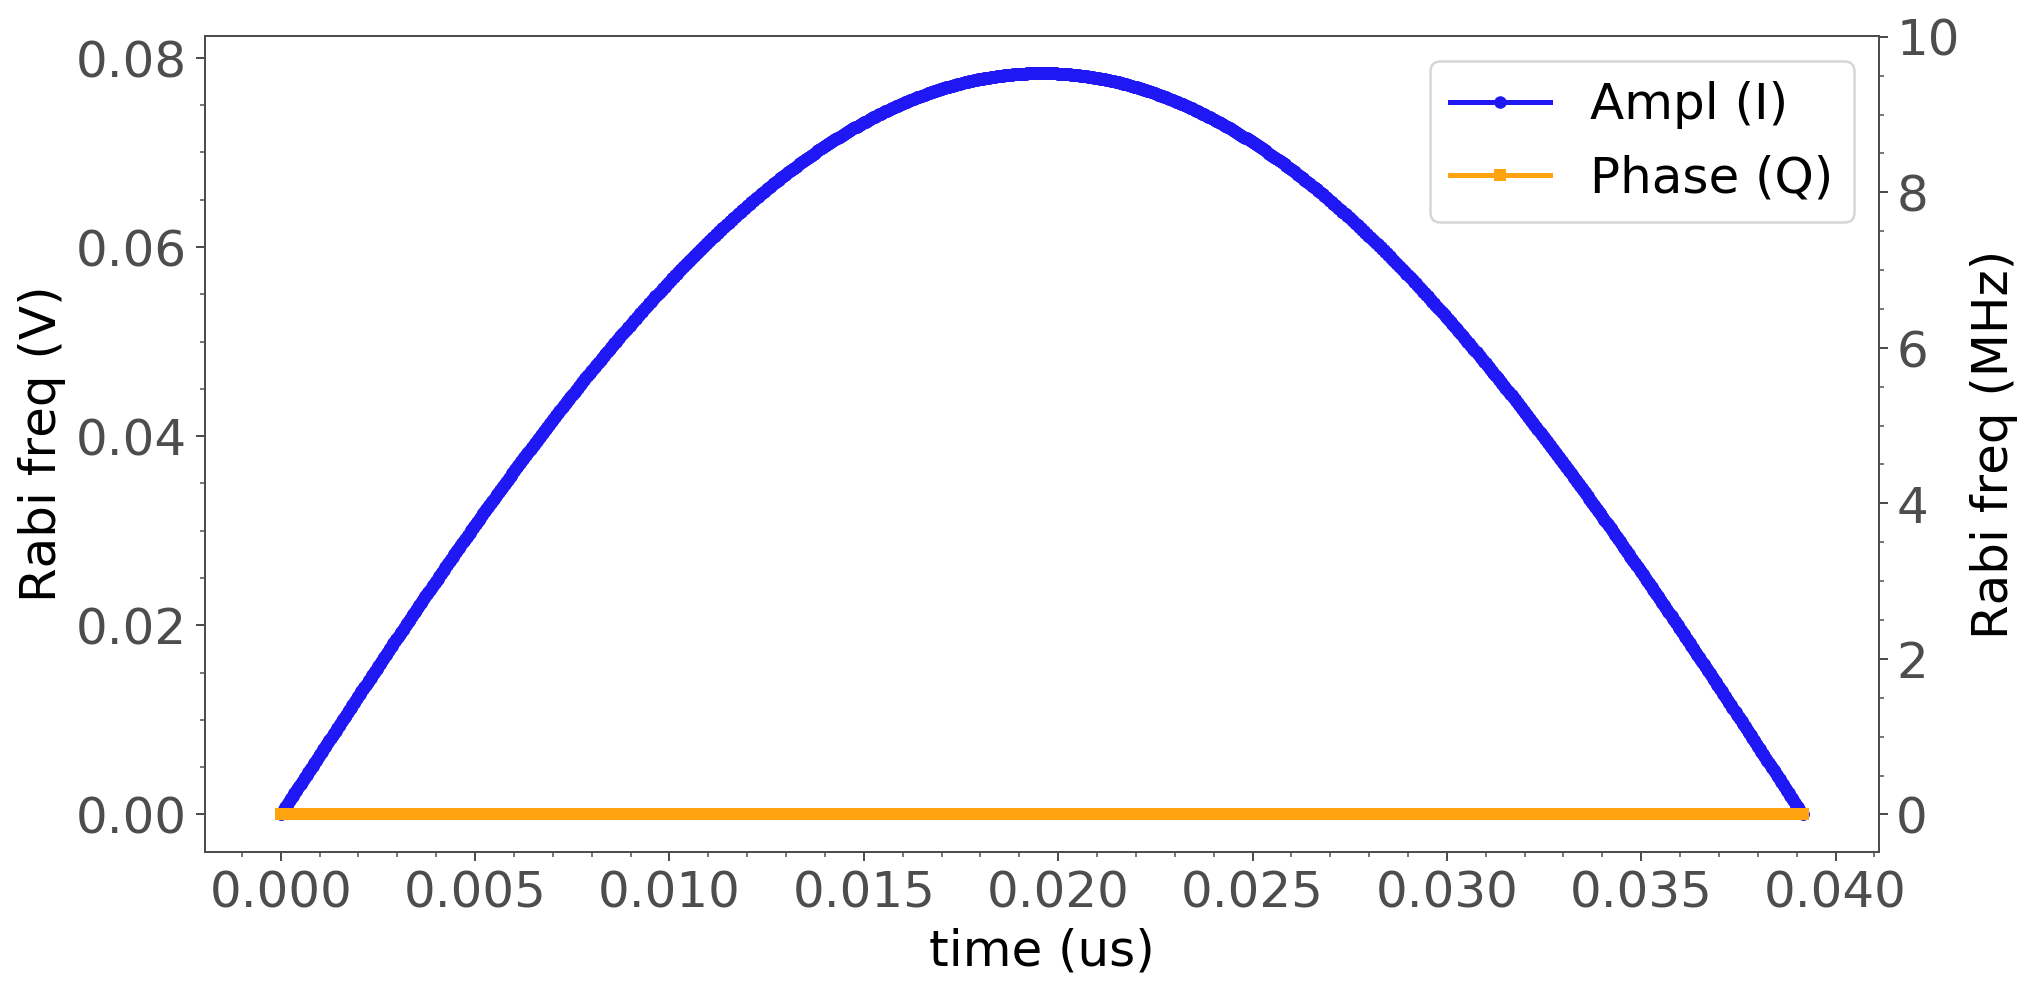

In [317]:
import matplotlib.pyplot as plt

p_plot = pulse
p_plot = pulses_to_optimize[0] #pulses_test[2]

t_amplitude = p_plot.get_timegrid(unit='us')
t_phase = p_plot.get_timegrid(unit='us')
try:
    amplitude = p_plot.get_data_ampl(unit='V')
    phase = p_plot.get_data_phase(unit='V')
    max_ampl = np.max([np.max(phase), np.max(amplitude)])
except ValueError:
    amplitude, phase, max_ampl = None, None, None
    
try:
    amplitude_rabi = p_plot.get_data_ampl(unit='MHz')
    phase_rabi = p_plot.get_data_phase(unit='MHz')
    max_rabi = np.max([np.max(amplitude_rabi), np.max(phase_rabi)])
except ValueError:
    amplitude_rabi, phase_rabi, max_rabi = None, None, None



try:
    #plt.figure(figsize=(10,6))
    fig, ax1 = plt.subplots()
    if amplitude is not None:
        ax1.plot(t_amplitude, amplitude, label="Ampl (I)")
        ax1.plot(t_phase, phase, label="Phase (Q)")
        ax1.set_ylabel("Rabi freq (V)")
        ax1.set_xlabel("time (us)")
    else:
        ax1.get_yaxis().set_visible(False)
        
    ax2 = ax1.twinx()
    if amplitude_rabi is not None:
        ax2.plot(t_amplitude, amplitude_rabi, label="Ampl (I)")
        ax2.plot(t_phase, phase_rabi, label="Phase (Q)")
        ax2.set_ylabel("Rabi freq (MHz)")
    else:
        ax2.get_yaxis().set_visible(False)
    
    # plt.plot(t_phase, phase+amplitude, label="I+Q")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")
    
    
max_ampl, max_rabi

Plot samples pulse and check whether amplitude rescaling is needed.

(0.017521694167378234, 1.0)

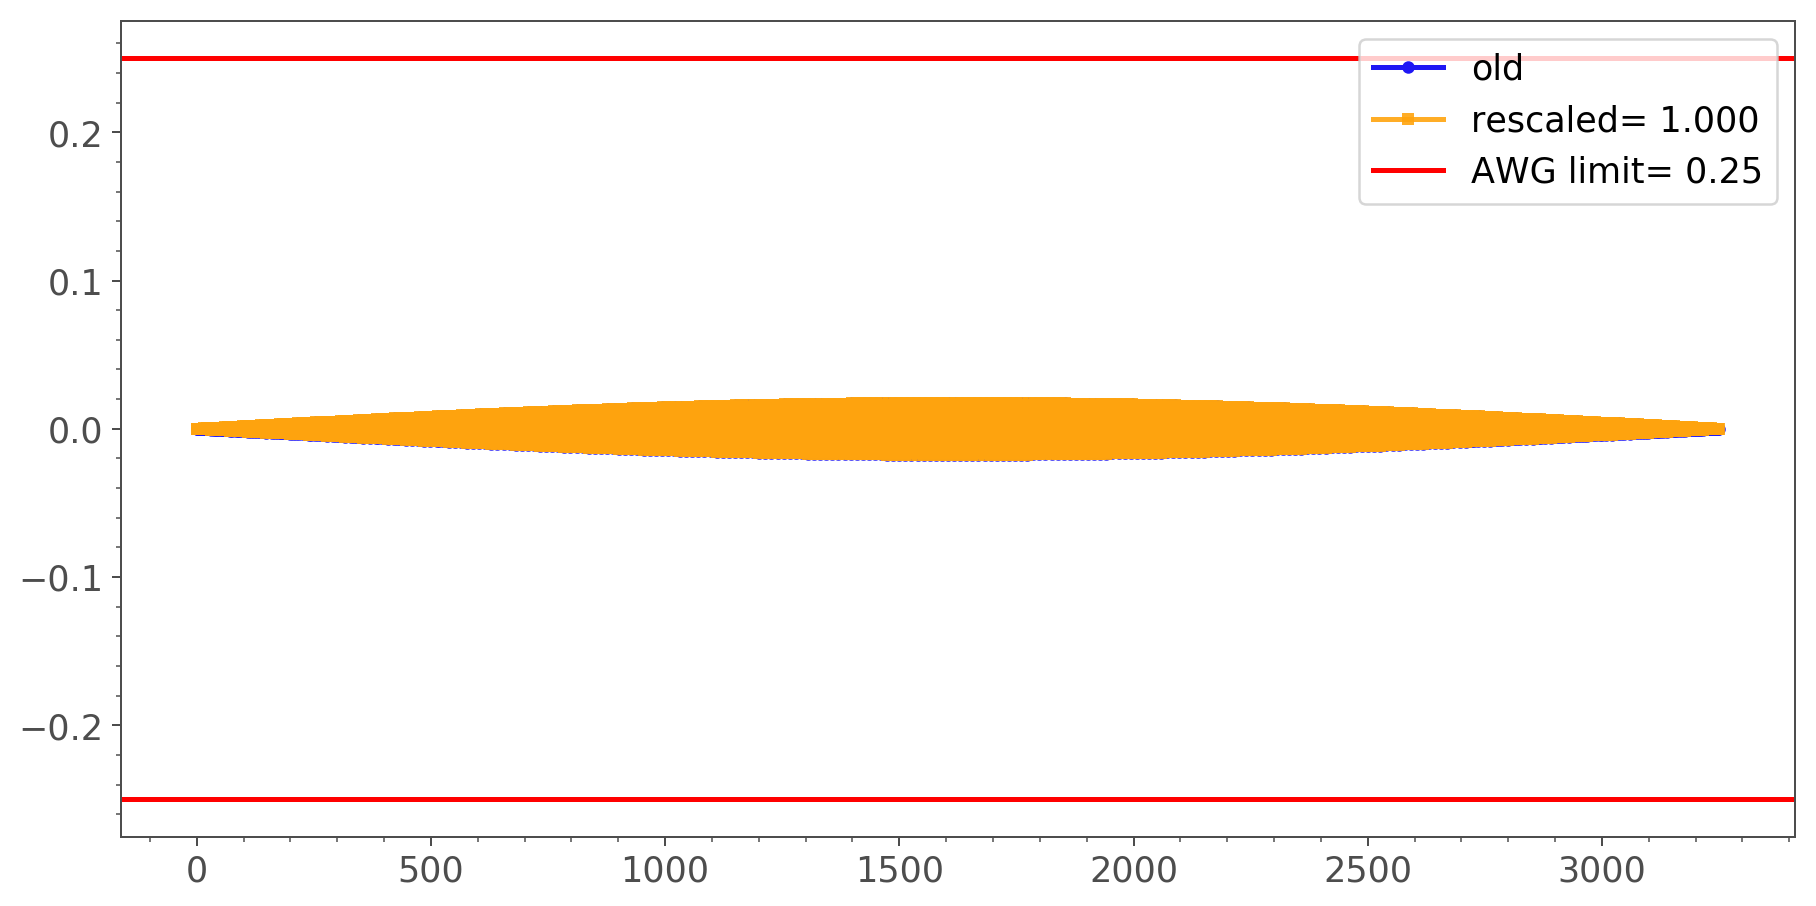

In [1027]:
f_res = 2500e6

max_old = np.max(sample_pulse(p_plot, f_res))

fac = get_rescale_factor_ampl(p_plot, f_res, max_ampl_v=ampl_max)
samples = sample_pulse(p_plot, f_res)

pulse_new = cp.deepcopy(p_plot)
pulse_new._data_ampl  = fac*pulse_new._data_ampl
pulse_new._data_phase = fac*pulse_new._data_phase
samples_new = sample_pulse(pulse_new, f_res)


max_new = np.max(sample_pulse(pulse_new, f_res))


plt.plot(samples, label="old")
plt.plot(samples_new, label=f"rescaled= {fac:.3f}", alpha=0.9)
plt.axhline(ampl_max, color='red', label=f'AWG limit= {ampl_max}')
plt.axhline(-ampl_max, color='red')

plt.legend()
plt.show()

np.max(samples), fac

### Pulse preperation (optional)
Quocs will during optimization create 2 files per pulse that should be optimized. If those need to be manipulated (eg. to synthesize pi pulses out of of optimized pi2 pulses), use an optional pulse prepeartion function here.

In [365]:
filename = 'pix=0.25,0_p0_'

In [35]:
try:
    
    def synth_longer_mirror_pulses(folder_path, key, idx_key_list=None, factors=[1], filenames=[],
                            name_ampl="amplitude.txt", name_phase="phase.txt", names_only=False):
        
        func1 = synth_longer_pulses(folder_path, key, idx_key_list=idx_key_list, factors=factors, filenames=filenames,
                            name_ampl=name_ampl, name_phase=name_phase)
        new_files = synth_longer_pulses_fnames(folder_path, filenames=files, 
                                            key='pix', factors=factors_nrep)
        
        func2 = mirror_pulse_1_on_2(folder_path, filenames=filenames + new_files,
                            name_ampl=name_ampl, name_phase=name_phase)
        
        def _prep_func():
            func1()
            func2()
            
        return _prep_func
        
    def synth_longer_pulses(folder_path, key, idx_key_list=None, factors=[1], filenames=[],
                            name_ampl="amplitude.txt", name_phase="phase.txt", names_only=False):
        
        new_names = []
        def _prep_func():            
            for filename in filenames:
                for factor in factors:
                    fname_new = _get_fname_longer_pulse(filename, key='pix', 
                                                        factors=[factor], idx_key_list=idx_key_list)[0]
                    if not names_only:
                        pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
                        pulse_new = tile_pulse(pulse, factor)
                        pulse_save(folder_path, pulse_new, name=fname_new,
                                   name_ampl=name_ampl, name_phase=name_phase)
                    new_names.append(fname_new)
        
        if not names_only:
            return _prep_func
        else:
            _prep_func()
            return new_names
        
    
    def mirror_pulse_1_on_2(folder_path, filenames=[],
                        name_ampl="amplitude.txt", name_phase="phase.txt", names_only=False):
        # use with care,Rabi frequencies different on mirrored line!
        new_names = []
        def _prep_func():
            for filename in filenames:
                fname_new = mirror_nvs_name(filename)
                if not names_only:
                    pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
                    pulse_save(folder_path, pulse, name=fname_new,
                               name_ampl=name_ampl, name_phase=name_phase)
                new_names.append(fname_new)

        if not names_only:
            return _prep_func
        else:
            _prep_func()
            return new_names
    

    def _get_fname_longer_pulse(fname, key, factors=[1], idx_key_list=0):
        Tk_string.params_from_str(fname, [key]), filename

        pix_length = Tk_string.params_from_str(fname, [key])[key]
        if idx_key_list is not None:
            pix_length = pix_length[idx_key_list]
        pix_length

        target_length = [pix_length*fac for fac in factors]

        substrs = fname.split(f"{key}=")
        var_str = substrs[1].split("_", 1)

        total_str = substrs[0] + f"{key}=" + var_str[0] + "_" + var_str[1]
        #fname_ampl

        new_strs = []
        for fac in factors:
            new_var = [fac*float(val) for val in Tk_string.find_num_in_str(var_str[0])]
            new_var_str = str(new_var).strip("[").strip("]").replace(" ","")

            total_new_str = substrs[0] + f"{key}=" + new_var_str + "_" + var_str[1]
            new_strs.append(total_new_str)

        return new_strs


    def tile_pulse(pulse, nreps):
        # todo: move into ArbPulse class

        p_longer = cp.deepcopy(pulse)
        p_longer._file_ampl, p_longer._file_phase = None, None
        p_longer.length_pix = int(nreps)*p_longer.length_pix 

        timegrid = pulse._timegrid_ampl

        dt = timegrid[1]-timegrid[0]
        # linspace seems to create rounding errors
        #new_timegrid = np.linspace(timegrid[0], int(nreps)*timegrid[-1]+int(nreps-1)*dt, int(nreps)*len(timegrid))

        new_timegrid = timegrid

        for i in range(int(nreps)-1):
            last_samples = new_timegrid[-len(timegrid):]
            new_timegrid = np.concatenate([new_timegrid, 
                                       last_samples + timegrid[-1] + dt])

        assert all(np.equal(timegrid, new_timegrid[:len(timegrid)]))

        p_longer._timegrid_ampl = new_timegrid
        p_longer._timegrid_phase = new_timegrid
        p_longer._data_ampl = np.tile(pulse._data_ampl, int(nreps))
        p_longer._data_phase = np.tile(pulse._data_phase, int(nreps))

        return p_longer
    
                
    def _manipulate_param_in_name(filename, key, manipulate_func):
        if not f"{key}=" in filename:
            return filename
            
        substrs = filename.split(f"{key}=")
        var_str = substrs[1].split("_", 1)
        if len(var_str) ==1:
            var_str.append("")
        param_str = Tk_string.params_from_str(filename, [key], seperators=["=","_"])[key]
        manipulated_str = manipulate_func(param_str)
        manipulated_str = str(manipulated_str).strip("[").strip("]").replace(" ","")
        total_new_str = substrs[0] + f"{key}=" + manipulated_str 
        if var_str[1] != "":
            total_new_str = total_new_str + "_" + var_str[1]
        return total_new_str
    
    def multi_pulse_2_name_pix_1(pulse_idx, filename):


        filename_swapped = _swap_pix_filename(filename)
        filename_par = _make_par_pix_filename(filename)
        
        if pulse_idx == 0:
            return f"{filename}p1_on_nv=1_par=2"
        elif pulse_idx ==1:
            return f"{filename}p2_on_nv=2_par=1"
        elif pulse_idx ==2:
            return f"{filename_swapped}_p1_on_nv=2_par=1"
        elif pulse_idx ==3:
            return f"{filename_swapped}_p2_on_nv=1_par=2"
        elif pulse_idx == 4:
            return f"{filename_par}_p1_on_nv=1_par=2"
        elif pulse_idx == 5:
            return f"{filename_par}_p2_on_nv=2_par=1"
        else:
            raise ValueError
            
    def multi_pulse_2_name_pix_2(pulse_idx, filename):
        # no correction pulsese

        #filename_swapped = _swap_pix_filename(filename)
        
        if pulse_idx == 0:
            return f"{filename}p1_on_nv=1"
        elif pulse_idx ==1:
            return f"{filename}_p1_on_nv=2"
        else:
            raise ValueError
    
    def multi_pulse_2_name_pix_par_2(pulse_idx, filename):


        filename_swapped = _swap_pix_filename(filename)
        
        if pulse_idx == 0:
            return f"{filename}p1_on_nv=1_par=2"
        elif pulse_idx ==1:
            return f"{filename}p2_on_nv=2_par=1"
        else:
            raise ValueError
    
    def _swap_pix_filename(filename):
        return _manipulate_param_in_name(filename, 'pix', lambda x: x[::-1])
    
    def _make_par_pix_filename(filename):
        return _manipulate_param_in_name(filename, 'pix', lambda x: [x[0], x[0]])
    
    def _swap_nv(nv):
        if nv==1:
            return 2
        elif nv==2:
            return 1
        else:
            raise ValueError

    def swap_nvs_name(filename):
        for key in ['on_nv', 'par']:
            filename = _manipulate_param_in_name(filename, key, _swap_nv)
        return filename
    
    def mirror_nvs_name(filename):
        for key in ['on_nv', 'par']:
            filename = _manipulate_param_in_name(filename, key, _swap_nv)
        filename = _manipulate_param_in_name(filename, 'pix', lambda x: x[::-1])
        return filename
    

    
    
    
    
except:
    logger.exception("")

0


0

In [62]:
script_params['multi_pulse_2_name_function']#(3, filename)
script_params['multi_pulse_2_name_function'](4, filename)

In [65]:
multi_pulse_2_name_pix_1(5, filename)


'pix=0.5,0.5_p2_on_nv=2_par=1'

In [158]:
script_params['multi_pulse_2_name_function']

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-158-9c3a3a7bb1c6>", line 1, in <module>
    script_params['multi_pulse_2_name_function']
KeyError: 'multi_pulse_2_name_function'


In [603]:
_swap_pix_filename('pix=0.5,0.0_p1_on_nv=1_par=2_')


'pix=0.0,0.5_p1_on_nv=1_par=2_'

In [1529]:
filename, (filename), swap_nvs_name(filename)

('pix=0.25,0.0_', 'pix=0.0,0.25', 'pix=0.25,0.0_')

In [1499]:
filename, script_params['multi_pulse_2_name_function'](0, filename), script_params['multi_pulse_2_name_function'](1, filename)

('pix=0.25,0.0_', 'pix=0.25,0.0_p1_on_nv=1_par=2', 'pix=0.25,0.0_p2_on_nv=2_par=1')

In [1430]:
testname = multi_pulse_2_name_pix_1(1, filename)
testname, swap_nvs_name(testname)

('pix=0.0,0.25_p2_on_nv=2_par=1', 'pix=0.0,0.25_p2_on_nv=1_par=2')

In [1283]:
var_str, filename

(['0.25,0', ''], 'pix=0.25,0')

In [1181]:
script_params['pulse_prepare_function']()

### Init & Transfer to Qudi-QuOCS

In [284]:
optimization_dictionary['algorithm_settings']["dsm_settings"] = {'general_settings': {
                                                "dsm_algorithm_name": "NelderMead", 
                                                #"dsm_algorithm_name": "CMAES", 
                                                'is_adaptive': False
                                            }, 
                                            'stopping_criteria': {
                                                #"max_eval": 100,
                                                #"time_lim": 5*60,  # (min), experimental
                                                "time_lim": 800*1.7,  # (min), experimental, long
                                                #"time_lim": 30*3, # (min), simulation
                                                #"xatol": 1e-10, 
                                                #"frtol": 1e-10,
                                                "change_based_stop": {
                                                    "cbs_funct_evals": 300,  # calc gradient over n
                                                    "cbs_change": script_params['readout_noise']      # stop if slope below, should ~ 2*std(FOM)
                                                }
                                            }
}
optimization_dictionary['algorithm_settings'], script_params['readout_noise']


({'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 99999, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 30, 'num_average': 2}, 're_evaluation': {'re_evaluation_steps': [0.3, 0.5, 0.51]}, 'dsm_settings': {'general_settings': {'dsm_algorithm_name': 'NelderMead', 'is_adaptive': False}, 'stopping_criteria': {'time_lim': 1360.0, 'change_based_stop': {'cbs_funct_evals': 300, 'cbs_change': 0.02}}}, 'optimization_direction': 'minimization', 'max_eval_total': 10000000000}, 0.02)

In [287]:
opti_comm_dict = {"optimization_dictionary": optimization_dictionary}
optimizationlogic.load_opti_comm_dict(opti_comm_dict)

Press "Start" in the gui and see whether errors are logged.

Print the optimization dictionary also here. If the GUI is not showing the optimization dictionary, restart the Kernel.

In [227]:
optimalcontrol.opti_comm_dict['optimization_dictionary']['algorithm_settings']['dsm_settings'].keys()

dict_keys(['general_settings', 'stopping_criteria'])

## Save (rescaled) pulse to disk

1. When loading, keep ampl_rect, t_rabi_rect like in calibration of old pulse
2. Do rescaling here with new calibration => keeps the Rabi frequency constant, but scales ampl (V)
3. Save again with new calibration

In [857]:
def rescale_data_linear(pulse, ampl_rect, t_rabi):
    pulse.set_unit_data('V')


    _func_new = lambda x: x/ampl_rect*(1e-6/t_rabi)
    _func_inv_new = lambda y: y/(1e-6/t_rabi)*ampl_rect
    
    fac = pulse._func_ampl_v_2_omega_mhz(1)/_func_new(1)
    
    pulse._data_ampl  = fac*pulse._data_ampl
    pulse._data_phase = fac*pulse._data_phase
    
    pulse._func_ampl_v_2_omega_mhz = _func_new
    pulse._func_omega_mhz_2_ampl_v = _func_inv_new
    
    return fac




In [860]:
t_rabi_rect, ampl_rect

([1.25e-08, 1.25e-08], [1, 1])

In [863]:
cal_new(1)

190.47619047619048

In [866]:
factor_mes = 0.42 # 1.0
t_rabi_rect_new = 12.5e-9 # 64.9e-9 #22.4e-9
ampl_rect_new = factor_mes*1 #0.65*0.1250 # 0.25

cal = pulse._func_ampl_v_2_omega_mhz  # MHz/V
cal_new = lambda x: x/ampl_rect_new*(1e-6/t_rabi_rect_new)

cal_new(1)/cal(1)

2.380952380952381

In [872]:
rescale_data_linear(pulse, ampl_rect_new, t_rabi_rect_new)

t_rabi_rect = [t_rabi_rect_new]
ampl_rect = [ampl_rect_new]

optimization_dictionary['oc_pulse_params'] = {'t_rabi_rect': t_rabi_rect, 't_oc_pulse': t_oc_pulse,
                                              'ampl_max': ampl_max, 'ampl_rect': ampl_rect}
opti_comm_dict['optimization_dictionary'] = optimization_dictionary['oc_pulse_params']

optimization_dictionary['oc_pulse_params']

{'t_rabi_rect': [1.25e-08], 't_oc_pulse': 2e-07, 'ampl_max': 0.23, 'ampl_rect': [0.42]}

0.5

In [365]:
pulse._func_ampl_v_2_omega_mhz(1)

140.79999999999998

In [266]:
opti_comm_dict['optimization_dictionary']

{'optimization_client_name': 'test_dCRAB_Noisy_2_control_fields', 'opti_algorithm_module': 'quocslib.optimalalgorithms.dCRABNoisyAlgorithm', 'opti_algorithm_class': 'DCrabNoisyAlgorithm', 'algorithm_settings': {'algorithm_name': 'dCRAB', 'super_iteration_number': 10000000, 'FoM_goal': 1e-05, 'total_time_lim': 99999, 'compensate_drift': {'compensate_after_SI': True, 'compensate_after_minutes': 25}, 'random_number_generator': {'seed_number': 420}, 'dsm_settings': {'general_settings': {'dsm_algorithm_name': 'NelderMead', 'is_adaptive': False}, 'stopping_criteria': {'time_lim': 300, 'change_based_stop': {'cbs_funct_evals': 500, 'cbs_change': 0.01}}}}, 'times': [{'time_name': 'time_p', 'initial_value': 1e-07}], 'oc_pulse_params': {'t_rabi_rect': 5.95e-08, 't_oc_pulse': 1e-07, 'ampl_max': 0.23, 'ampl_rect': 0.168}}

In [83]:
opti_comm_dict = {"optimization_dictionary": optimization_dictionary}

folder_path = r'C:\Software\qudi_data\optimal_control_assets'
try:
    pulse_save(folder_path, pulse, name="new_", name_ampl="amplitude.txt", name_phase="phase.txt")
except:
    logger.exception("")

# Measurement

Run a normal rect Rabi with all analysis and MW generation parameters before. Then run with commented out the dicts below in order to keep all the respective pulsed settings.

In [347]:
pix_pulse, common.rabi_period

(0.5, 6.97e-08)

In [290]:
simp = SimParameters() 

script_params['runtime_per_epoch'] = 1.5*60  # 5*60 s
script_params['runtime_per_epoch'] = 0.5*60  # 5*60 s
script_params['runtime_per_epoch'] = 1.5*60  # 5*60 s

#script_params['runtime_per_epoch'] = 1.7*60  # 5*60 s
script_params['readout_noise'] = 0.02 #24  # std_dev of fom, controls convergence in iteration
#script_params['readout_noise'] = 0.015
# for 40s of procTomo
#script_params['readout_noise'] = 0.023 # for 4*40s, procTomo

# needs to be smaller than the actual pulse length time_p due to the interpolation
script_params['length_oc'] = t_oc_pulse - 1e-9
script_params['is_noisy'] = True

# file paths 
folder_path = r'C:\Software\qudi_data\optimal_control_assets'
filename= f"pix={pix_pulse:.1f},0.0_"                # single kron(X,1) pulses with par correction applied
#filename= f"pix={pix_pulse:.2f},0.0_"  
#filename= f"pix={pix_pulse:.1f}_"                   # single kron(X) pulses, no correction
#filename= f"pix={pix_pulse:.1f},{pix_pulse:.1f}_"   # only parallel kron(X,X) pulses

# pg generation settings
p_generation_dict = pulsedmasterlogic.generation_parameters
#p_generation_dict["laser_channel"] = "d_ch2" 
#p_generation_dict["sync_channel"] = "d_ch1" 
#p_generation_dict["gate_channel"] = None#"d_ch1" 
#p_generation_dict["microwave_channel"] = "a_ch1"
#p_generation_dict["microwave_amplitude"] = 0.25
#p_generation_dict["microwave_frequency"] = 2822.3e6
#p_generation_dict["rabi_period"] = 82.7e-9
#p_generation_dict["laser_length"] = 3e-06
#p_generation_dict["laser_delay"] = 0.2e-6
#p_generation_dict["wait_time"] = 1e-06
#p_generation_dict["analog_trigger_voltage"] = 0.0

# load the general measurement parameters for the predefined measurements
pulsedmasterlogic.set_generation_parameters(p_generation_dict)
script_params['pulsed_generation_params'] = pulsedmasterlogic.generation_parameters

filename, script_params['pulsed_generation_params']

('pix=1.0,0.0_', OrderedDict([('laser_channel', 'd_ch1'), ('sync_channel', ''), ('gate_channel', 'a_ch2'), ('microwave_channel', 'a_ch1'), ('microwave_frequency', 2570990000.0), ('microwave_amplitude', 0.48), ('rabi_period', 4.487e-08), ('laser_length', 3e-06), ('laser_delay', 5e-07), ('wait_time', 1e-06), ('analog_trigger_voltage', 0.25), ('optimal_control_assets_path', 'C:\\Software\\qudi_data\\optimal_control_assets'), ('pulse_envelope', PulseEnvelopeType(sin_n))), ('t_laser_fci_red', 2.5e-06), ('t_laser_fci_green', 5e-07), ('t_wait_fci', 1e-06), ('t_safety_fci', 1e-06), ('laser_read_red_ch', 'd_ch3'), ('done_fci_ch', 'd_ch1'), ('add_gate_ch', 'd_ch4')]))

## Set measurement sequence and fom

In [293]:
   
script_params['pulse_prepare_function'] = None
script_params['fom_func_volt_2_rabi'] = None

try:

    #qmeas = setup_sts_oc_pi(folder_path, filename, script_params['length_oc'])
    #qmeas = setup_oc_proctomo(folder_path, filename, script_params['length_oc'])

    #qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'])
    # for OC pulse on NV2 (control): from states 0, 1
    #qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0.25/2.1e6, n_n=4)
    #qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=1/2.1e6, n_n=8)
    #qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=0, n_n=4)
    #qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'],
    #                     t_gap=750e-9, n_n=8,init_end_pix=0.5,
    #                     symmetrize=True, dd_type=DDMethods.XY8, alternating_end_phase=True)
    to_basis_pair_rot = np.pi/2
    to_basis_pair_rot = None
    
    qmeas =  setup_oc_randbench(folder_path, filename, script_params['length_oc'], x_min=1, x_max=1, rand_max=10,
                               to_basis_pair_rot=to_basis_pair_rot)
    
    # optimizting pi pulse in ddxdd emperiment or just enable OC inside rand bench
    qmeas = add_ddxdd(qmeas, dd_parallel=True)
    qmeas = add_ddxdd(qmeas, ddxdd=False, dd_parallel=False,
                      oc_1q=False, oc_cphase=True)
    #qmeas = add_ddxdd(qmeas, dd_parallel=False, par_drive_oc=True)
    
    # for OC pulse on NV1 (target): from states X,Y
    # todo: IS IT ENOUGH to do pi2X-MWX-pi2X and pi2Y-MWY-pi2Y or do we need pi2X-MWY-pi2X (spin lock)
    #qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], t_gap=1/2.1e6, n_n=8,
    #                     phases_oc=[0], init_end_pix=0.5, init_end_phases_deg=[0])
    #                   # phases_oc=[0, 90], init_end_pix=0.5, init_end_phases_deg=[0, 90])
    # From simulated ProcTomo: OC pi from ResserMsc is roughly Y pulse
    # => need to adapt phases
    #qmeas = setup_oc_npi(folder_path, filename, script_params['length_oc'], n_n=4, t_gap=2/2*1/2.1e6, 
    #                    #phases_oc=[0,90], init_end_pix=0.5, init_end_phases_deg=[0, 90])
    #                     phases_oc=[0], init_end_pix=0.5, init_end_phases_deg=[0])

    qmeas['optimize_time'] = 30*60

    f_res = 2825.3e6                 # ms=-1 NV1
    f_block = [f_res + 96e6, 2935.6e6]  # ms=-1 NV2, ms=+1 NV2
    #f_block = [f_res+ 96e6] 
    #fom_func = setup_fom_func_oc_npi(dd_type=DDMethods.XY8)
    #fom_func = setup_fom_func_oc_proctomo(rho_mode='v1')
    fom_func = setup_fom_func_randbench_baseline()

    # add penalty to fom and register parameters
    script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)
    script_params['fom_func_volt_2_rabi'] = None # no simulated property

    #fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=100, symm_block=True, n_f_sim=75)


    script_params['generate_parameters'] = qmeas
    script_params['fom_function'] = fom_func
    
    
    # pulse preperation (from quocs -> qudi)
    synth_long_pulses = True
    factors_nrep =  [2]
    factors_nrep =  [1]
    n_pulses = len(pulses_to_optimize)
    optimize_single_par_pulse = True
    optimize_single_par_pulse = False
    
    if synth_long_pulses and not optimize_single_par_pulse:
        script_params['multi_pulse_2_name_function'] = multi_pulse_2_name_pix_1
        files = []
        for idx in range(n_pulses):
            filename_expand_p = script_params['multi_pulse_2_name_function'](idx, filename) + "_"
            files.append(filename_expand_p)

        script_params['pulse_prepare_function'] = synth_longer_pulses(folder_path, filenames=files, 
                                                                      key='pix', factors=factors_nrep)
    
    if optimize_single_par_pulse:
        script_params['multi_pulse_2_name_function'] = multi_pulse_2_name_pix_par_2
    
    #script_params['multi_pulse_2_name_function'] = multi_pulse_2_name_pix_2
    
except:
    logger.exception("")
qmeas

#qmeas['comp_type'], script_params['generate_parameters']
qmeas['comp_type'].__dict__, script_params['pulse_prepare_function']
qmeas['env_type'], files
qmeas

OrderedDict([('name', 'rand_benchmark_1q'), ('experiment', 'rand_benchmark'), ('savetag', 'rand_benchmark'), ('microwave_amplitude', 0.48), ('microwave_frequency', 2570990000.0), ('rabi_period', 4.487e-08), ('rotations_file', 'C:\\Users\\Setup3-PC\\Desktop\\qudi\\user_scripts\\Timo\\own\\rand_benchmark/20230914-1200-43_rb_seq_2q_ncxfix_decomp=ferlemann_opt1Qs.json'), ('xticks', '0, 1.0, 1.0001, 1.0002, 1.0003, 1.0004, 1.0005, 1.0006, 1.0007, 1.0008, 1.0009'), ('rotations', '<TomoRotations.none: 0>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.ux180min_on_2: 16>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.uy90min_on_1: 9>, <TomoRotations.none: 0>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.ux90min_on_2: 8>, <TomoRotations.uy90_on_2: 4>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.uy90_on_1: 3>, <TomoRotations.u

In [115]:
qmeas = script_params['generate_parameters'] 
#qmeas

In [74]:
# DEBUG only, disable OC
qmeas = script_params['generate_parameters'] 

qmeas['env_type'] = Evm(common.rabi_shaped['env_type'])
env = qmeas['env_type']
if env.parameters.get('par_drive_on_func'):
    env.parameters['par_drive_on_func'] = None
    logger.info(f"Reset par_drive_func for {env}")

script_params['generate_parameters'] = qmeas

    
script_params['generate_parameters']['env_type'].__dict__

{'_value_': 'sin_n', '_name_': 'sin_n', '__objclass__': <enum 'PulseEnvelopeType'>, '_parameters': {'order_n': 1}}

### oc pi in cnot gate

In [852]:
def get_fname_pulsed_oc(on_nv=1, pix=1):
    database = sequencegeneratorlogic._optimal_pulses
    for pulse in database:
        if pulse._pi_x == pix and pulse._on_nv == on_nv:
            return os.path.abspath(pulse.file)
    return None


def prep_pulse_sts_oc_cnot(inpulse_name, scale_ampls=[1,1]):
    """
    Prepare pulses for use in generate_methods that use auto-loading of optimal control pulses
    from an optimal_control_assets folder.
    Loads current optimized pulse as saved in run loop.
    Scales to respective powers for nv1/nv2 and saves it with filenames as expected from sequencegenerator.
    """
    
    def prep_func():
        pulse = ArbPulse.load_pulse(folder_path, inpulse_name, unit_t='s', unit_data='V')

        out_pulsename_nv1 = os.path.basename(get_fname_pulsed_oc(on_nv=1, pix=1))
        out_pulsename_nv2 =  os.path.basename(get_fname_pulsed_oc(on_nv=2, pix=1))
        out_pulsenames = [out_pulsename_nv1, out_pulsename_nv2]
        if out_pulsename_nv1 is None or out_pulsename_nv2 is None:
            raise ValueError("Sequencegenerator hasn't loaded pi pulses on nv1 and nv2")


        # alter the calibration curve
        save_pulse_params = cp.deepcopy(optimization_dictionary['oc_pulse_params'])

        for idx in [0,1]:

            # rescale pulse amplitudes
            scale_fac = scale_ampls[idx]
            if scale_fac > 1:
                raise ValueError("Please load a base pulse (on_nv=1/2) such that only scaling < 1 can occur for the other NV!")
                
            optimization_dictionary['oc_pulse_params'] = cp.deepcopy(save_pulse_params)
            ampl_calib = optimization_dictionary['oc_pulse_params']['ampl_rect']
            optimization_dictionary['oc_pulse_params']['ampl_rect'] = scale_fac*ampl_calib

            t_amplitude = pulse.get_timegrid(unit='s')
            t_phase = pulse.get_timegrid(unit='s')
            amplitude = scale_fac*pulse.get_data_ampl(unit='V')
            phase = scale_fac*pulse.get_data_phase(unit='V')

            data_ampl = np.column_stack((t_amplitude, amplitude))
            data_phase = np.column_stack((t_phase, phase))

            save_pulse(folder_path, data_ampl, data_phase, name=out_pulsenames[idx])
            logger.debug(f"Resaved scaled pulse (fac={scale_fac}) {inpulse_name} -> {out_pulsenames[idx]}")

        optimization_dictionary['oc_pulse_params'] = save_pulse_params
    
    return prep_func
    

0



0

Need to rescale same oc pulse to both NVs with different power calibration. ATTENTION: prep function doesn't take currently loaded pulse, but a fixed filename.

In [944]:
fac_scale_nv1_2 = 1/((common.mw_amp/common.rabi_period)/(common.mw_amps_2[0]/common.t_rabi_2_rect[0]))
fac_scale_nv1_2

2.24206376309061

In [858]:
script_params['fom_func_volt_2_rabi'] = None

dd_type = DDMethods.XY8
dd_order = 2
dd_cnot_tau = -225e-9
tau_dd_fix = 1.0e-6

qmeas = None
qmeas = setup_sts_oc_cnot(folder_path, filename, length_oc, tau_dd_fix, dd_cnot_tau,
                      dd_type_cnot=dd_type, dd_order=dd_order)
                  
qmeas['optimize_time'] = 45*60   


fom_func = setup_fom_func_sts_cnot()
pulse_prep_func = prep_pulse_sts_oc_cnot(filename, scale_ampls=[1/fac_scale_nv1_2, 1])
          
    
script_params['generate_parameters'] = qmeas
script_params['fom_function'] = fom_func
script_params['pulse_prepare_function'] = pulse_prep_func



fom_func

<function setup_fom_func_sts_cnot.<locals>.calc_fom at 0x0000004C2E69C158>

Call prep function to save power rescaled files of same pi pulse to asset folder. ATTENTION: prep function doesn't take currently loaded pulse, but a fixed filename.

In [1168]:
try:
    pulse_prep_func()
except:
    logger.exception("")

get_pulse_filename(folder_path, filename)

('C:\\Software\\qudi_data\\optimal_control_assets\\on_nv=2_amplitude.txt', 'C:\\Software\\qudi_data\\optimal_control_assets\\on_nv=2_phase.txt')

In [814]:
try:
    a = fom_func()
except:
    logger.exception("")
    
a

0.9369641701061575

In [918]:
qmeas

{'name': 'sts_cnot', 'rotations': '[<TomoRotations.c2not1: 6>, <TomoRotations.c2not1: 6>, <TomoRotations.c2not1: 6>, <TomoRotations.c2not1: 6>]', 'init_states': '[<TomoInit.none: 0>, <TomoInit.ux180_on_1: 7>, <TomoInit.ux180_on_2: 8>, <TomoInit.ux180_on_both: 9>]', 'tau_cnot': -2.25e-07, 'dd_type_cnot': <DDMethods.XY8: [0.0, 90.0, 0.0, 90.0, 90.0, 0.0, 90.0, 0.0]>, 'dd_order': 2, 'f_mw_2': '2825300000.0', 'ampl_mw_2': '0.18737600000000001', 'rabi_period_mw_2': '6.14e-08', 'alternating': True, 'init_state_kwargs': '', 'cnot_kwargs': {'tau_dd_fix': 1e-06, 'env_type': <EnvelopeMethods.optimal: 'OptimalControl'>}}

### oc crosstalk (exp) + procTomo (sim)

Measure crosstalk on nv1, which SHOULD BE the one closer to 2.87 GHz to take into account crosstalk to ms=0/+1 transition. Otherwise assume that crosstalk is symmetrical and we don't need to measure explicitly on nv2.

In [1156]:
script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)

try:
    qmeas = setup_oc_crosstalk(folder_path, filename, length_oc, on_nv="1,2")

    qmeas['optimize_time'] = 45*60   


    f_res = common.mw_freq
    fom_func = setup_fom_simulation_proctomo(f_res, delta_hfs=2.1e6)
    fom_func = add_penalty_exp_crosstalk(fom_func, fac_penalty=10, first_fom_req_pulse=True)

    # oc pulse on nv1, non-oc pi pulse on nv2
    # scaling only needed as oc pulse is generated in terms of nv2 amplitude
    pulse_prep_func = prep_pulse_sts_oc_cnot(filename, scale_ampls=[1/fac_scale_nv1_2, 1])


    script_params['generate_parameters'] = qmeas
    script_params['fom_function'] = fom_func
    script_params['pulse_prepare_function'] = pulse_prep_func
except:
    logger.exception("")


fom_func

<function add_penalty_exp_crosstalk.<locals>.extend_fom at 0x0000004CBF279B70>

DEBUG section

In [1148]:
qmeas

{'name': 'oc_crosstalk', 'rotations': '[<TomoRotations.none: 0>, <TomoRotations.none: 0>, <TomoRotations.none: 0>]', 'init_states': '[<TomoInit.none: 0>, <TomoInit.ux180_on_1: 7>, <TomoInit.ux180_on_2: 8>]', 'tau_cnot': 0.0, 'dd_type_cnot': <DDMethods.SE: [0.0]>, 'dd_order': 1, 'f_mw_2': '2825300000.0', 'ampl_mw_2': '0.18737600000000001', 'rabi_period_mw_2': '6.14e-08', 'alternating': True, 'pi_on_nv': '1,2', 'init_state_kwargs': {'env_type': <EnvelopeMethods.optimal: 'OptimalControl'>}, 'cnot_kwargs': '', 'experiment': 'tomography_single', 'microwave_amplitude': 0.083328, 'microwave_frequency': 2729700000.0, 'rabi_period': 6.122e-08, 'optimize_time': 2700, 'savetag': 'oc_crosstalk', 'gated': False, 'sequence_mode': False, 'ctr_single_sweeps': False, 'ctr_n_sweeps': 0, 'ctr_n_cycles': 0, 'measurement_time': None, 'freq_optimize_time': None, 'analysis_interval': None, 'sampling_freq': 12000000000.0, 'bin_width': 4e-09, 'wait_time': 1e-06, 'laser_delay': 2e-07, 'laser_safety': 2e-07, 'sy

In [1176]:
try:
    data = fom_func(pulse, script_params['fom_func_volt_2_rabi'])
except:
    logger.exception()
    
data

0.0520355778898036

In [537]:
# debug fom
try:
    data = add_penalty_freq_bandstop(fom_func, 2615e6, 2710e6)(pulse, func_volt_2_rabi=lambda y: y/0.25*20)
except:
    logger.exception("")
    
data

nan

In [55]:
#pulse = #folder = r"C:\Software\qudi_data\optimal_control_assets"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220724_1"
fname = r"on_nv=2_"
fname = r"opt_pulse_"
n_bins_init_guess = 1001

pulse = TimeDependentSimulation.load_pulse(folder, fname, extension='txt',
                                           #func_volt_2_rabi=func_volt_2_rabi,
                                           func_t_2_us=lambda x: x*1e6)
pulse['timegrid_ampl'][-1]

In [160]:
signal_data = pulsedmeasurementlogic.signal_data
n_pi = signal_data[0,:]
data_mw = signal_data[1,:]
data_alt = signal_data[2,:]
data_norm = data_mw/data_alt
data_mw_0 = (data_norm)[n_pi%2==0]
data_mw_1 = (data_norm)[n_pi%2==1]

data_mw_1

array([0.843, 0.882, 0.896, 0.799])

In [563]:
try:
    #a = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
    a = fom_func()
except:
    logger.exception("")
    
a, fom_func

(0.881537621773608, <function setup_fom_func_oc_npi.<locals>.calc_fom at 0x0000004092738AE8>)

In [1154]:
dictparamsall = pulsedmasterlogic.generate_method_params

dict_qst = dictparamsall["tomography_single"]
dict_qst

{'name': 'tomography_single_point', 'rotations': '<TomoRotations.none: 0>', 'init_states': '<TomoInit.none: 0>', 'tau_cnot': 0.0, 'dd_type_cnot': <DDMethods.SE: [0.0]>, 'dd_order': 1, 'f_mw_2': '1e9,1e9,1e9', 'ampl_mw_2': '0.125, 0, 0', 'rabi_period_mw_2': '100e-9, 100e-9, 100e-9', 'alternating': False, 'pi_on_nv': '1,2', 'init_state_kwargs': '', 'cnot_kwargs': ''}

In [1170]:
qmeas = cp.deepcopy(script_params['generate_parameters'])
experiment = qmeas['experiment']
exp_name = qmeas['name']
try:
    optimize_time = qmeas['optimize_time'] 
except KeyError:
    optimize_time = None
qmeas.pop('optimize_time', None)
qmeas.pop('experiment', None)
logger.debug(f"Generating exp: {qmeas}")
handle_global_gen_params(qmeas)
# generate the sequence
pulsedmasterlogic.generate_predefined_sequence(experiment,kwarg_dict=qmeas)  
time.sleep(1)
pulsedmasterlogic.sample_ensemble(exp_name,True)

In [365]:
[name for name in TomoRotations]

[<TomoRotations.none: 0>, <TomoRotations.ux90_on_1: 1>, <TomoRotations.ux90_on_2: 2>, <TomoRotations.uy90_on_1: 3>, <TomoRotations.uy90_on_2: 4>, <TomoRotations.ux45_on_2: 5>, <TomoRotations.ux45_on_1: 6>, <TomoRotations.uy45_on_1: 35>, <TomoRotations.uy45_on_2: 36>, <TomoRotations.ux45min_on_1: 37>, <TomoRotations.ux45min_on_2: 38>, <TomoRotations.uy45min_on_1: 39>, <TomoRotations.uy45min_on_2: 40>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.ux90min_on_2: 8>, <TomoRotations.uy90min_on_1: 9>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.ux180_on_1: 11>, <TomoRotations.ux180_on_2: 12>, <TomoRotations.uy180_on_1: 13>, <TomoRotations.uy180_on_2: 14>, <TomoRotations.ux180min_on_1: 15>, <TomoRotations.ux180min_on_2: 16>, <TomoRotations.uy180min_on_1: 17>, <TomoRotations.uy180min_on_2: 18>, <TomoRotations.c1not2: 19>, <TomoRotations.c2not1: 20>, <TomoRotations.c1not2_ux180_on_2: 21>, <TomoRotations.c2not1_ux180_on_1: 22>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_both:

In [371]:
gates_raw, gates, gates_exp = '', [], []
data_dir = r"C:\Users\Setup3-PC\Desktop\qudi\user_scripts\Timo\own\rand_benchmark"

fname = '20230606-1417-44_rb_seq_2q_ncxfix.json'
#fname = '20230814-0932-50_rb_seq_2q_ncxfix_noCNOT_noNVTranspile.json'

with open(data_dir + "/" + fname) as f:
    gates_raw = json.load(f)

try:
    gates_raw = parse_rbjson(gates_raw)
    gates, gate_infos = rbjson_2_gates(data_dir + "/" + fname)
    n_cliff = [info_dict['n_cliff'] for info_dict in gate_infos]
except:
    logger.exception("")

gates[0][0]

<TomoRotations.uy90min_on_2: 10>

In [718]:

#gates[0], nv_ids
gates_exp = gates[5]

try:

   

    


    
    test = []
    test = convert_2_gate_pairs(gates_exp)
    test = [convert_2_basis_rots(pair, basis_rot=np.pi/4) for pair in test]
    test = [serialize_gate_steps(pair) for pair in test]
except:
    logger.exception("")
    #gates_exp
    
test

[[<TomoRotations.ux45_on_1: 6>, <TomoRotations.uy45_on_2: 36>, <TomoRotations.ux45_on_1: 6>, <TomoRotations.uy45_on_2: 36>], [<TomoRotations.uy45_on_2: 36>, <TomoRotations.uy45_on_2: 36>], [<TomoRotations.uy45_on_1: 35>, <TomoRotations.ux45min_on_2: 38>, <TomoRotations.uy45_on_1: 35>, <TomoRotations.ux45min_on_2: 38>], [<TomoRotations.ux45min_on_2: 38>, <TomoRotations.ux45min_on_2: 38>], [<TomoRotations.ux45min_on_1: 37>, <TomoRotations.uy45min_on_2: 40>, <TomoRotations.ux45min_on_1: 37>, <TomoRotations.uy45min_on_2: 40>], [<TomoRotations.uy45min_on_2: 40>, <TomoRotations.uy45min_on_2: 40>], [<TomoRotations.ux45min_on_1: 37>, <TomoRotations.ux45min_on_1: 37>, <TomoRotations.none: 0>], [<TomoRotations.uy45min_on_1: 39>, <TomoRotations.uy45min_on_1: 39>], [<TomoRotations.none: 0>], [<TomoRotations.uy45_on_1: 35>, <TomoRotations.uy45_on_2: 36>, <TomoRotations.uy45_on_1: 35>, <TomoRotations.uy45_on_2: 36>], [<TomoRotations.uy45_on_2: 36>, <TomoRotations.uy45_on_2: 36>], [<TomoRotations.ux4

In [461]:
convert_2_basis_rots(test[-1], basis_rot=np.pi/4), test[-1]

([<TomoRotations.uy45_on_1: 35>, <TomoRotations.uy45_on_1: 35>, <TomoRotations.uy45_on_1: 35>, <TomoRotations.uy45_on_1: 35>], [<TomoRotations.uy180_on_1: 13>])

In [422]:
gates_exp

[<TomoRotations.ux90min_on_1: 7>, <TomoRotations.ux45_on_1: 6>, <TomoRotations.uy180_on_1: 13>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>, <TomoRotations.uy90_on_2: 4>, <TomoRotations.uy90_on_1: 3>, <TomoRotations.ux45_on_1: 6>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.ux90min_on_2: 8>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.uy90min_on_1: 9>, <TomoRotations.none: 0>, <TomoRotations.uy90_on_1: 3>, <TomoRotations.uy90_on_2: 4>, <TomoRotations.ux90_on_1: 1>, <TomoRotations.ux90_on_2: 2>, <TomoRotations.ux45_on_1: 6>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>, <TomoRotations.uy90_on_2: 4>, <TomoRotations.uy90_on_1: 3>, <TomoRotations.ux45_on_1: 6>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.none: 0>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.uy180_on_1: 13>, <TomoRotations.none: 0>]

In [455]:


#pulse_parameters('ux90_on_1')

try:
    TomoRotations(0).from_pulse_parameters({'pulse_area': np.pi / 4, 'phase': 90, 'target': [2]})
    TomoRotations._native_gate_translation
except:
    logger.exception("")

In [263]:
TomoRotations(0).from_pulse_parameters({'pulse_area': np.pi / 4, 'phase': 90, 'target': [2]})

<TomoRotations.uy45_on_2: 36>

## Run experiment

ATTENTION: if using rand_bench as experiment, consider inserting pi2 at beginning to not optimize into zero pulse!

In [ ]:
0

In [187]:
uglobals.abort.clear()
upload_qmeas()

In [183]:
script_params['pulse_prepare_function']()

In [298]:
uglobals.abort.clear()
laser_off()
pulsedmeasurementlogic.alternative_data_type = 'None'  # 'FFT' might crash for some FOMs
######################################################################################################
# Parameters and Settings
######################################################################################################

# runtime of each experiment
runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

# parameter to stop the experiment if its set to False in the console
pulsedmasterlogic.globalrun = True
uglobals.abort.clear()
logger.info(f"Starting new closed-loop quocs optimization on f_res= {f_res*1e-6} MHz, t_rabi= {1e9*script_params['pulsed_generation_params']['rabi_period']:.1f} ns")


# tell the measurement gui how the sequence looks
pulsed_settings = dict()
pulsed_settings['invoke_settings'] = True
pulsedmasterlogic.set_measurement_settings(pulsed_settings)
script_params['pulsed_settings'] = pulsed_settings


# make sure everything is finished
time.sleep(5)

# how the laser response is analyzed    
#pulsedmasterlogic.set_analysis_settings(method = 'mean')
#pulsedmasterlogic.set_analysis_settings(signal_start = 150e-9)
#pulsedmasterlogic.set_analysis_settings(signal_end = 1e-6)
#pulsedmasterlogic.set_extraction_settings(method = 'conv_deriv')

p_analysis_settings = pulsedmasterlogic.analysis_settings
p_extraction_settings = pulsedmasterlogic.extraction_settings
script_params['pulsed_analysis_settings'] = p_analysis_settings
script_params['pulsed_extraction_settings_settings'] = p_extraction_settings

# array to save the fom evolution
fom_all = []

# This section is devoted to the initialization in the pulsed logic and optimization logic of the main
# settings and parameters to be usde in the creation ofthe pulse sequence and the optimization
# Iteration, controls and figure of merit to compare with QuOCS
# Just an example for debug
args_dict = {"is_noisy": script_params['is_noisy']}
qubit = OneQubit2Fields(args_dict)

######################################################################################################
# Measurement
######################################################################################################
counterlogic.stopCount()
optimalcontrol.start_optimization()

# crucial, maybe it can be much shorter
time.sleep(1)

# Just a time to check for latent time
last_time_fom = time.time()
# repeat the whole process until its manually stopped or QuOCS finsihed the optimization
# Wait few seconds before starting to get and return data
while not optimizationlogic.handle_exit_obj.is_user_running:
    time.sleep(0.1)
    if (time.time() - last_time_fom) > 30 or uglobals.abort.is_set():
        logger.warning("Timeout or abort while initializing quocs.")
        uglobals.abort.set()
        break

# iteration number
it_val = 0
opt_start_time = time.time()
t_last_opt = time.time()  # 0 # 0 to start with optimization
try:
    # print("Check before the loop starts: {0}".format(optimizationlogic.handle_exit_obj.is_user_running))
    while optimizationlogic.handle_exit_obj.is_user_running == True and not uglobals.abort.is_set():
        time_stamp=time.time()
        # wait until QuOCS optimizes the controls
        # print("Wait until the controls logic gives the controls")
        while not controlslogic.are_pulses_calculated:
            time.sleep(0.1)
            # If the waiting time exceed 10 seconds left stop the optimization
            if time.time() - last_time_fom > 30:
                logger.error("Too much time... Exit!")
                optimizationlogic.handle_exit_obj.is_user_running = False
                break

         
        qmeas = cp.deepcopy(script_params['generate_parameters'])
        try:
            optimize_time = qmeas['optimize_time'] 
        except KeyError:
            optimize_time = None
        # optimize/track nv before mes
        if optimize_time:
            if time.time() - t_last_opt > optimize_time:
                uglobals.abort.clear()
                laser_on()
                time.sleep(1)
                optimize_position()
                time.sleep(1)
                laser_off()
                t_last_opt = time.time()
        
        #######################################################################################################
        # Get the Controls
        #######################################################################################################
        # Change the status of control calculations to avoid to evaluate the fom twice with the same controls
        pulses_from_quocs_to_disk()
        time.sleep(0.2)
        
        #######################################################################################################
        # Perform the measurement
        #######################################################################################################
        #raise RuntimeError("Debug")
        upload_qmeas()
        #raise RuntimeError("Debug")
        #print('Finished uploading', dictparams_oc["name"], '!')
       
        # make sure everything is finished (crucial)
        time.sleep(3)#time.sleep(5)  
                
         # start the measurement
        logger.info('Starting the measurement!')
        counterlogic.startCount()
        pulsedmasterlogic.toggle_pulsed_measurement(True)
        time.sleep(1)

        # make sure the measurement started
        while not pulsedmasterlogic.status_dict['measurement_running'] and not uglobals.abort.is_set():
            time.sleep(0.1)

        measurement_start_time = time.time()

        while time.time() <= measurement_start_time + runtime:
            time.sleep(0.2)

            # option to stop the measurement
            if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
                print('Stopping the measurement!')
                break

        # option to stop the measurement
        if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
            print('Stopping the measurement!')
            pulsedmasterlogic.toggle_pulsed_measurement(False)
            break

        #time.sleep(1)

        # Stop the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(False)
        time_stamp_mes = time.time()

        # Make sure it stopped (Wait until the Picoscope card sends the data)
        while pulsedmasterlogic.status_dict['measurement_running']:
            qWait(200)

        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            # fom that includes a simulated penalty
            for idx in range(pulses):
                if len(pulses) == 1:
                    name_ampl, name_phase ="amplitude.txt", "phase.txt"
                else:
                    name_ampl, name_phase =f"p{idx+1}_amplitude.txt", f"p{idx+1}_phase.txt"
                    pulses[idx] = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')

            if len(pulses) == 1:
                fom = fom_func(pulses[0], func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
            else:
                fom = fom_func(pulses, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
                
        logger.debug(f"FOM= {fom}")
        # save the fom to plot its evolution later
        fom_all.append([time_stamp_mes, fom])
        it_val += 1

        # Update the figure of merit and the standard deviation to the fom logic
        fomlogic.update_fom(fom, script_params['readout_noise'], status_code=0)   # todo: define above
        #fomlogic.update_fom(fom, std, status_code=0)

        # update the last time the fom is calculated
        last_time_fom = time.time()

    # when did the optimization stop?
    opt_end_time = time.time()

    print('It took QuOCS ' + str(opt_end_time-opt_start_time) + ' s to optimize the pulse!')
except:
    logger.exception("")
finally:
    # give a very high fom to the optimization algorithm
    # and status code -1, to interrupt the optimization smoothly
    uglobals.abort.set()
    optimizationlogic.handle_exit_obj.is_user_running = False
    logger.info('Stopping the optimization!')
    fomlogic.update_fom(10**10, status_code=-1)

print("Optimization finished")

In [239]:
fom_func

<function setup_fom_func_randbench_baseline.<locals>.calc_fom at 0x00000025A5F9AA60>

## Test FOM noise

Repeat the same pulse for n_mc times to allow estimation of the FOM noise.

In [326]:
qmeas['env_type'].parameters['scale_ampl'] = [1]
qmeas['env_type'].parameters

{'par_drive_on_func': <function setup_oc_randbench.<locals>._func_par_drive_oc at 0x00000041520B4620>, 'scale_ampl': [1]}

In [254]:
fom_func()

0.7485530431962686

In [224]:
np.mean([fom_func() for i in range(0,10)])  # note: new data in pulsed only every 2 seconds!

In [56]:
fom2 = setup_fom_func_randbench_inv(cond_x_func=lambda x: x < 1 and x > 0)
fom3 = setup_fom_func_randbench_inv(cond_x_func=lambda x: x > 1 and x < 2)
fom2(), fom3()

(nan, nan)

In [379]:
uglobals.abort.clear()

# ATTENTION: need to make sure that the right files are here. QuOCS won't generate for you!
assets_folder = r"C:\Software\qudi_data\optimal_control_assets"

runtime = script_params['runtime_per_epoch']
length_oc = script_params['length_oc'] 

p_generation_dict = pulsedmasterlogic.generation_parameters
# load the general measurement parameters for the predefined measurements
pulsedmasterlogic.set_generation_parameters(p_generation_dict)
script_params['pulsed_generation_params'] = pulsedmasterlogic.generation_parameters


pulsed_settings = dict()
pulsed_settings['invoke_settings'] = True
pulsedmasterlogic.set_measurement_settings(pulsed_settings)
script_params['pulsed_settings'] = pulsed_settings


fom_all =  []
n_mc = 1000
idx= 0

logger.info("Starting new FOM noise test")

try:
    while idx<n_mc and not uglobals.abort.is_set():
        time_stamp=time.time()
        """
        # load pulse
        pulse = pulse
        t_amplitude = pulse.get_timegrid(unit='s')
        t_phase = pulse.get_timegrid(unit='s')
        amplitude = pulse.get_data_ampl(unit='V')
        phase = pulse.get_data_phase(unit='V')

        # save the pulses as .txt files (predefined methods doesn't allow us to upload a numpy array as 
        # parameter)
        data_ampl = np.column_stack((t_amplitude, amplitude))
        data_phase = np.column_stack((t_phase, phase))
        save_pulse(folder_path, data_ampl, data_phase, name=filename)
        """
                
        pulses_from_quocs_to_disk()
        
        upload_qmeas()

        
        # start the measurement
        #print('Starting the measurement!')
        pulsedmasterlogic.toggle_pulsed_measurement(True)
        time.sleep(1)

        # make sure the measurement started
        while not pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        measurement_start_time = time.time()

        while time.time() <= measurement_start_time + runtime:
            qWait(200)

            # option to stop the measurement
            if uglobals.abort.is_set():
                print('Stopping the measurement!')
                break

        # option to stop the measurement
        if uglobals.abort.is_set():
            print('Stopping the measurement!')
            pulsedmasterlogic.toggle_pulsed_measurement(False)
            break

        #time.sleep(1)

        # Stop the measurement
        pulsedmasterlogic.toggle_pulsed_measurement(False)
        time_stamp_mes = time.time()
        
        # Make sure it stopped (Wait until the Picoscope card sends the data)
        while pulsedmasterlogic.status_dict['measurement_running']:
            time.sleep(0.1)

        #######################################################################################################
        # Analysis
        ######################################################################################################

        fom_func = script_params['fom_function']
        if script_params['fom_func_volt_2_rabi'] is None:
            fom = fom_func()
        else:
            # fom that includes a simulated penalty
            pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
            fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
        
        fom_all.append([time_stamp_mes, fom])

        fom_arr = np.asarray(fom_all)[:,1]
        logger.info(f"[{idx}] FOM= {fom}, current mean: {np.mean(fom_arr):4f}, std: {np.std(fom_arr):.4f}")
        

        idx += 1
except:
    logger.exception("")

In [551]:
np.asarray(fom_all)

array([], dtype=float64)

In [386]:
fom_std

0.019204791127959288

In [383]:
foms = np.asarray(fom_all)
fom_mean = np.mean(foms[:,1])
fom_std = np.std(foms[:,1])

plt.figure(figsize=(4,3))
plt.title(f"Runtime= {script_params['runtime_per_epoch']/60} min")
plt.plot(foms[:,0]-foms[0,0], foms[:,1])
plt.axhspan(fom_mean-fom_std, fom_mean+fom_std, alpha=0.1, color='blue', label=f'std= {fom_std:.4f}')
plt.axhline(fom_mean, alpha=0.5, color='blue', label=f'mean= {fom_mean:.4f}')


plt.ylabel("FOM")
plt.xlabel("time (s)")
plt.legend()
plt.show()


In [1453]:
time.localtime(ts[0])

time.struct_time(tm_year=2022, tm_mon=8, tm_mday=23, tm_hour=16, tm_min=55, tm_sec=15, tm_wday=1, tm_yday=235, tm_isdst=1)

In [211]:
np.mean(foms), np.std(np.asarray(foms))

In [1573]:
fom_all = np.column_stack((ts, foms))
#fom_all

In [1553]:
foms_yest.extend(ts)
ts_yest.extend(ts)

In [1703]:
np.std(np.asarray(foms_yest[100:]))

0.027175321001150343

In [1503]:
plt.plot(ts, foms)
plt.show()

## Save the results

In [ ]:
folder_path + "/" + f"{t_save_str}"

In [203]:
# todo: for simulated pulses, wrong t_rabi / calibration saved
# todo: for pulses with script_params['pulse_prepare_function'], can't create files in different folder
try:
    t_save = datetime.datetime.now()
    #t_save_str = t_save.strftime("%Y%m%d_%H%M%S")
    #save_optimization_result(folder_path + "\\" + f"{t_save_str}", "")
    save_optimization_result(folder_path, "")
except:
    logger.exception("")

In [47]:
try:
    optimizer_obj = optimizationlogic.optimization_obj
    optimizer_obj.get_optimization_algorithm()
except:
    logger.exception("")

In [107]:
optimizer_obj.__dict__

{'interface_job_name': 'test_dCRAB_Noisy_2_control_fields', 'communication_obj': <quocslib.communication.AllInOneCommunication.AllInOneCommunication object at 0x0000003F9490BB70>, 'results_path': 'C:\\Users\\Setup3-PC\\Desktop\\qudi\\QuOCS_Results\\20220920_222303_test_dCRAB_Noisy_2_control_fields', 'optimizer_attribute': <class 'quocslib.optimizationalgorithms.dCRABAlgorithm.dCRABAlgorithm'>}

'20230814_08:41:12'

Stop manually if "optimizer_obj.opt_alg_obj.get_best_controls()" is not available.

In [102]:
uglobals.abort.set()
optimizationlogic.handle_exit_obj.is_user_running = False
fomlogic.update_fom(10**10, status_code=-1)

In [142]:
pulses_list, time_grids_list, parameters_list = optimizer_obj.opt_alg_obj.get_best_controls()

t_amplitude = time_grids_list[0]
amplitude = pulses_list[0]
t_phase = time_grids_list[1]
phase = pulses_list[1]

amplitude

In [71]:
best_dict = optimizer_obj.opt_alg_obj.get_best_controls()

pulses_list = best_dict['pulses']
time_grids_list = best_dict['timegrids']
parameters_list = best_dict['parameters']

pulses_list

In [561]:
optimizer_obj.opt_alg_obj.get_best_controls().keys()

dict_keys(['pulses', 'parameters', 'timegrids'])

### manually extract best pulse from result log

In [38]:
path = r"C:\Software\qudi_data\optimal_control_assets\20220724_1\20220723_202625_test_dCRAB_Noisy_2_control_fields"
file = r"20220723_202625_best_controls"
pulse = TimeDependentSimulation.load_pulse(path, file, extension='npz')

#path = r"C:\Software\qudi_data\optimal_control_assets\20220724_1"
#file = r"on_nv=2_"
#pulse = load_pulse(path, file, extension='txt')

pulse

{'timegrid_ampl': array([0.00e+00, 1.00e-10, 2.00e-10, ..., 9.98e-08, 9.99e-08, 1.00e-07]), 'data_ampl': array([0.25      , 0.25      , 0.25      , ..., 0.15350565, 0.15412781,
       0.15446573]), 'timegrid_phase': array([0.00e+00, 1.00e-10, 2.00e-10, ..., 9.98e-08, 9.99e-08, 1.00e-07]), 'data_phase': array([0.14782959, 0.15159753, 0.15526419, ..., 0.09661208, 0.09996444,
       0.10314861])}

In [58]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse['timegrid_ampl']
amplitude = pulse['data_ampl']
t_phase = pulse['timegrid_phase']
phase = pulse['data_phase']

try:
    plt.plot(t_amplitude*1e9, amplitude, label="Ampl (I)")
    plt.plot(t_phase*1e9, phase, label="Phase (Q)")
    plt.xlabel("time (ns)")
    plt.legend()
    plt.show()
except:
    logger.exception("")

In [116]:
path = folder_path
name = "opt_pulse_"

data_ampl = np.column_stack((t_amplitude, amplitude))
data_phase = np.column_stack((t_phase, phase))

save_pulse(path, data_ampl, data_phase, name=name)

## Scale pulses

In [266]:
qmeas['env_type'].parameters['scale_ampl'] 


60

In [29]:

uglobals.abort.clear()

ampls = np.linspace(0.5, 1.5, 10)


fom_all =  []
for idx, scale in enumerate(ampls):
    if uglobals.abort.is_set():
        break
    try:
        scale_ampl = [scale, 1]
        qmeas =  cp.deepcopy(script_params['generate_parameters'])
        qmeas['env_type'].parameters['scale_ampl'] = scale_ampl
        
        qmeas['measurement_time'] = script_params['runtime_per_epoch']
        qmeas['measurement_time'] = 1*60
        savetag = f"oc_{qmeas['name']}_scale_ampl={scale_ampl}_idx={idx}"
        run_generic(qmeas, save_tag=savetag)
        
        fom_all.append(fom_func())
        
    except Exception as e:
        stack_trace = traceback.format_exc()
        logger.warning("auto run {} failed: {}.\n{}".format(i, str(e), stack_trace))

qmeas['env_type'].parameters['scale_ampl'] = [1]

        
qmeas

OrderedDict([('name', 'rand_benchmark_1q'), ('experiment', 'rand_benchmark'), ('savetag', 'rand_benchmark'), ('microwave_amplitude', 0.09648639), ('microwave_frequency', 2751770000.0), ('rabi_period', 1.292e-07), ('rotations_file', 'C:\\Users\\Setup3-PC\\Desktop\\qudi\\user_scripts\\Timo\\own\\rand_benchmark/20230606-1417-44_rb_seq_2q_ncxfix_noCNOT.json'), ('rotations', '<TomoRotations.none: 0>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.uy90_on_1: 3>, <TomoRotations.ux180min_on_2: 16>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.ux45min_on_2: 6>, <TomoRotations.uy90_on_1: 3>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.ux90_on_1: 1>, <TomoRotations.uy90_on_2: 4>, <TomoRotations.ux45min_on_2: 6>, <TomoRotations.ux90min_on_2: 8>, <TomoRotations.uy90min_on_2: 10>, <TomoRotations.none: 0>, <TomoRotations.ux90min_on_1: 7>, <TomoRotations.uy90_on_2: 4>, <TomoRotations.uy90min_on_1: 9>, <TomoRotations.ux90_on_2: 2>, <TomoRotations.ux90_on_1: 1>, <

In [452]:
ampls 
fom_all = np.asarray(fom_all)

ampls, fom_all

(array([0.9       , 0.91052632, 0.92105263, 0.93157895, 0.94210526,
       0.95263158, 0.96315789, 0.97368421, 0.98421053, 0.99473684,
       1.00526316, 1.01578947, 1.02631579, 1.03684211, 1.04736842,
       1.05789474, 1.06842105, 1.07894737, 1.08947368, 1.1       ]), array([0.57897865, 0.61736066, 0.59097333, 0.57292758, 0.61673022,
       0.57544958, 0.56931302, 0.59266605, 0.56972569, 0.59360858,
       0.61208519, 0.55136519, 0.60676719, 0.58153348, 0.63184236,
       0.60830784, 0.60411577, 0.59421819, 0.64781057, 0.60513447]))

## Simulation only

Setup a fom that simulates and quantifies pulse reponse. Currently,
1. Simulate pi pulse/ 1 qubit, sigma_z
2. Simualte pi pulse/ 1 qubit, process tomo
3. (BUGGY) Simulate sequence of pi pulses / 1 qubit
4. Simulate crosstalk / add penalty
5. Simulate wolfram gate perforamnce

Then use "run simulation" below to start optimization via qudi/quocs

In [833]:
script_params['readout_noise'] = 0#0.01*np.sqrt(2)

script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)

# sigma z
fom_func = setup_fom_simulation_sigz(f_res)
# process tomography
fom_func = setup_fom_simulation_proctomo(f_res, delta_hfs=2.1e6)

#fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=100, n_f_sim=75, 
#                                     symm_block=True, first_fom_req_pulse=True)

fom_func = add_penalty_tomo_freq_bandstop(fom_func, f_res, f_block, fac_penalty=100, n_f_sim=25, 
                                     symm_block=True, first_fom_req_pulse=True, df=5e6) # True


script_params['readout_noise'], f_res1, f_res2, f_block

(0, 2825300000.0, 2729300000.0, [2921300000.0, 2935600000.0])

In [ ]:
# Mathematica sim
# ATTENTION: file names must be correct. Loaded not from pulse object, but disk!
f_res1 = f_res
f_res2 = f_res - 96e6
fom_func = setup_fom_simulation_mathematica(f_res1, f_res2, g_dip=70e3, deltas=[0],#, 2.1e6, -2.1e6],
                                            dd_type=DDMethods.XY8, dd_order=2, omega_rabi_rect=16e6)



script_params['fom_function'] = fom_func


script_params['readout_noise'], f_res1, f_res2, f_block

In [337]:
sequence

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-337-349c7ff61388>", line 1, in <module>
    sequence
NameError: name 'sequence' is not defined


### (Optional) Simulate whole sequence instead of pulse 

In [67]:
sequence = -1
sequence = _debug_pulse_2_seq(pulse, func_pulse_2_seq=exp_oc_nrep_from_pulse,
                              t_gap=500e-9, n_rep=8, pi_x_initread=0.5, dd_type=DDMethods.XY8,
                              #t_gap=1/2.1e6, n_rep=8, pi_x_initread=0.5, dd_type=DDMethods.XY8,
                              symmetrize=True)
sequence

In [398]:
DDMethods.XY8.phases

array([ 0., 90.,  0., 90., 90.,  0., 90.,  0.])

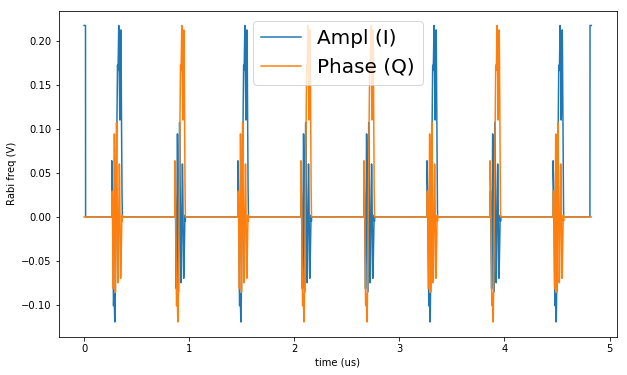

In [676]:
# ATTENTION: the plot is only correct, if params for 'sequence' == params of 'fom_func'

try:
    sequence = exp_oc_nrep_from_pulse(pulse, t_gap=500e-9, n_rep=1*8, pi_x_initread=0.5,
                                      #pulse, t_gap=1/2.1e6, n_rep=1*8, pi_x_initread=0.5,
                                      symmetrize=True, dd_type=DDMethods.XY8)

    t_amplitude = sequence.get_timegrid(unit='us')
    amplitude = sequence.get_data_ampl(unit='V')
    t_phase = sequence.get_timegrid(unit='us')
    phase = sequence.get_data_phase(unit='V')


    plt.figure(figsize=(10,6))
    plt.plot(t_amplitude, amplitude, label="Ampl (I)")
    plt.plot(t_phase, phase, label="Phase (Q)")
   # plt.plot(t_phase, phase+amplitude, label="I+Q")
    plt.ylabel("Rabi freq (V)")
    plt.xlabel("time (us)")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")
    
    
fom_func = setup_fom_simulation_sigz(f_res, func_pulse_2_seq=exp_oc_nrep_from_pulse, 
                                     #scan_kwarg_key='n_rep', scan_list=[1,2,3,4], scan_fom_target=[1,1,0,0],
                                      scan_kwarg_key='n_rep', scan_list=[1,2,3,4,5,6,7,8],
                                     scan_fom_target=[1,1,0,0,0,1,1,0],
                                     t_gap=1/2.1e6, n_rep=2, pi_x_initread=0.5, 
                                     symmetrize=True, dd_type=DDMethods.XY8)
#fom_func = setup_fom_simulation_sigz(f_res, func_pulse_2_seq=exp_oc_nrep_from_pulse,
#                                     t_gap=1/2.1e6, n_rep=8, pi_x_initread=0.5, dd_type=DDMethods.XY8,
#                                     symmetrize=True)

fom_func = add_penalty_freq_bandstop(fom_func, f_res, f_block, fac_penalty=10, n_f_sim=25, 
                                     symm_block=True, first_fom_req_pulse=True)

script_params['fom_function'] = fom_func


In [494]:
len(t_amplitude), t_oc_pulse

(709044, 1.01e-07)

In [131]:
script_params['fom_func_volt_2_rabi'](1), pulse._func_ampl_v_2_omega_mhz(1)



(52.015604681404426, 52.015604681404426)

In [143]:
#fom_func(get_pulse_from_logic(get_best=False), func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])
fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])

### Simulate first guess

In [178]:
script_params['fom_func_volt_2_rabi']

<function <lambda> at 0x0000004C0E0CAD08>

In [244]:
fom_func = script_params['fom_function']

fom = -1
if script_params['fom_func_volt_2_rabi'] is None:
    fom = fom_func()
else:
    #pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
    fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])

fom,  fom_func

(0.04729710950028043, <function setup_fom_simulation_mathematica.<locals>.fom_func at 0x0000004C07D67048>)

In [254]:
def print_pretty_qsim(qsim):
    excl_keys = ['dd_params', '\u03a91[t]','\u03a91conj[t]', '\u03a92[t]', '\u03a92conj[t]',
                'sim_finished', 'result']
    new_dict = delete_keys_from_dict(qsim, excl_keys)
    
    new_dict['dd_params'] =  dd_2_str(qsim['dd_params'])
    return new_dict

print_pretty_qsim(script_params['wolf_sim_params_last'])

{'sim_backend': 'CNOTTwoQubitsV6', 'shift_ratio': None, 'pi_pulse_params': ('optimal', 'optimal'), 'rho_init': array([[0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), 'params_input': {'gRun': 0.439822971502571, 'crossTalkRun': 1, 'δ1Run': 0.0, 'δ2Run': 0.0, 'Ω1max': 100.53096491487338, 'Ω2max': 100.53096491487338, 'ω1Run': 17751.883448374487, 'ω2Run': 17148.697658885245}, 'exp_params': {'init_state': <TomoInit.ux180_on_2: 8>, 'rotation': <TomoRotations.c2not1: 6>}, 'wolfram_sim_params': {'g': 0.439822971502571, 'Subscript[ω, 1]': 17751.883448374487, 'Subscript[ω, 2]': 17148.697658885245, 'Δ': Times[-182, Pi], 'Subscript[δ, 1]': 0.0, 'Subscript[δ, 2]': 0.0, 'crossTalk': 1, 'pulseParamsP1': {'type': 'optimal', 'func_ampl_v_2_rabi_2piMHz': 502.6548245743669, 'fileAmpl': 'C:\\Software\\qudi_data\\optimal_control_assets\\on_nv=2_amplitude.txt', 'filePhase': 'C:\\Software\\qudi_data\\optimal_control_assets\\on_nv=2_phase.txt', 'fileTimestamp': '2022/09/26-08:35:

In [243]:

lambda_2_str(script_params['fom_func_volt_2_rabi']), pulse


("script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)\n", <user_scripts.Timo.own.optimalcontrol.oc_simlib.ArbPulse object at 0x000000B7E92E1C88>)

### Mathematica sim

In [441]:

dd_order = 1
dd_params = wolf.evaluate(wsim.loadSequenceCPMG(dd_order))
#dd_params = wolf.evaluate(wsim.loadSequenceXY8(dd_order))
pulse_params = setup_pi_pulse_params('optimal_both')
#pulse_params = setup_pi_pulse_params()

delta_f = 0#2*np.pi*0.2  # MHz rad
omega_rabi = 2*np.pi*20 # MHz rad
f_res1 = 2800 # MHz
f_res2 = 2700 # MHz

wsim_params = {'gRun':2*np.pi*0.015, '\u03b41Run':delta_f, '\u03b42Run':delta_f, 'crossTalkRun':1,
              '\u03a91max':omega_rabi, '\u03a92max':omega_rabi,#
               '\u03c91Run':2*np.pi*f_res1, '\u03c92Run':2*np.pi*f_res2,
              }

qsim = setup_sim_params(dd_params, pi_pulse_params=pulse_params,
                        init=TomoInit.ux180_on_1, sim_params=wsim_params)

qsim


{'sim_backend': 'CNOTTwoQubitsV6', 'sim_finished': False, 'shift_ratio': None, 'dd_params': ((Times[Rational[1, 2], Pi], Times[Rational[1, 2], Pi]), 2, 0, Times[Rational[1, 2], Pi], 'CPMG', 1), 'pi_pulse_params': ('optimal', 'optimal'), 'rho_init': array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]]), 'params_input': {'gRun': 0.09424777960769379, 'δ1Run': 0, 'δ2Run': 0, 'crossTalkRun': 1, 'Ω1max': 125.66370614359172, 'Ω2max': 125.66370614359172, 'ω1Run': 17592.91886010284, 'ω2Run': 16964.600329384884}, 'exp_params': {'init_state': <TomoInit.ux180_on_1: 7>, 'rotation': <TomoRotations.c2not1: 6>}}

In [214]:
#rho = run_wsim(qsim)
qsim

In [193]:

rho_opt = get_opt_rho(qsim, True)
fidelity, sph_err = state_fidelity(rho, rho_opt), calc_sph_error(rho, qsim)
fidelity 

0.5883122995069907

In [297]:
func_ampl_v_2_2pimhz = qsim['wolfram_sim_params']['pulseParamsP1']['func_ampl_v_2_rabi_2piMHz']
script_params['fom_func_volt_2_rabi'](1)*2*np.pi == func_ampl_v_2_2pimhz


True

### Run Sim Optimization

In [201]:
#f_res = script_params['pulsed_generation_params']['microwave_frequency']
try:
    script_params['fom_func_volt_2_rabi'] = lambda y: y/ampl_rect*(1e-6/t_rabi_rect)



    ######################################################################################################
    # Parameters and Settings
    ######################################################################################################

    # runtime of each experiment
    runtime = script_params['runtime_per_epoch']
    length_oc = script_params['length_oc'] 

    # parameter to stop the experiment if its set to False in the console
    pulsedmasterlogic.globalrun = True
    uglobals.abort.clear()
    logger.info("Starting new closed-loop quocs optimization")


    # array to save the fom evolution
    fom_all = []

    # This section is devoted to the initialization in the pulsed logic and optimization logic of the main
    # settings and parameters to be usde in the creation ofthe pulse sequence and the optimization
    # Iteration, controls and figure of merit to compare with QuOCS
    # Just an example for debug
    args_dict = {"is_noisy": script_params['is_noisy']}
    qubit = OneQubit2Fields(args_dict)

    ######################################################################################################
    # Measurement
    ######################################################################################################
    optimalcontrol.start_optimization()

    # crucial, maybe it can be much shorter
    time.sleep(1)

    # Just a time to check for latent time
    last_time_fom = time.time()
    # repeat the whole process until its manually stopped or QuOCS finsihed the optimization
    # Wait few seconds before starting to get and return data
    while not optimizationlogic.handle_exit_obj.is_user_running:
        time.sleep(0.1)
        if (time.time() - last_time_fom) > 30 or uglobals.abort.is_set():
            logger.warning("Timeout or abort while initializing quocs.")
            uglobals.abort.set()
            break

    # iteration number
    it_val = 0

    # when did the optimization start?
    opt_start_time = time.time()
    try:
        # print("Check before the loop starts: {0}".format(optimizationlogic.handle_exit_obj.is_user_running))
        while optimizationlogic.handle_exit_obj.is_user_running == True and not uglobals.abort.is_set():
            time_stamp=time.time()
            # wait until QuOCS optimizes the controls
            # print("Wait until the controls logic gives the controls")
            while not controlslogic.are_pulses_calculated:
                qWait(100)
                # If the waiting time exceed 10 seconds left stop the optimization
                if time.time() - last_time_fom > 20:
                    logger.error("Too much time... Exit!")
                    optimizationlogic.handle_exit_obj.is_user_running = False
                    break


            #######################################################################################################
            # Get the Controls
            #######################################################################################################
            # Change the status of control calculations to avoid to evaluate the fom twice with the same controls
            controlslogic.are_pulses_calculated = False
            # Get the controls from the controls logic
            pulse = get_pulse_from_logic(get_best=False)
            t_amplitude = pulse.get_timegrid(unit='s')
            t_phase = pulse.get_timegrid(unit='s')
            amplitude = pulse.get_data_ampl(unit='V')
            phase = pulse.get_data_phase(unit='V')
            #######################################################################################################
            # Perform the measurement
            #######################################################################################################

            # save the pulses as .txt files (predefined methods doesn't allow us to upload a numpy array as 
            # parameter)
            data_ampl = np.column_stack((t_amplitude, amplitude))
            data_phase = np.column_stack((t_phase, phase))
            save_pulse(folder_path, data_ampl, data_phase, name=filename)
            save_pulse(folder_path + '/tmp_pulses', data_ampl, data_phase, name=filename + f"idx={it_val}_")

            qWait(1500)


            measurement_start_time = time.time()

            # option to stop the measurement
            if pulsedmasterlogic.globalrun == False or uglobals.abort.is_set():
                print('Stopping the measurement!')
                break


            #######################################################################################################
            # Analysis
            ######################################################################################################

            fom_func = script_params['fom_function']
            if script_params['fom_func_volt_2_rabi'] is None:
                fom = fom_func()
            else:
                pulse = ArbPulse.load_pulse(folder_path, filename, unit_t='s', unit_data='V')
                fom = fom_func(pulse, func_volt_2_rabi=script_params['fom_func_volt_2_rabi'])

            fom += np.random.normal(0, script_params['readout_noise'])
            fom = abs(fom)

            fom_all.append(fom)

            # Update the figure of merit and the standard deviation to the fom logic
            fomlogic.update_fom(fom, script_params['readout_noise'], status_code=0)   # todo: define above
            #fomlogic.update_fom(fom, std, status_code=0)

            # update the last time the fom is calculated
            last_time_fom = time.time()
            
            # for safety: continously safe best result
            try:
                save_optimization_result(folder_path)
            except:
                logger.exception("")

            qWait(200)

        # when did the optimization stop?
        opt_end_time = time.time()

        print('It took QuOCS ' + str(opt_end_time-opt_start_time) + ' s to optimize the pulse!')
    except:
        logger.exception("")
    finally:
        # give a very high fom to the optimization algorithm
        # and status code -1, to interrupt the optimization smoothly
        uglobals.abort.set()
        optimizationlogic.handle_exit_obj.is_user_running = False
        logger.info('Stopping the optimization!')
        fomlogic.update_fom(10**10, status_code=-1)

    print("Optimization finished")
except:
    logger.exception("")

In [3]:
0

0

# Simulate pulse response

Shaddowed from oc_pulse_analysis

In [59]:
import qutip
def get_f_limits(f_res, f_centers_block, df=10e6, symm_block=False):
    f_centers_block_mhz = 1e-6 * np.asarray(f_centers_block).flatten()
    f_res_mhz = f_res*1e-6
    df_mhz = df*1e-6
    freqs = []
    if symm_block:
        deltas = []
        for f_mhz in f_centers_block_mhz:
            deltas.append(abs(f_mhz - f_res_mhz))
        
        f_centers = []
        for d_mhz in deltas:
            f_center_2_mhz_min = f_res_mhz - d_mhz
            f_center_2_mhz_plus = f_res_mhz + d_mhz
            f_centers.append(f_center_2_mhz_min)
            f_centers.append(f_center_2_mhz_plus)
    else:
        f_centers = f_centers_block_mhz

    for f in f_centers:
        freqs.append([1e6*(f-df_mhz), 1e6*(f+df_mhz)])
    return freqs

    
def calc_crosstalk_penalty(freqs, spin_pop, f_res, f_center_block, df, symm_block=False, fac_penalty=1):

    
    idxs = np.empty((0), dtype=int)
    for (f_min, f_max) in get_f_limits(f_res, f_center_block, df, symm_block=symm_block):      
        idxs = np.append(idxs, np.where(np.logical_and(freqs >= f_min, freqs <= f_max)))
    
    #return idxs
    spin_pop = np.mean(spin_pop[idxs])
    
    # as in optimalcontrol_quocs.ipynb
    fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
    
    return fom_sim


def run_sim(pulse, B_gauss, sim_params, delta_f=0e6, nv_init_ux=None, nv_read_ux=None,
                  n_timebins=None, t_idle_extension=-1e-9):
    
    sim = TimeDependentSimulation()

    return sim.run_sim(pulse, B_gauss, sim_params, delta_f, nv_init_ux, nv_read_ux,
                  n_timebins, t_idle_extension)
    
def run_sim_OLD(self, pulse, B_gauss, sim_params, delta_f=0e6, nv_init_ux=None, nv_read_ux=None,
                  n_timebins=None, t_idle_extension=-1e-9):
    # for compability reason, accept pulse as dict or ArbPulse object
    # if supplying a dict, you are responsible for correct units!
    if type(pulse) == ArbPulse:
        pulse.set_unit_time('us')
        pulse.set_unit_data('MHz')
        pulse = pulse.as_dict()
    
    if n_timebins is None:
        n_timebins = len(pulse['timegrid_ampl'])
    
    B = B_gauss
    simp = sim_params
    oc_length = pulse['timegrid_ampl'][-1] + t_idle_extension*1e6
    delta_f_mhz = delta_f*1e-6
    
    t = np.linspace(0, oc_length, n_timebins)
     
    #logger.info(f"solver steps: {int(1e8*oc_length/0.1)}")
        
    options=qutip.Options(atol=1e-15, rtol=1e-15, nsteps=int(1e8), store_final_state=True)

    init_state = simp.rho_ms0
    if nv_init_ux is not None:
        u = np.asarray(nv_init_ux)
        init_state = np.matmul(np.matmul(u,init_state),u.conj().T)
        init_state = qutip.Qobj(init_state, dims=sim_params.dims)
    
    freq = simp.D - simp.gamma_nv * B 
    
    # perform the measurement
    oc_el = TimeDependentSimulation.oc_element(t, pulse['timegrid_ampl'], pulse['data_ampl'], pulse['data_phase'],
                                               freq+delta_f_mhz, B, 1, simp)
    #return oc_el
    results_measurement = qutip.mesolve(oc_el, init_state, t, [], [simp.P_nv],
                                            options=options, progress_bar=None)
    
    rho_final = results_measurement.final_state
    if nv_read_ux is not None:
        u = np.asarray(nv_read_ux)
        rho_final = np.matmul(np.matmul(u,rho_final),u.conj().T)
        rho_final = qutip.Qobj(rho_final, dims=sim_params.dims)
    
    return rho_final

def run_sim_mult_nv(self, pulses, B_gauss, sim_params, delta_f=0e6, nv_init_ux=None, nv_read_ux=None,
                  n_timebins=None, t_idle_extension=-1e-9):
    raise NotImplemetend #cant calculate crosstalk this way!
    if not (len(B_gauss) == len(pulses)):
        raise ValueError
    
    rhos_res, rhos_ct = [],[]
    rhos_per_nv = []
    for j, B in enumerate(B_gauss):
        rhos = []
        for i, pulse in enumerate(pulses):
            if i==j:
                # resonant
                rho = run_sim(self, pulse, B, sim_params, delta_f=delta_f, nv_init_ux=nv_init_ux, nv_read_ux=nv_read_ux,
                              n_timebins=n_timebins, t_idle_extension=t_idle_extension)
                rhos.append(rho)
                rhos_res.append(rho)
            else:
                # crosstalk
                B_res = B_gauss[j]
                B_crosstalk = B - B_res
                delta_f_i = delta_f + simp.gamma_nv*B_crosstalk
                rho =run_sim(self, pulse, B_res, sim_params, delta_f=delta_f_i, nv_init_ux=nv_init_ux, nv_read_ux=nv_read_ux,
                          n_timebins=n_timebins, t_idle_extension=t_idle_extension)
                rhos.append(rho)
                rhos_ct.append(rho)
                
        # sum over rho_res + rho_cross
        rhos_per_nv.append(sum(rhos))
    
    return rhos, rhos_res, rhos_ct


def sim_process_tomo(pulse, B, delta_f=0e6):
    
    is_multi_pulse = isinstance(pulse, list)
    
    rhos = []
    # convention in calc_chi: [1, pix, pi2x, pi2y]
    us_init = [None, 2*simp.S_x, scipy.linalg.sqrtm(2*simp.S_x) , scipy.linalg.sqrtm(2*simp.S_y)]

    for u_x in us_init:
        if is_multi_pulse:
            rho = sim.run_sim_multi(pulse, B, simp, delta_f=delta_f, nv_init_ux=u_x, nv_read_ux=None)
        else:
            rho = sim.run_sim(pulse, B, simp, delta_f=delta_f, nv_init_ux=u_x, nv_read_ux=None)
        rho_nv = partial_trace(rho, sub=0, dims=simp.dims)
        rho_nv = swap_basis_def(rho_nv)  # basis definition in Philip V. code is different

        rhos.append(rho_nv)

    chi_tomo = calc_chi(rhos[0], rhos[1], rhos[2], rhos[3])
    chi_tomo = swap_basis_def(chi_tomo)
    
    return chi_tomo

def sim_process_tomo_avg_hfs(pulse, B, delta_hfs=2.1e6):
    res_chi = []
    for delta in [0,-delta_hfs,+delta_hfs]:
        res_chi.append(sim_process_tomo(pulse, B, delta_f=delta))
    sim_process_tomo
    return sum(res_chi)/3

def sim_process_tomo_avg(pulse, B, deltas=[0e6]):
    res_chi = []
    for delta in deltas:
        res_chi.append(sim_process_tomo(pulse, B, delta_f=delta))
    
    return sum(res_chi)/len(res_chi)

def partial_trace(rho, sub=0, dims=None):
    if dims is None:
        dims = [[2,2],[2,2]]
    return np.asarray(qutip.Qobj(rho, dims=dims).ptrace(sub))    

def swap_basis_def(rho):
    # Genkos state definition is different!
    return np.rot90(rho,2).T
    

B = 100
simp = SimParameters() 
sim = TimeDependentSimulation()
B

100

In [28]:
partial_trace(rho_nv[1], sub=0, dims=simp.dims)

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-0625ca131436>", line 1, in <module>
    partial_trace(rho_nv[1], sub=0, dims=simp.dims)
NameError: name 'rho_nv' is not defined


In [431]:


#sim = TimeDependentSimulation()
#sim.run_sim_multi = run_sim_multi
#sim.oc_element_multi_pulse = oc_element_multi_pulse
#sim.oc_element_multi_pulse
#TimeDependentSimulation.oc_element_multi_pulse = oc_element_multi_pulse
#oc_element_multi_pulse

In [147]:
len(pulse.timegrid)

2500

In [379]:
rho = -1
try:
    rho = sim.run_sim_multi([pulse, pulse2], [ 91.44, 62.17], simp,# scale_ampl=[1,1/1.747],
                            delta_f=0, 
                            n_timebins=None, nv_init_ux=None, nv_read_ux=None)
except:
    logger.exception("")
partial_trace(rho, sub=0, dims=simp.dims)

array([[0.00741748+0.j        , 0.05949306+0.03622606j],
       [0.05949306-0.03622606j, 0.99258252+0.j        ]])

In [339]:
1/1.747

0.5724098454493417

In [383]:
rho = -1
try:
    rho = sim.run_sim_multi([pulse2, pulse], [62.17, 91.44], simp,# scale_ampl=[1/1.747,1],
                            delta_f=0, 
                            n_timebins=None, nv_init_ux=None, nv_read_ux=None)
except:
    logger.exception("")
partial_trace(rho, sub=0, dims=simp.dims)

array([[0.10230949+0.j        , 0.00967988-0.23158768j],
       [0.00967988+0.23158768j, 0.89769051+0.j        ]])

0.24418524595860924

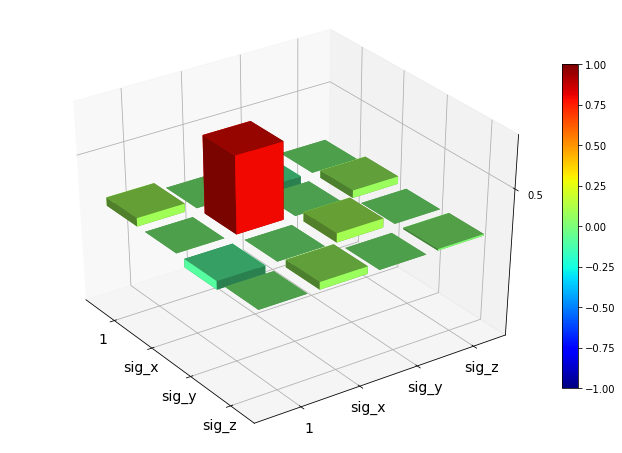

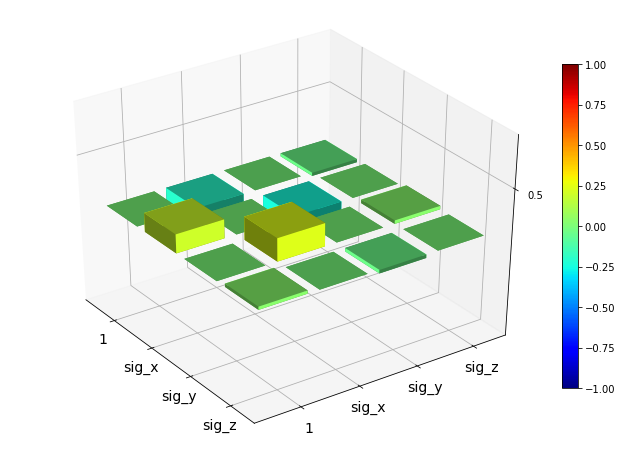

In [387]:
idx = 1

# ATTENTION: parallel pi pulse might have some scaling between NV1/NV2
# here need to balance this during loading of pulse

try:
    if idx == 0:
        chi = sim_process_tomo([pulse, pulse2], [ 91.44, 62.17])
    else:
        chi = sim_process_tomo([pulse2, pulse], [62.17 , 91.44])
        
    fom = np.real(1 - fidelity_chi_pi_x(chi))
except:
    logger.exception("")
    
chi, fom

qutip.matrix_histogram(np.real(chi), limits=[-1,1],
                       xlabels=["1", "sig_x", "sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "sig_y", "sig_z"])


plt.show()
qutip.matrix_histogram(np.imag(chi), limits=[-1,1],
                       xlabels=["1", "sig_x", "sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "sig_y", "sig_z"])


plt.show()
fom

### Test solver: Vary time discretization

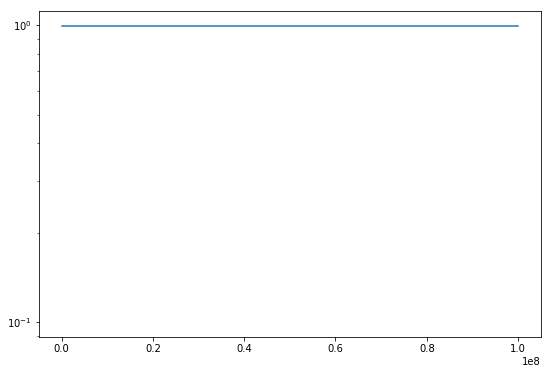

In [221]:
# Vary the solving/ pulse discretization steps. 
# When big enough, the results shouldn't change anymore with the step settigns

n_steps = np.linspace(100, 1e8, 3)
res = []
for ns in n_steps:
    rho = sim.run_sim_multi(None, [pulse, pulse2], [100,200], simp, scale_ampl=[1,1], delta_f=0, 
                            n_timebins=None, n_sol_step=ns, nv_init_ux=None, nv_read_ux=None)

    res.append(partial_trace(rho, sub=0, dims=simp.dims)[1][1])
    
res
plt.plot(n_steps, res)
plt.yscale('log')
plt.show(res)

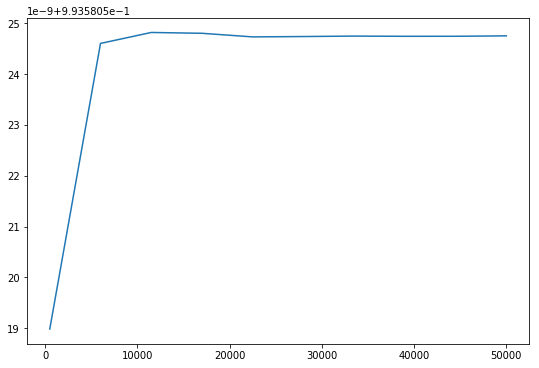

In [230]:
n_steps = np.linspace(500, 5e4, 10)
res = []
for ns in n_steps:
    rho = sim.run_sim_multi(None, [pulse, pulse2], [100,200], simp, scale_ampl=[1,1], delta_f=0, 
                            n_timebins=ns, n_sol_step=1e8, nv_init_ux=None, nv_read_ux=None)

    res.append(partial_trace(rho, sub=0, dims=simp.dims)[1][1])
    
plt.plot(n_steps, res)
#plt.yscale('log')
plt.show(res)

## Density matrix evolution

In [683]:
# take a sequence made from a pulse to calculate the spectrum+
tmp_pulse = pulse
pulse = sequence


In [667]:
pulse.as_dict()['timegrid_ampl'][-1]

In [407]:
try:
    rho = -1
    rho = run_sim(pulse, B, simp, delta_f=0e6, nv_init_ux=None, nv_read_ux=None)

    #partial_trace(rho, sub=0, dims=simp.dims)
except:
    logger.exception("")

In [410]:
partial_trace(rho, sub=0, dims=simp.dims)

array([[0.00666856+0.j        , 0.0398083 +0.01811997j],
       [0.0398083 -0.01811997j, 0.99333144+0.j        ]])

In [472]:
rho[2][1]

array([0.        , 0.00019952, 0.00082317, ..., 0.05953341, 0.05121275,
       0.04356924])

## Process tomo

In [413]:
func_volt_2_rabi=script_params['fom_func_volt_2_rabi']
# sim units are MHz!
B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv
pulse_sim = copy_pulse(pulse)
pulse_sim._func_ampl_v_2_omega_mhz = func_volt_2_rabi

try:
    chi_avg = sim_process_tomo_avg_hfs(pulse_sim,  B_gauss, delta_hfs=2.1e6)
    fom = np.real(1 - fidelity_chi_pi_x(chi_avg))
except:
    logger.exception("")

 
fom, chi_avg

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-413-663b16176d94>", line 1, in <module>
    func_volt_2_rabi=script_params['fom_func_volt_2_rabi']
NameError: name 'script_params' is not defined


In [201]:
f_res-25.31e6

2799990000.0

In [239]:
# procTomo at blockband, should be chi=1

B_gauss = (simp.D - f_res*1e-6)/ simp.gamma_nv
chi = -1
try:
    chi = sim_process_tomo_avg(pulse,  B_gauss, deltas= [-25300001, -25299999.])
except:
    logger.exception("")

chi
np.real(1 - fidelity_chi_pi_x(chi, u_target='1'))#, B_gauss, B_gauss, pulse._func_ampl_v_2_omega_mhz

0.1679425542515418

## Spectrum

In [1034]:
import qutip
try:
    def run_sim_fsweep(freq_array, pulse, B_gauss, sim_params, n_timebins=None, t_idle_extension=-1e-9,
                       ampl_err=0):

        # for compability reason, accept pulse as dict or ArbPulse object
        # if supplying a dict, you are responsible for correct units!
        if type(pulse) == ArbPulse:
            pulse.set_unit_time('us')
            pulse.set_unit_data('MHz')
            pulse = pulse.as_dict()

        if n_timebins is None:
            n_timebins = len(pulse['timegrid_ampl'])

        B = B_gauss
        simp = sim_params
        oc_length = pulse['timegrid_ampl'][-1] + t_idle_extension*1e6

        t = np.linspace(0, oc_length, n_timebins)
        options=qutip.Options(atol=1e-15, rtol=1e-15, nsteps=1e8, store_final_state=True)

        init_state = simp.rho_ms0

        # perform the measurement
        data_freq_detuning = np.zeros(len(freq_array))
        for idx,freq in enumerate(freq_array):
            oc_el = TimeDependentSimulation.oc_element(t, pulse['timegrid_ampl'], pulse['data_ampl'], pulse['data_phase'],
                                                       freq, B, 1+ampl_err, simp)
            results_measurement = qutip.mesolve(oc_el, init_state, t, [], [simp.P_nv],
                                                options=options, progress_bar=None)
            data_freq_detuning[idx] = results_measurement.expect[0][-1]

        return data_freq_detuning
except:
    logger.exception("")
0

0

In [945]:
f_res, f_block

(2825300000.0, [2921300000.0, 2935600000.0])

In [354]:
tmp_pulse.name

'20220729_1_guessFromReisserMsc_penalty_fac=100/opt_res_'

In [543]:
# take a sequence made from a pulse to calculate the spectrum+
tmp_pulse = pulse
pulse = sequence


In [1055]:

B = abs(f_res*1e-6-simp.D)/simp.gamma_nv
df = 50 #120#120 # MHz

f_block_sim = np.asarray(f_block) *1e-6 # MHz
df_block = 10
symm_block = True
fac_penalty = 100
f_mw = simp.D - simp.gamma_nv * B


n_f = np.min([int(df/0.25), 500])
n_f= 50



sim = TimeDependentSimulation()

freq_array = np.linspace(simp.D - simp.gamma_nv * B - df, simp.D - simp.gamma_nv * B + df, n_f)
#freq_array = np.linspace(3000, 3200, n_f)
#freq_array = np.linspace(2000, 3200, n_f)


# ATTENTION: limits sampling rate to 1 GSa/s
n_tbins = int(pulse.get_timegrid(unit='s')[-1]/1e-9)
#data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B, simp, n_timebins=n_tbins)
data_freq_detuning = run_sim_fsweep(freq_array, pulse, B, simp)
#data_freq_detuning = run_sim_fsweep(None, freq_array, pulse, B, simp)
penalty = calc_crosstalk_penalty(1e6*freq_array, data_freq_detuning, 1e6*f_mw, 1e6*f_block_sim, 1e6*df_block,
                                 symm_block=symm_block, fac_penalty=fac_penalty)


In [550]:
int(pulse.get_timegrid(unit='s')[-1]/1e-9)

4826

In [452]:
len(pulse.timegrid), tmp_pulse.name

(2712223, '20220729_1_guessFromReisserMsc_penalty_fac=100/opt_res_')

In [585]:
pulse = tmp_pulse

0

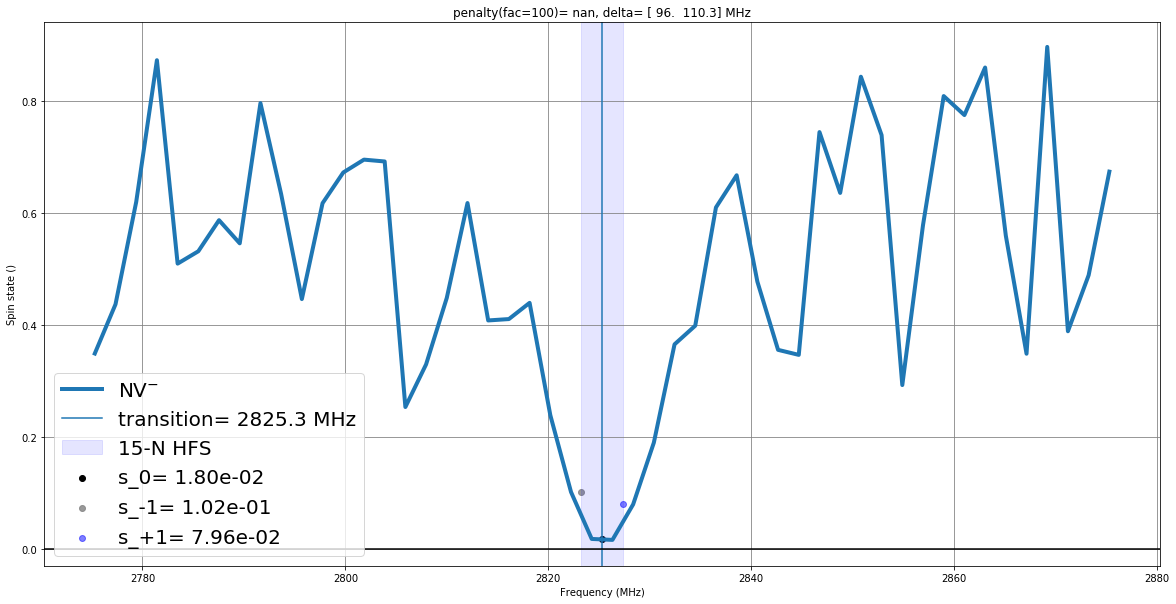

In [1069]:
try:
    delta_hfs = 2.1 # MHz
    f_mw = simp.D - simp.gamma_nv * B

    # value at the HFS values
    vals = []
    deltas = [0, -delta_hfs, delta_hfs]
    for delta in deltas:
        idx = np.argmin(abs(freq_array-(f_mw+delta)))
        vals.append(data_freq_detuning[idx])


    title_str = ""

    # visualize the results
    fig1, ax = plt.subplots(figsize=(20,10))
    ax.plot(freq_array, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
    #ax.plot(freq_array+2*(B-B_nv2)/2*simp.gamma_nv, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
    #ax.plot(f_exp_mhz, y_exp, label="exp")
    #ax.plot(f_exp_mhz_mirr, y_exp, label="mirrored(exp)")
    #ax.set_xlim([2603,2653])

    # vertical dots at values of HFS transitions
    ax.scatter(f_mw+deltas[0], vals[0], color='black', label=f"s_0= {vals[0]:.2e}")
    ax.scatter(f_mw+deltas[1], vals[1], color='grey', label=f"s_-1= {vals[1]:.2e}", alpha=0.8)
    ax.scatter(f_mw+deltas[2], vals[2], color='blue', label=f"s_+1= {vals[2]:.2e}", alpha=0.5)

    ax.axvline(f_mw, label=f"transition= {f_mw:.1f} MHz")
    ax.axvspan(f_mw-2.1, f_mw+2.1, alpha=0.1, color='blue', label='15-N HFS')


    # blockbands
    f_lims = get_f_limits(1e6*f_mw, 1e6*f_block_sim, 1e6*df_block, symm_block=symm_block)
    for f_min, f_max in f_lims:
        f_center = (f_max + f_min) / 2
        if 1e-6*f_center > freq_array[0] and 1e-6*f_center < freq_array[-1]: 
            ax.axvline(1e-6*f_center, label=f"NV1 blockband ({1e-6*f_center:.1f} +- {df_block} MHz)", color='red')
            ax.axvspan(1e-6*f_min, 1e-6*f_max, alpha=0.1, color='red')

    title_str += f"penalty(fac={fac_penalty})= {penalty:.3f}, delta= {abs(f_mw-f_block_sim)} MHz"

    # grid
    ax.axhline(0, color='black')
    #ax.axhline(1, color='black')
    plt.grid(axis='x', color='0.5')
    plt.grid(axis='y', color='0.5')




    ax.set_xlabel(r'Frequency (MHz)')
    ax.set_ylabel(r'Spin state ()')
    plt.title(title_str)
    ax.legend(loc='best', prop={'size': 20})
    plt.show(fig1)

except:
    logger.exception("")
0

In [203]:
f_block

[2921300000.0, 2935600000.0]

## Amplitude error

In [173]:
B= 90 #gauss


sim = TimeDependentSimulation()

# scanned amplitude steps
amp_array = np.linspace(-0.35, 0.35, 30)
data_amp_detuning = sim.run_sim_ampsweep(amp_array, pulse, B, simp)



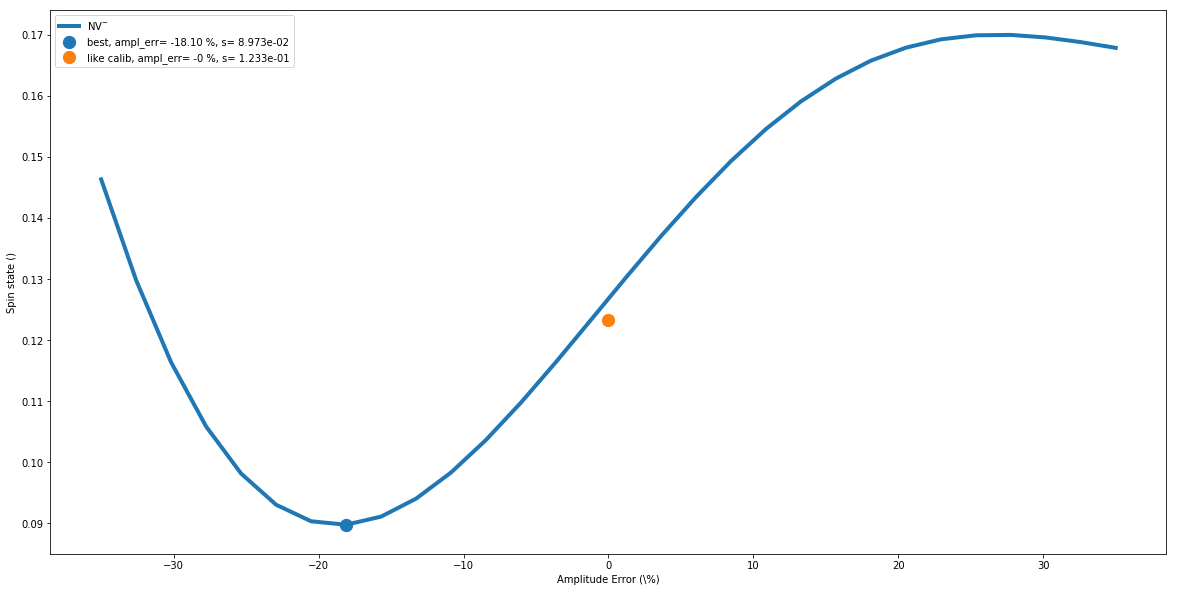

In [176]:
# visualize the results
fig2, ax = plt.subplots(figsize=(20,10))
ax.plot(amp_array*100, data_amp_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
ax.set_xlabel(r'Amplitude Error (\%)')
ax.set_ylabel(r'Spin state ()')

# value at the minimum
vals_x, vals_y = [], []
idx = np.argmin(data_amp_detuning)
vals_x.append(100*amp_array[idx])
vals_y.append(data_amp_detuning[idx])

plt.scatter(vals_x, vals_y, label=f"best, ampl_err= {vals_x[0]:.2f} %, s= {vals_y[0]:.3e}", s=150)

vals_x, vals_y = [], []
idx = np.argmin(abs(amp_array))
vals_x.append(amp_array[idx])
vals_y.append(data_amp_detuning[idx])

plt.scatter(vals_x, vals_y, label=f"like calib, ampl_err= {vals_x[0]:.0f} %, s= {vals_y[0]:.3e}", s=150)



plt.legend()
plt.show(fig2) 

In [1472]:
data_amp_detuning

array([0.52830133, 0.50118982, 0.47417666, 0.44734311, 0.42076835,
       0.39452924, 0.36870006, 0.34335231, 0.31855458, 0.29437232,
       0.27086773, 0.24809966, 0.22612349, 0.20499109, 0.18475073,
       0.16544708, 0.14712119, 0.12981046, 0.11354871, 0.09836618,
       0.08428957, 0.07134209, 0.05954358, 0.0489105 , 0.03945607,
       0.03119032, 0.0241202 , 0.01824965, 0.01357969, 0.01010855])